Victor Mikhaylov, vmikhayl@ias.edu<br>Institute for Advanced Study, 2021-2022

In [1]:
import os
import stat
import time
import pickle
import numpy as np
import pandas as pd
import re

if True:# True: # CLOSE FOR PANDORA ENV
    import tfold.nn.nn_predict as nn_predict            
    import seaborn as sns
    import tfold.modeling.make_inputs as make_inputs

import tfold.utils.seq_tools as seq_tools
seq_tools.load_mhcs()

import tfold.utils.pdb_tools as pdb_tools
import tfold.utils.utils as utils        
import tfold.modeling.template_tools as template_tools
import tfold.modeling.result_parse_tools as result_parse_tools

import importlib
import tfold.config
#importlib.reload(tfold.config)
importlib.reload(result_parse_tools)
importlib.reload(template_tools)
importlib.reload(make_inputs)
#importlib.reload(nn_predict)

from matplotlib import pyplot as plt


cwd=os.getcwd()
source_dir=cwd+'/data/experimental_structures/processed_updated' #path to the database

template_tools.load_data(source_dir)

date_cutoff='2018-04-30' #AlphaFold training set cutoff

MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  1.8 s
MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  2.1 s


In [ ]:
#TODO:
#NUMSEQ.repair_gaps uses alphabetic order, which leads to wrong ordering 
#e.g. for [02,01] residues in the beginning of HLA-DRA
#currently, we reorder according to seq_tools.mhcs before modeling, 
#but need to fix everywhere, incl database

In [2]:
#load data
with open(source_dir+'/pmhcs.pckl','rb') as f:
    pmhcs=pickle.load(f)
print(len(pmhcs))
print(pmhcs[0].keys())
with open(source_dir+'/pmhcs_seq_clusters.pckl','rb') as f:
    pmhcs_seq_clusters=pickle.load(f)
print(len(pmhcs_seq_clusters))
print(pmhcs_seq_clusters[0].keys())
with open(source_dir+'/summary.pckl','rb') as f:
    summary=pickle.load(f) 
print(len(summary))
print(summary['1ao7_0'].keys())

pmhcs_df=pd.read_pickle(source_dir+'/pmhcs_df.pckl')
print(len(pmhcs_df))
print(pmhcs_df.columns)

#896,453,2300 -> 928,486,2382

928
dict_keys(['P', 'M', 'class', 'pdbs', 'date', 'pep_pdbnum', 'id', 'bound', 'cluster_seq', 'cluster_CA', 'tails', 'netmhc_tails', 'netmhc_kd'])
486
dict_keys(['id', 'pmhc_ids', 'pdbs', 'date'])
2382
dict_keys(['pdbid', 'P', 'M', 'A', 'B', 'pep_hetero', 'pep_gaps', 'includes_mhc', 'includes_tcr', 'date', 'resolution', 'pmhc_id', 'tcr_A_id', 'tcr_B_id', 'complex_id'])
928
Index(['id', 'class', 'cluster_seq', 'cluster_CA', 'date', 'pep', 'tails',
       'linker', 'mhc_a_allele', 'mhc_b_allele', 'netmhc_core', 'netmhc_kd',
       'netmhc_tails'],
      dtype='object')


In [ ]:
########!!!!!!!!!########
#WARNING: fixed error in netmhc tail parser for cl II, but in some old result_df files still old incorrect registers!
#careful when counting netmhc regerr!
########!!!!!!!!!########

# choose pmhcs to model, look at peplen distributions

In [ ]:
#note: here and elsewhere use <date_cutoff and >=date_cutoff
#perhaps would be more appropriate to use <= and >, but don't care as long as it is consistent
#also, no structures actually at date cutoff

In [25]:
#pmhcs with multiple registers
seq_to_id={}
for x in pmhcs:
    seq=''.join(x['P']['data']['seq'])
    seq+='_'+''.join(x['M']['data']['seq'])
    if x['class']=='II':
        seq+='_'+''.join(x['N']['data']['seq'])
    seq_to_id.setdefault(seq,[]).append(x['id'])
for x in seq_to_id.values():
    if len(x)>1:
        print(x)
        for y in x:
            z=pmhcs[y]
            assert z['id']==y
            print(y,z['date'],z['date']<date_cutoff,z['class'])            
            m=z['M']['info']
            print(''.join(z['P']['data']['seq']),m['species'],m['locus'],m['allele'],z['netmhc_kd'])
        print()
pmhcs_w_mult_reg_ids=[x for y in seq_to_id.values() for x in y if len(y)>1]
print(len(pmhcs_w_mult_reg_ids))

#conclusion: all of them are before cutoff date

[39, 249]
39 2010-07-23 True I
XLAXXLTV 9606 A 02:01 812.0863799128646
249 2010-07-23 True I
XLAXXLTV 9606 A 02:01 812.0863799128646

[217, 748]
217 2008-05-12 True I
LLFGXPVYV 9606 A 02:01 2.594055462809111
748 2008-05-09 True I
LLFGXPVYV 9606 A 02:01 2.594055462809111

[255, 341]
255 2006-05-01 True I
AAGIGILTV 9606 A 02:01 3873.7670014369387
341 2017-10-12 True I
AAGIGILTV 9606 A 02:01 3873.7670014369387

[390, 890]
390 2017-08-11 True I
MMWDRGLGMM 9606 A 02:01 97.62114559307155
890 2017-08-11 True I
MMWDRGLGMM 9606 A 02:01 97.62114559307155

[422, 450]
422 2005-07-01 True I
KAFSPEVIPMF 9606 B 57:03 37.38912145012966
450 2005-07-01 True I
KAFSPEVIPMF 9606 B 57:03 37.38912145012966

[430, 730]
430 2010-07-23 True I
ELAXXLTV 9606 A 02:01 8580.405066194853
730 2010-07-23 True I
ELAXXLTV 9606 A 02:01 8580.405066194853

[728, 729]
728 2015-04-06 True I
LYLVCGERGF 10090 K d 9175.746456253162
729 2015-04-06 True I
LYLVCGERGF 10090 K d 9175.746456253162

14


In [26]:
aa_set=set(list('ACDEFGHIKLMNPQRSTVWY'))

gap_cutoff=0  #require no more than this number of gaps in pep

n_gaps=0
n_bad_aa=0
n_mult_reg=0
n_before={'I':0,'II':0}
n_after={'I':0,'II':0}
n_before_all={'I':0,'II':0}
n_after_all={'I':0,'II':0}
pmhcs_seq_clusters_keep=[]
for x in pmhcs_seq_clusters:
    drop=False
    pmhc=pmhcs[x['pmhc_ids'][0]]
    structure=summary[pmhc['pdbs'][0][0]]
    pep=pmhc['P']
    pep_structure=structure['P']
    cl=pmhc['class']    
    if x['date']<date_cutoff:
        n_before_all[cl]+=1
    else:
        n_after_all[cl]+=1
    if pmhc['id'] in pmhcs_w_mult_reg_ids:
        drop=True
        n_mult_reg+=1
    if cl=='I': #for cl I, count gaps everywhere
        pepseq=pep_structure['data']['seq']
    else:       #for cl II, only count gaps in ext binding core, since tails move around and we don't care
        pepseq=pep_structure['data']['seq'][(pep_structure['data']['pdbnum']>='   09')&(pep_structure['data']['pdbnum']<='   9 ')]
    #print(''.join(pepseq))
    gap_count=np.sum([c.islower() for c in pepseq])
    if gap_count>gap_cutoff:
        drop=True
        n_gaps+=1            
    if set(list(pep['data']['seq']))-aa_set:
        drop=True
        n_bad_aa+=1    
    if not drop:
        pmhcs_seq_clusters_keep.append(x)
        if x['date']<date_cutoff:
            n_before[cl]+=1
        else:
            n_after[cl]+=1
    else:
        if cl=='II' and x['date']>=date_cutoff:
            print('class II test set clusters dropped:',x['id'])    
print('total clusters:',len(pmhcs_seq_clusters))
print('by class and date (before/after):',n_before_all,n_after_all)
print('total kept:',len(pmhcs_seq_clusters_keep))
print('by class and date (before/after):',n_before,n_after)
print('dropped by these reasons:')
print('gaps in pep:',n_gaps)
print('bad aa in pep:',n_bad_aa)
print('binds in mult. registers:',n_mult_reg) #previously verified that all these are before date cutoff

#one cluster dropped from cl II test set: citrullinated peptide

class II test set clusters dropped: 145
total clusters: 486
by class and date (before/after): {'I': 291, 'II': 76} {'I': 107, 'II': 12}
total kept: 444
by class and date (before/after): {'I': 270, 'II': 62} {'I': 101, 'II': 11}
dropped by these reasons:
gaps in pep: 10
bad aa in pep: 33
binds in mult. registers: 2


In [27]:
#length statistics
len_stat={}
for x in pmhcs_seq_clusters_keep:
    k=x['date']<date_cutoff,pmhcs[x['pmhc_ids'][0]]['class']
    l=len(pmhcs[x['pmhc_ids'][0]]['P']['data'])
    len_stat.setdefault(k,[]).append(l)
for cl in ['I','II']:
    print(cl)
    print('before date cutoff:')
    utils.print_hist(len_stat[True,cl])
    print('after date cutoff:')
    utils.print_hist(len_stat[False,cl])
    print()

I
before date cutoff:
8   32
9  164
10  48
11  16
12   5
13   3
14   1
15   1
after date cutoff:
8   8
9  74
10 14
11  1
12  4

II
before date cutoff:
10  1
11  2
12  5
13 15
14 11
15 12
16  6
18  1
19  2
20  3
21  1
22  2
23  1
after date cutoff:
12 1
13 2
14 1
15 3
16 2
19 1
20 1



In [28]:
#netmhc regerr statistics
regerr={'I':0,'II':0}
n_total={'I':0,'II':0}
n_non_triv=0
for x in pmhcs_seq_clusters_keep:
    if x['date']<date_cutoff:
        pmhc=pmhcs[x['pmhc_ids'][0]]
        cl=pmhc['class']
        n_total[cl]+=1
        if cl=='I' and pmhc['tails']!=(0,0):
            n_non_triv+=1
        if pmhc['tails']!=pmhc['netmhc_tails']:
            regerr[cl]+=1
for cl in ['I','II']:
    print(cl)
    print(f'regerr: {regerr[cl]} of {n_total[cl]}')
print('cl I non-trivial registers:',n_non_triv)

I
regerr: 9 of 270
II
regerr: 19 of 62
cl I non-trivial registers: 13


In [29]:
#save
with open(source_dir+'/pmhcs_seq_clusters_filtered.pckl','wb') as f:
    pickle.dump(pmhcs_seq_clusters_keep,f)

# discovery dataset

## load data

In [3]:
#pmhc seq clusters selected for modeling
print('pmhcs seq clusters filtered')
with open(source_dir+'/pmhcs_seq_clusters_filtered.pckl','rb') as f:
    pmhcs_filtered=pickle.load(f) #seq clusters filtered
print(len(pmhcs_filtered))
print(pmhcs_filtered[0].keys())

#make dataframes
df=pd.DataFrame(pmhcs_filtered)
def _map_pep(x):    
    return ''.join(pmhcs[x]['P']['data']['seq'])
def _map_mhc_a(x):    
    return seq_tools.load_NUMSEQ(pmhcs[x]['M'])
def _map_mhc_b(x):    
    if 'N' in pmhcs[x]:
        return seq_tools.load_NUMSEQ(pmhcs[x]['N'])
    else:
        return None
df['pmhc_id']=df['pmhc_ids'].map(lambda x:x[0]) #keep id of the pmhc we model
df['pdb_id']=df['pmhc_id'].map(lambda x:pmhcs[x]['pdbs'][0][0])
df=df.drop(['pmhc_ids'],axis=1)
df=df.drop(['pdbs'],axis=1)
for k in ['class','tails','netmhc_tails','netmhc_kd']:
    df[k]=df['pmhc_id'].map(lambda x: pmhcs[x][k])
df['pep']=df['pmhc_id'].map(_map_pep)
df['mhc_a']=df['pmhc_id'].map(_map_mhc_a)
df['mhc_b']=df['pmhc_id'].map(_map_mhc_b)

#species statistics in the test set
print('test set species')
print('cl 1')
df1=df[df['date']>=date_cutoff]
x=df1[df1['class']=='I']
print(x['mhc_a'].map(lambda a:a.info['species']).value_counts())
print('cl 2')
x=df1[df1['class']=='II']
print(x['mhc_a'].map(lambda a:a.info['species']).value_counts())

#drop test
df=df[df['date']<date_cutoff]
print('before cutoff:',len(df))
#tail statistics for cl 1
x=df[df['class']=='I']
print('cl 1:',len(x))
print('non trivial tails in cl 1:',np.sum(x['tails']!=(0,0)))
print('netmhc errors in cl 1:',np.sum(x['tails']!=x['netmhc_tails']))
x=df[df['class']=='II']
print('cl 2:',len(x))
print('netmhc errors in cl 2:',np.sum(x['tails']!=x['netmhc_tails']))

df_target=df
df_target=df_target.rename({'id':'cluster_seq'},axis=1) #that's what it is
df_target=df_target[df_target.columns[[4,0,3,2,1,5,6,7,8,9,10]]]
df_target=df_target.sort_values(['class','cluster_seq','pmhc_id','pdb_id'])
df_target=df_target.reset_index(drop=True)

#fix MHC pdbnum order to match seq_tools.mhcs
#TODO: fix NUMSEQ.repair_gaps and pdbnum ordering in pmhcs/tcrs in the database! 
def fix_mhc_chain_pdbnums(mhc):
    if not (mhc is None):
        mhc_true=seq_tools.mhcs[mhc.info['species'],mhc.info['locus'],mhc.info['allele']]    
        pdbnum=mhc.data['pdbnum']
        pdbnum_true=mhc_true.data['pdbnum']
        assert set(list(pdbnum))==set(list(pdbnum_true)) #must only differ by permutation
        pdbnum_l=list(pdbnum)
        ind=[pdbnum_l.index(x) for x in pdbnum_true]
        mhc.data=mhc.data[ind] #permute
        return tuple(ind)==tuple(list(range(len(ind))))            
    else:
        return True
mismatches=df_target['mhc_a'].map(fix_mhc_chain_pdbnums)
print('pdbnum misordering in chain A:',np.sum(~mismatches))
mismatches=df_target['mhc_b'].map(fix_mhc_chain_pdbnums)
print('pdbnum misordering in chain B:',np.sum(~mismatches))

#pdbs to exclude from templates: pdbs from the same seq cluster
def _cluster_to_pdbs(x):
    return list(set([a[0].split('_')[0] for a in pmhcs_seq_clusters[x]['pdbs']]))        
df_target['exclude_pdbs']=df_target['cluster_seq'].map(_cluster_to_pdbs)

print(len(df_target))
print(df_target.columns)

pmhcs seq clusters filtered
444
dict_keys(['id', 'pmhc_ids', 'pdbs', 'date'])
test set species
cl 1
9606     72
9823      9
10090     9
9544      3
9031      3
9796      2
9545      1
8022      1
10116     1
Name: mhc_a, dtype: int64
cl 2
9606     9
10090    2
Name: mhc_a, dtype: int64
before cutoff: 332
cl 1: 270
non trivial tails in cl 1: 13
netmhc errors in cl 1: 9
cl 2: 62
netmhc errors in cl 2: 16
pdbnum misordering in chain A: 11
pdbnum misordering in chain B: 0
332
Index(['class', 'cluster_seq', 'pdb_id', 'pmhc_id', 'date', 'tails',
       'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b', 'exclude_pdbs'],
      dtype='object')


## regerr

In [4]:
#run seqnn (otherwise will be run by modeling.make_inputs)
df1=df_target[df_target['class']=='I']
df1=nn_predict.predict(df1,'I',mhc_as_obj=True)
df2=df_target[df_target['class']=='II']
df2=nn_predict.predict(df2,'II',mhc_as_obj=True)
df_target=pd.concat([df1,df2])

making Kd predictions for 270 pmhcs...


2022-08-09 20:35:33.447714: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


making Kd predictions for 62 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


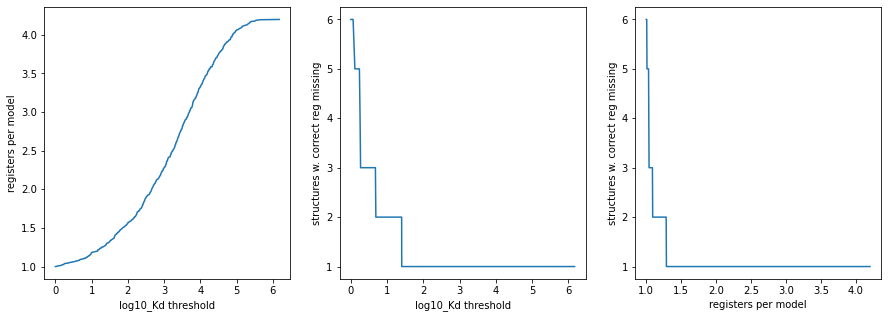

In [5]:
#make regerr plots for cl 1

def _subtract_mean(x):
    y=x['seqnn_logkds_all'].copy()
    y['logkd']=y['logkd']-x['seqnn_logkd']
    return y
def _pick_register(x,y,threshold):
    xx=np.stack(x['tail'])
    xx=x[(xx[:,0]==y[0])&(xx[:,1]==y[1])]
    if (len(xx)==0) or (xx[0]['logkd']>threshold):
        return 1    
    else:
        return 0

df=df_target[df_target['class']=='I']
kd_tuples=df.apply(_subtract_mean,axis=1)
kd_list=np.sort(np.unique([x for row in kd_tuples for x in row['logkd']]))

error_summary=[]
for threshold in kd_list:
    registers_kept=0
    errors_kept=0
    for x,y in zip(kd_tuples,df['tails']):
        registers_kept+=np.sum(x['logkd']<=threshold)        
        errors_kept+=_pick_register(x,y,threshold)
    error_summary.append([threshold,registers_kept/len(kd_tuples),errors_kept]) #threshold, reg/str, errors
error_summary=np.array(error_summary)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(error_summary[:,0],error_summary[:,1])
plt.xlabel('log10_Kd threshold')
plt.ylabel('registers per model')
plt.subplot(132)
plt.plot(error_summary[:,0],error_summary[:,2])
plt.xlabel('log10_Kd threshold')
plt.ylabel('structures w. correct reg missing')
plt.subplot(133)
plt.plot(error_summary[:,1],error_summary[:,2])
plt.xlabel('registers per model')
plt.ylabel('structures w. correct reg missing')
plt.show()

In [6]:
#register num distribution for cl 1
for threshold in [5,10,100]:
    print(f'threshold {threshold}:')
    regkept_list=[]
    for x,y in zip(kd_tuples,df['tails']):
        regkept_list.append(np.sum(x['logkd']<=np.log10(threshold)))
    print('total:',np.sum(regkept_list))
    utils.print_hist(regkept_list)
#conclusion: x10 might already be too liberal (seqnn regerr ~2 then, but 31 pmhcs with >1 reg)
#in terms of computational time, it's okay: ~1.2 reg/pmhc; but might lead to high regerr

threshold 5:
total: 295
1 253
2  11
3   4
4   2
threshold 10:
total: 318
1 240
2  20
3   4
4   4
5   2
threshold 100:
total: 422
1 199
2  32
3  15
4  13
5   5
6   5
7   1


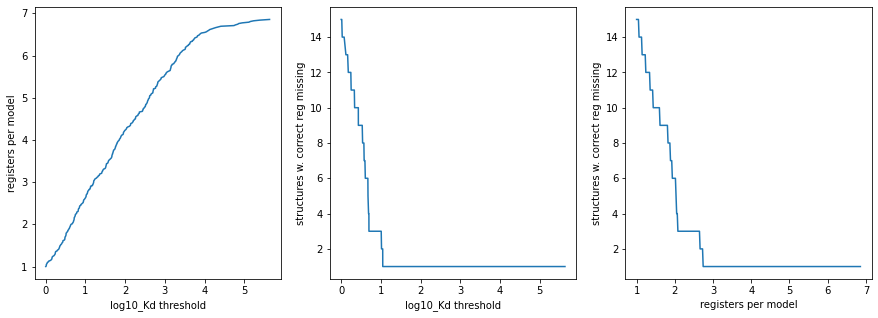

In [7]:
#make regerr plots for cl 2

def _subtract_mean(x):
    y=x['seqnn_logkds_all'].copy()
    y['logkd']=y['logkd']-x['seqnn_logkd']
    return y
def _pick_register(x,y,threshold):
    xx=np.stack(x['tail'])
    xx=x[(xx[:,0]==y[0])&(xx[:,1]==y[1])]
    if (len(xx)==0) or (xx[0]['logkd']>threshold):
        return 1    
    else:
        return 0

df=df_target[df_target['class']=='II']
kd_tuples=df.apply(_subtract_mean,axis=1)
kd_list=np.sort(np.unique([x for row in kd_tuples for x in row['logkd']]))

error_summary=[]
for threshold in kd_list:
    registers_kept=0
    errors_kept=0
    for x,y in zip(kd_tuples,df['tails']):
        registers_kept+=np.sum(x['logkd']<=threshold)        
        errors_kept+=_pick_register(x,y,threshold)
    error_summary.append([threshold,registers_kept/len(kd_tuples),errors_kept]) #threshold, reg/str, errors
error_summary=np.array(error_summary)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(error_summary[:,0],error_summary[:,1])
plt.xlabel('log10_Kd threshold')
plt.ylabel('registers per model')
plt.subplot(132)
plt.plot(error_summary[:,0],error_summary[:,2])
plt.xlabel('log10_Kd threshold')
plt.ylabel('structures w. correct reg missing')
plt.subplot(133)
plt.plot(error_summary[:,1],error_summary[:,2])
plt.xlabel('registers per model')
plt.ylabel('structures w. correct reg missing')
plt.show()

In [8]:
#register num distribution for cl 2
for threshold in [10,50,100]:
    print(f'threshold {threshold}:')
    regkept_list=[]
    for x,y in zip(kd_tuples,df['tails']):
        regkept_list.append(np.sum(x['logkd']<=np.log10(threshold)))
    print('total:',np.sum(regkept_list))
    utils.print_hist(regkept_list)
#~no errors w. x10 already, but better take a larger margin, since the dataset is so small: x100 would be safer (or x50?)

threshold 10:
total: 162
1  23
2  20
3   3
4   6
5   4
6   2
7   1
8   1
9   1
10  1
threshold 50:
total: 230
1  11
2  16
3   8
4   8
5   5
6   5
7   2
8   3
9   3
11  1
threshold 100:
total: 262
1   7
2  16
3   8
4   9
5   5
6   5
7   3
8   4
9   1
10  1
11  1
12  1
13  1


## make inputs, parse results

In [4]:
target_dir='/scratch/vmikhayl/pmhc_modeling/discovery_dataset'
target_dir_apollo='/scratch/lustre/vmikhayl/pmhc_modeling/discovery_dataset'

#format: target_dir/run_{run_n}

In [5]:
#get run number
run_n=-1
for x in os.listdir(target_dir):    
    run_n=max(run_n,int(x.split('_')[-1]))
run_n+=1
print(f'run num: {run_n}')

run num: 11


In [89]:
#params
params_I ={'templates_per_register':20,
           'pep_gap_penalty':1,
            'mhc_cutoff':20,  
            'score_cutoff':None,
            'kd_threshold':10., 
            'use_mhc_msa':False,
            'use_paired_msa':True,
            'tile_registers':False,
            'shuffle':False
           }
params_II={'templates_per_register':20,
           'pep_gap_penalty':1,
            'mhc_cutoff':25,
            'score_cutoff':None,
            'kd_threshold':100.,  
            'use_mhc_msa':False,
            'use_paired_msa':True, #now implemented!
            'tile_registers':False,
            'shuffle':False
           }
params={'I':params_I,'II':params_II}

In [90]:
#run seqnn
t0=time.time()
df_target=make_inputs.run_seqnn(df_target)
print('kd predicted for {:4d} pmhcs in {:5.1f} s'.format(len(df_target),time.time()-t0))

making Kd predictions for 270 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


making Kd predictions for 62 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


kd predicted for  332 pmhcs in  50.5 s


In [91]:
t0=time.time()
af_inputs=make_inputs.make_inputs(df_target,params=params,date_cutoff=date_cutoff,print_stats=True)
print('prepared {:4d} inputs in {:5.1f} s'.format(len(af_inputs),time.time()-t0))

class I:
pmhcs: 270; runs: 1320, runs per pmhc: av 4.9, max 25; registers per pmhc: av 1.2, max  5
class II:
pmhcs:  62; runs:  829, runs per pmhc: av 13.4, max 39; registers per pmhc: av 4.2, max 13
prepared 2149 inputs in  49.5 s


In [ ]:
#tpr 10, mhcscore None (old settings)
#3.5, 12.7

#ntempl 16, mhcscore 10
#I: 3.5, II: 9.0

#ntempl 16, mhcscore 15
#I:, 3.8 II: 9.5

#ntempl 16, mhcscore 20
#I:, 4.0 II: 10.0

#ntempl 16, mhcscore 25
#I:, 4.1 II: 12.2

#ntempl 16 (same 15), mhcscore None: 
#I: 4.7, II: 16.9 (same, since ntempl/4)

### FINAL CHOICE
#tpr 20,20; mhcscore 20,25  (cl1,cl2)
#4.9, 13.4

In [94]:
#verify template date cutoff and cluster separation
with open('./data/experimental_structures/processed_updated/summary.pckl','rb') as f:
    pdb_summary=pickle.load(f)
    
pdbs_target=set()
pdbs_template=set()
scores=[]
for x in af_inputs:
    pdbs_target.add(x['true_pdb'])
    for y in x['template_hits']:
        pdbs_template.add(y['name'])
        scores.append(1000-y['sum_probs'])
target_dates=[pdb_summary[x]['date'] for x in pdbs_target]
template_dates=[pdb_summary[x]['date'] for x in pdbs_template]
print('targets:')
print(min(target_dates),max(target_dates))
print('templates:')
print(min(template_dates),max(template_dates))

utils.print_hist(scores)

targets:
1992-08-11 2019-06-11
templates:
1992-08-11 2018-04-24
3     3
4    44
5   152
6   446
7   788
8   722
9   451
10  359
11  302
12  252
13  223
14  280
15  378
16  319
17  247
18  185
19  195
20  211
21  168
22  150
23  205
24  237
25  217
26  170
27  137
28   88
29  121
30   80
31   54
32   44
33   55
34   31
35   39
36   36
37   53
38   83
39  133
40  151
41  108
42   88
43   50
44   18
45    7
46   14
47   11
48   29
49   27
50    6
51    6
52    1
53    4
54    7
55   12
56    1
57    8
58    3
104   4
105   5
106   5
107   6


In [95]:
#split jobs

inputs=af_inputs
python_path='/data/vmikhayl/alphafold-multimer/alphafold/tfold_run_alphafold.py'
sh_path='./scripts/run_alphafold.sh'

n_tasks=8 #16
apollo=True
exclusive=False #True
gpu=True
qos='short'
time_per_input=35. #in seconds  #this is per structure, not per pmhc!
time_per_task=int(len(inputs)*time_per_input/(60*n_tasks))
max_run_time=int(time_per_task*1.5)
print('estimated time per task, min:',time_per_task)
print('max run time, min:',max_run_time)

ctarget_dir=target_dir+f'/run_{run_n}'
ctarget_dir_apollo=target_dir_apollo+f'/run_{run_n}'

input_dir =ctarget_dir+'/inputs'
log_dir   =ctarget_dir+'/logs'
output_dir=ctarget_dir+'/outputs'
if apollo:
    input_dir_server =ctarget_dir_apollo+'/inputs'
    log_dir_server   =ctarget_dir_apollo+'/logs'
    output_dir_server=ctarget_dir_apollo+'/outputs'
else:
    input_dir_server =input_dir
    log_dir_server   =log_dir
    output_dir_server=output_dir

#make dirs
for d in [input_dir,log_dir,output_dir]:
    os.makedirs(d,exist_ok=True)    
#save a copy of df_target
df_target.to_pickle(ctarget_dir+'/target_df.pckl')
#make input files
indices=utils.split_jobs(len(inputs),n_tasks)
n_tasks=len(indices)
max_inputs_per_task=-1
for i,job in enumerate(indices):
    c_inputs=[inputs[j] for j in job]        
    max_inputs_per_task=max(max_inputs_per_task,len(c_inputs))
    with open(input_dir+'/input_'+str(i)+'.pckl','wb') as f:
        pickle.dump(c_inputs,f)  
print('tasks: {}, max inputs per task: {}'.format(n_tasks,max_inputs_per_task))

#make .sh        
lines=[]
lines.append('#!/bin/bash')
lines.append('')
lines.append(f'#SBATCH --array=0-{n_tasks-1}')             #run an array of n_tasks tasks
lines.append(f'#SBATCH --output={log_dir_server}/output_%a.txt')  #here %a will evaluate to array task id
lines.append(f'#SBATCH --error={log_dir_server}/error_%a.txt')
lines.append(f'#SBATCH --ntasks=1')                        #each array element is one task
if exclusive:
    lines.append(f'#SBATCH --exclusive')                   #request exclusive use of node, e.g. for hhblits
if gpu:
    lines.append(f'#SBATCH --gpus=1')                      #one gpu per task will use one core
#elif not exclusive:
#    lines.append(f'#SBATCH --cpus-per-task=1')             #one cpu per task
lines.append(f'#SBATCH --qos={qos}')  
lines.append(f'#SBATCH --time={max_run_time}')             #maximal run time in minutes, same for each array task
lines.append('')
lines.append(f'input_file={input_dir_server}/input_$SLURM_ARRAY_TASK_ID.pckl')        
lines.append(f'srun python {python_path} --inputs $input_file --output_dir {output_dir_server}')

if not sh_path.startswith(('/','./')):
    sh_path='./'+sh_path
with open(sh_path,'w') as f:
    f.writelines('\n'.join(lines))
os.chmod(sh_path, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)      

estimated time per task, min: 156
max run time, min: 234
tasks: 8, max inputs per task: 269


In [ ]:
## SUBMITTED 8 JOBS w MAXRUNTIME 234 min on 10:37 2022-08-18 ##

In [5]:
#in case need to reset n_run
#run_n=11
#ctarget_dir=target_dir+f'/run_{run_n}'

In [6]:
#check results
print('check run_n:',run_n)
n=0
for x in os.listdir(ctarget_dir+'/outputs'):
    for y in os.listdir(ctarget_dir+'/outputs/'+x):
        if y.endswith('.pdb'):
            n+=1
print('structures produced:',n)
t=[]
for x in os.listdir(ctarget_dir+'/logs'):
    if x.startswith('output'):
        with open(ctarget_dir+'/logs/'+x) as f:
            s=f.read().split('\n')
        if len(s)>1:
            for line in s:
                if line.startswith('time per input:'):
                    t.append(float(line.split(':')[1]))
                    break            
print('times loaded for {} runs'.format(len(t)))
print('time per structure: mean {:4.1f} s, max {:4.1f} s'.format(np.mean(t),max(t)))
#note: on 16 jobs, time per structure was ~42s; on 8 jobs, down to 35, despite pep renumbering and rmsd added:
#still saving on startup time!

#1740->2320 from ntempl 10->15

check run_n: 11
structures produced: 2149
times loaded for 8 runs
time per structure: mean 28.1 s, max 29.6 s


In [7]:
#assemple result_df
result_parse_tools.parse_results(ctarget_dir,get_rmsd=True)

2149 outputs collected in  265.4 s


## analyze results

In [8]:
def _color_by_regerr(x):
    if not x['register_identified']:
        return 'not identified'
    elif x['tails']!=x['af_tails']:
        return 'incorrect'
    else:
        return 'correct'
def summarize_results(df_list,names_list):    
    df_list=[x.copy() for x in df_list]
    n_fail=[np.sum(~x['register_identified']) for x in df_list]
    n_regerr=[np.sum(x['register_identified']&(x['tails']!=x['af_tails'])) for x in df_list]
    #good_df_list=[x[(x['tails']==x['af_tails'])&(x['register_identified'])] for x in df_list]    
    good_df_list=df_list #median and mean for all
    for name, fail, regerr in zip(names_list,n_fail,n_regerr):
        print('{:10s}: fails: {:2d}, regerr: {:2d}'.format(name, fail, regerr))    
    print('median:')
    for name, df in zip(names_list,good_df_list):
        s=[]
        for k in ['pep_CA','pep_all','mhc_CA','mhc_all']:
            s.append('{:s}: {:4.2f}'.format(k,df[k].median()))
        print('{:10s}: '.format(name)+', '.join(s))
    print('mean:')
    for name, df in zip(names_list,good_df_list):
        s=[]
        for k in ['pep_CA','pep_all','mhc_CA','mhc_all']:
            s.append('{:s}: {:4.2f}'.format(k,df[k].mean()))
        print('{:10s}: '.format(name)+', '.join(s))       
    for name,df in zip(names_list,df_list):
        df['model selection']=[name]*len(df)    
    df=pd.concat(df_list)
    df['register']=df.apply(_color_by_regerr,axis=1)
    plt.figure()
    sns.boxplot(data=df,y='pep_CA',x='model selection',color='lightgray',fliersize=0)
    sns.stripplot(data=df,y='pep_CA',x='model selection',hue='register',marker='.')
    plt.show()
#hill_colors=['rosybrown','lightcoral','indianred','brown','maroon']
hill_colors=['lightgray','darkgray','dimgray','black']
def make_hill_plot(rmsds,scores,rmsd_bins,xticks=None,xlim=None,loc=None,return_frac=False): 
    rmsd_bins_ext=[0.]+rmsd_bins+[10000.]
    scores=np.array(scores)
    score_bins=np.sort(np.unique(scores))
    score_bins=[0.99*score_bins[0]]+list(score_bins)+[1.01*score_bins[-1]]    
    counts=[]
    for s in score_bins:        
        r=rmsds[scores<s]
        counts.append([np.sum((r>=rmsd_bins_ext[i])&(r<rmsd_bins_ext[i+1])) for i in range(len(rmsd_bins_ext)-1)])
    counts=np.stack(counts).T/len(rmsds) #fractions, (n_groups,n_score_thresholds)
    counts_at_half=counts[:,np.sum(counts,axis=0)>0.5][:,0]
    if return_frac:
        return counts_at_half
    print(counts_at_half) #fractions for threshold when half models pass
    plt.figure()
    plt.stackplot(np.log(score_bins),counts,colors=hill_colors[:len(rmsd_bins)+1])            
    if not (xlim is None):
        plt.xlim(np.log(xlim))
        if not (xticks is None):
            xticks=xticks[(xticks>=xlim[0])&(xticks<=xlim[1])]
    if not (xticks is None):
        plt.xticks(np.log(xticks),xticks)
    loc=loc or 'lower right'
    plt.legend([f'<{r}' for r in rmsd_bins]+[f'>{rmsd_bins[-1]}'],loc=loc)
    plt.axhline(0.5)
    plt.show()

In [16]:
#run_n=10
#ctarget_dir=target_dir+f'/run_{run_n}'

In [9]:
print(ctarget_dir) #check this!
result_df=pd.read_pickle(ctarget_dir+'/result_df.pckl')

print(len(result_df))
print(result_df.columns)

/scratch/vmikhayl/pmhc_modeling/discovery_dataset/run_11
2149
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'cluster_seq', 'pdb_id',
       'date', 'tails', 'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b',
       'exclude_pdbs', 'tails_prefiltered', 'af_n_reg', 'seqnn_logkd'],
      dtype='object')


2149
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'cluster_seq', 'pdb_id',
       'date', 'tails', 'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b',
       'exclude_pdbs', 'tails_prefiltered', 'af_n_reg', 'seqnn_logkd'],
      dtype='object')
332 20
I
no regerr with linker: 2 without linker 266
regerr with linker: 0 without linker 2
best lddt : fails:  0, regerr:  2
best rmsd : fails:  0, regerr:  2
median:
best lddt : pep_CA: 0.73, pep_all: 1.55, mhc_CA: 0.45, mhc_all: 1.13
best rmsd : pep_CA: 0.64, pep_all: 1.41, mhc_CA: 0.45, mhc_all: 1.13
mean:
best lddt : pep_CA: 1.00, pep_all: 1.83, mhc_CA: 0.53, mhc_all: 1.19
best rmsd : pep_CA: 0.86, pep_all: 1.65, mhc_CA: 0.52, mhc_all: 1.19


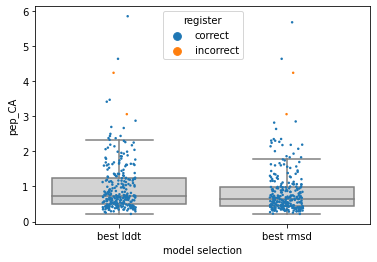

[0.41481481 0.06666667 0.01851852 0.0037037 ]


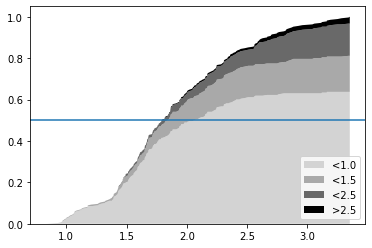

II
no regerr with linker: 18 without linker 43
regerr with linker: 0 without linker 1
best lddt : fails:  0, regerr:  1
best rmsd : fails:  0, regerr:  0
median:
best lddt : pep_CA: 0.46, pep_all: 1.18, mhc_CA: 0.44, mhc_all: 1.09
best rmsd : pep_CA: 0.44, pep_all: 1.17, mhc_CA: 0.44, mhc_all: 1.11
mean:
best lddt : pep_CA: 0.65, pep_all: 1.35, mhc_CA: 0.47, mhc_all: 1.12
best rmsd : pep_CA: 0.52, pep_all: 1.22, mhc_CA: 0.48, mhc_all: 1.14


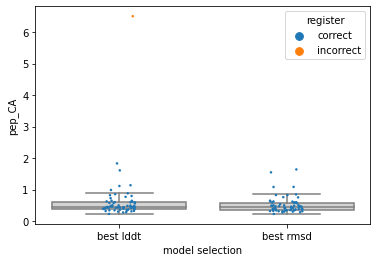

[0.46774194 0.03225806 0.01612903 0.        ]


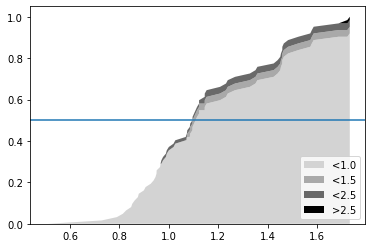

In [10]:
result_df=pd.read_pickle(ctarget_dir+'/result_df.pckl')
print(len(result_df))
print(result_df.columns)

# reduce to n models per register -- DISABLE!!!
if False:
    n=2
    def reduce_to_top_models(df,n):
        return df[df['model_id'].isin(np.sort(df['model_id'])[:2])]
    print(f'REDUCED TO {n} MODELS PER REGISTER')
    result_df=result_df.groupby(['pmhc_id','tpl_tails']).apply(lambda x:reduce_to_top_models(x,1)).reset_index(drop=True)
    print('models per reg:')
    print(result_df.groupby(['pmhc_id','tpl_tails']).apply(len).value_counts().sort_index())

#add linker info
pmhc_ids=result_df['pmhc_id'].unique()
linker_list=[]
for pmhc_id in pmhc_ids:
    pmhc=pmhcs[pmhc_id]
    pdb_ids=[x[0] for x in pmhc['pdbs']]
    linker=False
    for pdb_id in pdb_ids:
        c_linker=np.any(summary[pdb_id]['P']['info']['linker'])
        linker=linker or c_linker
    linker_list.append(linker)
linker_list=pd.Series(linker_list,index=pmhc_ids,name='linker')
print(len(linker_list),np.sum(linker_list.values))
result_df=result_df.merge(linker_list,left_on='pmhc_id',right_index=True)

#add score
result_df['score']=100-result_df['pep_lddt'].map(result_parse_tools.mean_pep_lddt)
#MAKE compute_scores in result parse tools; add smth like 10*(reg not assigned)!!

for cl in ['I','II']:
    print(cl)
    df0=result_df[result_df['class']==cl].copy()
    df_lddt=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'score',how='min')
    df_lddt=df_lddt.reset_index(drop=True)
    #regerr by linker
    x_good=df_lddt[df_lddt['tails']==df_lddt['af_tails']]['linker']
    print('no regerr with linker:',np.sum(x_good),'without linker',len(x_good)-np.sum(x_good))
    x_bad=df_lddt[df_lddt['tails']!=df_lddt['af_tails']]['linker']
    print('regerr with linker:',np.sum(x_bad),'without linker',len(x_bad)-np.sum(x_bad))
          
    df_rmsd=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'pep_CA',how='min')
    df_rmsd=df_rmsd.reset_index(drop=True)    
    summarize_results([df_lddt,df_rmsd],['best lddt','best rmsd'])
    make_hill_plot(df_lddt['pep_CA'],df_lddt['score'],[1.,1.5,2.5])#,xticks=None,xlim=None,loc=None)    

In [45]:
df_lddt[df_lddt['tails']!=df_lddt['af_tails']][['tails','tpl_tails','af_tails','netmhc_tails','register_identified','best_mhc_score','best_score','pep']] #216,510,754,755

,tails,tpl_tails,af_tails,netmhc_tails,register_identified,best_mhc_score,best_score,pep
17,"(1, 3)","(3, 1)","(3, 1)","(3, 1)",True,0,7,QPFPQPELPYPGS
52,"(2, 3)","(4, 1)","(3, 2)","(4, 0)",True,0,16,LVEALYLVCGERGG
53,"(2, 3)","(0, 5)","(-1, 6)","(2, 3)",True,0,16,FSWGAEGQRPGFGS
59,"(3, 4)","(2, 5)","(2, 5)","(5, 2)",True,1,8,GVEELYLVAGEEGCGG


In [36]:
#add linker info
pmhc_ids=result_df['pmhc_id'].unique()
linker_list=[]
for pmhc_id in pmhc_ids:
    pmhc=pmhcs[pmhc_id]
    pdb_ids=[x[0] for x in pmhc['pdbs']]
    linker=False
    for pdb_id in pdb_ids:
        c_linker=np.any(summary[pdb_id]['P']['info']['linker'])
        linker=linker or c_linker
    linker_list.append(linker)
linker_list=pd.Series(linker_list,index=pmhc_ids,name='linker')
print(len(linker_list),np.sum(linker_list.values))

result_df=result_df.merge(linker_list,left_on='pmhc_id',right_index=True)

332 20


In [17]:
#why netmhc tails don't sum to same as tails??? FIXED!
df_lddt[df_lddt['netmhc_tails'].map(sum)!=df_lddt['tails'].map(sum)]

,pmhc_id,model_id,tpl_tails,best_score,best_mhc_score,register_identified,af_tails,pep_lddt,mhc_lddt,pep_CA,...,netmhc_tails,netmhc_kd,pep,mhc_a,mhc_b,exclude_pdbs,tails_prefiltered,af_n_reg,seqnn_logkd,score
0,17,12,"(9, 3)",14,0,True,"(9, 3)","[[P 01, 31.628613840808605], [P 02, 36.439...","[[M 61 , 94.40297284929147], [M 70 , 98.4048...",0.319499,...,"(9, 0)",4236.554261,GSHSRGLKKMREIIGWPGGSG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f1f...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f1f...,[3cup],"[(1, 11), (3, 9), (6, 6), (8, 4), (9, 3), (10,...",7,3.655637,2.668535
13,156,11,"(3, 4)",40,23,True,"(3, 4)","[[P 07, 63.72605000483963], [P 08, 84.5086...","[[M 61 , 93.45296754980119], [M 70 , 98.4967...",0.971355,...,"(3, 0)",14044.412723,GNSHRGAIEWEGIESG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f1f...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f1f...,"[1jl4, 1d9k]","[(0, 7), (1, 6), (2, 5), (3, 4), (4, 3), (5, 2...",8,4.810491,2.920273
30,416,12,"(4, 3)",14,1,True,"(4, 3)","[[P 06, 62.02629487571175], [P 07, 77.1808...","[[M 61 , 94.88189166031398], [M 70 , 98.4027...",0.328811,...,"(5, 0)",4369.087483,HLVERLYLVCGEEGAG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f1f...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f1f...,"[6blr, 6dfs]","[(0, 7), (1, 6), (2, 5), (3, 4), (4, 3), (5, 2...",7,4.878678,3.390267
46,625,5,"(2, 2)",10,7,True,"(2, 2)","[[P 08, 91.53077003827639], [P 09, 97.4156...","[[M 61 , 97.9833039055586], [M 70 , 98.54432...",0.283094,...,"(1, 0)",179.796801,RFYKTLRAEQASQ,<tfold.utils.seq_tools.NUMSEQ object at 0x7f1f...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f1f...,"[6cql, 6cpn, 6cqn]","[(1, 3), (2, 2)]",3,2.326435,2.050263
50,705,0,"(2, 3)",13,0,True,"(2, 3)","[[P 08, 87.3963373816732], [P 09, 95.24165...","[[M 61 , 97.82573125505836], [M 70 , 97.9361...",0.829891,...,"(2, 0)",596.965761,AGFKGEQGPKGEPG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f1f...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f1f...,[2fse],"[(2, 3)]",1,2.120560,3.199393
52,754,2,"(4, 1)",16,0,True,"(3, 2)","[[P 07, 76.50056508828129], [P 08, 86.5387...","[[M 61 , 95.33066458962712], [M 70 , 97.5861...",3.798554,...,"(4, 0)",1067.201729,LVEALYLVCGERGG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f1f...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f1f...,[1jk8],"[(2, 3), (4, 1)]",2,4.428096,5.779937


In [60]:
print(df_lddt['best_mhc_score'].value_counts())
print(df_lddt[df_lddt['tails']!=df_lddt['af_tails']]['best_mhc_score'].value_counts())

0     35
1      8
10     5
15     3
8      2
11     2
2      1
3      1
23     1
9      1
18     1
14     1
7      1
Name: best_mhc_score, dtype: int64
0    3
1    1
Name: best_mhc_score, dtype: int64


In [20]:
pmhcs_df=pd.read_pickle(source_dir+'/pmhcs_df.pckl')
pmhcs_df=pmhcs_df[pmhcs_df['class']=='II'] #focus on cl II
print(len(pmhcs_df))
print(pmhcs_df.columns)

129
Index(['id', 'class', 'cluster_seq', 'cluster_CA', 'date', 'pep', 'tails',
       'linker', 'mhc_a_allele', 'mhc_b_allele', 'netmhc_core', 'netmhc_kd',
       'netmhc_tails'],
      dtype='object')


In [21]:
pmhcs_df[pmhcs_df['netmhc_tails'].map(sum)!=pmhcs_df['tails'].map(sum)]

,id,class,cluster_seq,cluster_CA,date,pep,tails,linker,mhc_a_allele,mhc_b_allele,netmhc_core,netmhc_kd,netmhc_tails
0,17,II,17,398,2008-04-16,GSHSRGLKKMREIIGWPGGSG,"(9, 3)",True,"(10090, IAA, d)","(10090, IAB, g7)",---------MREIIGWP---G,4236.554261,"(9, 0)"
11,84,II,78,409,2021-10-04,LQPFPQPELPYGSGGS,"(2, 5)",False,"(9606, DQA1, 05:01)","(9606, DQB1, 02:01)",----PQPELPY---GS,407.707145,"(4, 0)"
21,156,II,130,417,1999-10-28,GNSHRGAIEWEGIESG,"(3, 4)",False,"(10090, IAA, k)","(10090, IAB, k)",---HRGAIEWE----G,14044.412723,"(3, 0)"
44,351,II,242,434,2018-08-13,ARRPPLAELAALNLSGSRL,"(5, 5)",False,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)",-----LAELAALN-----L,75.151370,"(5, 0)"
49,370,II,118,415,2010-10-23,KPVSKMRMATPLLMQALPM,"(5, 5)",False,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)",-----MRMATPLL-----M,8.258579,"(5, 0)"
52,416,II,275,439,2017-11-11,HLVERLYLVCGEEGAG,"(4, 3)",True,"(10090, IAA, d)","(10090, IAB, g7)",-----LYLVCGEE--G,4369.087483,"(5, 0)"
53,420,II,118,415,2010-11-01,KMRMATPLLMQALPM,"(1, 5)",False,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)",-MRMATPLL-----M,8.284264,"(1, 0)"
68,512,II,320,452,2013-08-22,GVYATXSSAVRLR,"(2, 2)",False,"(9606, DRA, 01:01)","(9606, DRB1, 04:01)",--YATXSSAV--R,1462.195164,"(2, 0)"
87,625,II,374,464,2018-03-13,RFYKTLRAEQASQ,"(2, 2)",False,"(9606, DRA, 01:01)","(9606, DRB1, 11:01)",-FYKTLRAE---Q,179.796801,"(1, 0)"
95,661,II,118,415,2014-12-06,KPVSKWRMATPLLMQALPM,"(5, 5)",False,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)",-----WRMATPLL-----M,7.284458,"(5, 0)"


In [28]:
x=df_target[df_target['class']=='II']
print(len(x))
print(np.sum(x['tails']!=x['netmhc_tails']))
print(np.sum(x['tails'].map(lambda y:y[0])!=x['netmhc_tails'].map(lambda y:y[0])))
#NETMHC REGERR IS 16!
x.columns

62
19
16


Index(['class', 'cluster_seq', 'pdb_id', 'pmhc_id', 'date', 'tails',
       'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b', 'exclude_pdbs'],
      dtype='object')

In [32]:
y=nn_predict.predict(x,'II',mhc_as_obj=True)

making Kd predictions for 62 pmhcs...


2022-08-19 23:51:49.252481: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [34]:
print(np.sum(y['tails']!=y['seqnn_tails']))
print(np.sum(y['tails'].map(lambda z:z[0])!=y['seqnn_tails'].map(lambda z:z[0])))

#OKAY: seqnn is still better, but netmhc is not as bad!
#check the same on test set


#LESSON: keep netmhc cores and inspect them in all cases identified as regerr!!!

15
15


In [312]:
max(df_lddt['score'])#why dont see??? because log scale and ticks!

5.902302887605458

### cl I

In [210]:
df=result_df[result_df['class']=='I']

best_lddt : fails:  0, regerr:  2
best_rmsd : fails:  0, regerr:  2
median:
best_lddt : pep_CA: 0.72, pep_all: 1.51, mhc_CA: 0.47, mhc_all: 1.13
best_rmsd : pep_CA: 0.65, pep_all: 1.42, mhc_CA: 0.45, mhc_all: 1.13
mean:
best_lddt : pep_CA: 0.99, pep_all: 1.81, mhc_CA: 0.54, mhc_all: 1.21
best_rmsd : pep_CA: 0.86, pep_all: 1.66, mhc_CA: 0.54, mhc_all: 1.20


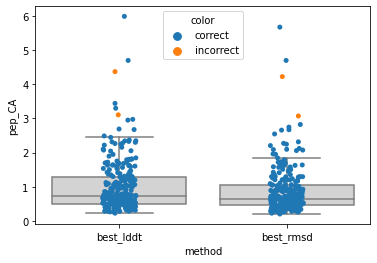

In [211]:
def _mean_pep_lddt(x):
    '''mean over core'''
    reskeep=['P{:4d} '.format(i) for i in range(1,10)]+['P   5{:1d}'.format(i) for i in range(1,10)]             
    return np.mean(x['lddt'][np.isin(x['pdbnum'],reskeep)])

#reduce by lddt
df1=df.copy()
df1['score']=df1['pep_lddt'].map(lambda x: _mean_pep_lddt(x))
df1=result_parse_tools.reduce_to_best(df1,['pmhc_id'],'score',how='max')
df1=df1.reset_index(drop=True)
#reduce to best
df2=df.copy()
df2=result_parse_tools.reduce_to_best(df2,['pmhc_id'],'pep_CA',how='min')
df2=df2.reset_index(drop=True)
summarize_results([df1,df2],['best_lddt','best_rmsd'])

### cl II

In [212]:
df=result_df[result_df['class']=='II']

best_lddt : fails:  0, regerr:  3
best_rmsd : fails:  0, regerr:  0
median:
best_lddt : pep_CA: 0.46, pep_all: 1.14, mhc_CA: 0.44, mhc_all: 1.15
best_rmsd : pep_CA: 0.41, pep_all: 1.16, mhc_CA: 0.45, mhc_all: 1.15
mean:
best_lddt : pep_CA: 0.55, pep_all: 1.27, mhc_CA: 0.51, mhc_all: 1.20
best_rmsd : pep_CA: 0.50, pep_all: 1.25, mhc_CA: 0.50, mhc_all: 1.19


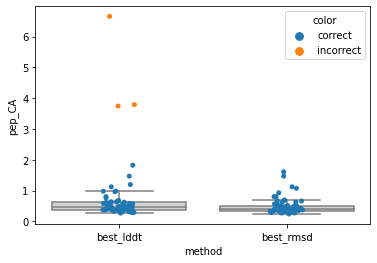

In [213]:
def _mean_pep_lddt(x):
    '''mean over core'''
    reskeep=['P{:4d} '.format(i) for i in range(1,10)]+['P   5{:1d}'.format(i) for i in range(1,10)]             
    return np.mean(x['lddt'][np.isin(x['pdbnum'],reskeep)])

#reduce by lddt
df1=df.copy()
df1['score']=df1['pep_lddt'].map(lambda x: _mean_pep_lddt(x))
df1=result_parse_tools.reduce_to_best(df1,['pmhc_id'],'score',how='max')
df1=df1.reset_index(drop=True)
#reduce to best
df2=df.copy()
df2=result_parse_tools.reduce_to_best(df2,['pmhc_id'],'pep_CA',how='min')
df2=df2.reset_index(drop=True)
summarize_results([df1,df2],['best_lddt','best_rmsd'])

In [ ]:
#monitor mhc rmsd metric; expect to see deviations for large mhc score

### linear models

Create linear predictors to improve model scoring with two goals:
- improve model selection:
 - better regerr
 - for given regerr, better rmsd
- improved accuracy prediction. E.g., maximize fraction of good models when threshold by the score so that half of all pmhcs are kept

Never seen improvement on the first objective, for cl 1 or cl 2. With all my scores, regerr only grows or stays the same, with no substantial improvement in rmsd. Something like Simpson's paradox may be at play: training on all models, then selecting within groups. Structure regression differently? Fit ranks? Mixed/multilevel models? 

Tested by manually reweighting P_left, P_middle, P_right in cl 1 models: no substantial improvement!

For the second objective, also no improvement. For cl 2, lddt is actually quite a bit better than regression

Tested features P_i, P, M (mean_mhc_lddt), len, corelen, seqnn_logkd, n_reg, reg_identified, ... No improvement over mean pep lddt, really

Conclusion: just use mean pep lddt

In [214]:
from sklearn.linear_model import Ridge, RidgeCV, LogisticRegression

#function for plotting
hill_colors=['rosybrown','lightcoral','indianred','brown','maroon']
def make_hill_plot(rmsds,scores,rmsd_bins,xticks=None,xlim=None,loc=None,return_frac=False): 
    rmsd_bins_ext=[0.]+rmsd_bins+[10000.]
    scores=np.array(scores)
    score_bins=np.sort(np.unique(scores))
    score_bins=[0.99*score_bins[0]]+list(score_bins)+[1.01*score_bins[-1]]    
    counts=[]
    for s in score_bins:        
        r=rmsds[scores<s]
        counts.append([np.sum((r>=rmsd_bins_ext[i])&(r<rmsd_bins_ext[i+1])) for i in range(len(rmsd_bins_ext)-1)])
    counts=np.stack(counts).T/len(rmsds) #fractions, (n_groups,n_score_thresholds)
    counts_at_half=counts[:,np.sum(counts,axis=0)>0.5][:,0]
    if return_frac:
        return counts_at_half
    print(counts_at_half) #fractions for threshold when half models pass
    plt.figure()
    plt.stackplot(np.log(score_bins),counts,colors=hill_colors[:len(rmsd_bins)+1])            
    if not (xlim is None):
        plt.xlim(np.log(xlim))
        if not (xticks is None):
            xticks=xticks[(xticks>=xlim[0])&(xticks<=xlim[1])]
    if not (xticks is None):
        plt.xticks(np.log(xticks),xticks)
    loc=loc or 'lower right'
    plt.legend([f'<{r}' for r in rmsd_bins]+[f'>{rmsd_bins[-1]}'],loc=loc)
    plt.axhline(0.5)
    plt.show()

In [216]:
#get features

features_all=pd.DataFrame(list(result_df.apply(lambda x: result_parse_tools._get_features1(x),axis=1).values))
print(len(features_all))
print(features_all.columns)

1740
Index(['len', 'mhc_score', 'n_reg', 'seqnn_logkd', 'register_identified',
       'mean_mhc_lddt', 'mean_pep_lddt', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9'],
      dtype='object')


#### cl I

Index(['len', 'P', 'M'], dtype='object')


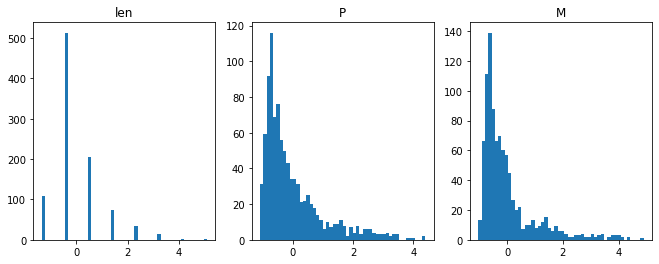

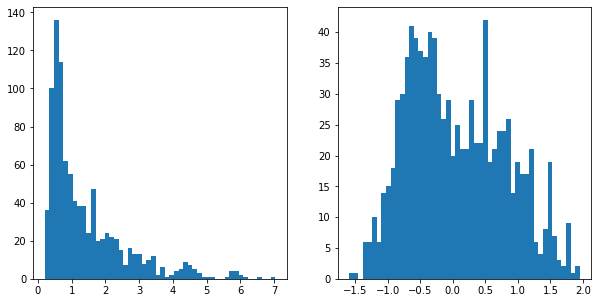

In [234]:
cl='I'

#prepare features
df=result_df[result_df['class']==cl]
features=features_all[result_df['class']==cl].copy()
def _log(x):
    return x
features['P_left']=_log(features[['P1','P2','P3']].mean(axis=1))
features['P_middle']=_log(features[['P4','P5','P6']].mean(axis=1))
features['P_right']=_log(features[['P7','P8','P9']].mean(axis=1))
features['P']=features['mean_pep_lddt']
features['M']=features['mean_mhc_lddt']
#for k in ['P_left','P_middle','P_right','P']:
#    features[f'len_x_{k}']=features['len']*features[k]
    
#choose subset    
features=features[['len',#'n_reg',
                   #'mhc_score',  #REMOVE
                   #'P_left','P_middle','P_right', #REMOVE
                   #'len_x_P_left','len_x_P_middle','len_x_P_right',
                   'P', #,'len_x_P'  
                   'M'
                  ]]
print(features.columns)

#normalize
x=features.values
m=np.mean(x,axis=0)
std=np.std(x,axis=0)
features=(features-m)/std

#plot features and rmsd    
if True: 
    l=len(features.columns)
    nx=4
    ny=l//nx+int(l%nx>0)
    plt.figure(figsize=(15,4*ny))
    for i,k in enumerate(features.columns):
        plt.subplot(ny,nx,i+1)
        plt.hist(features[k],bins=50)
        plt.title(k)
    plt.show()
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.hist(df['pep_CA'],bins=50)
    plt.subplot(122)
    plt.hist(np.log(df['pep_CA']),bins=50)
    plt.show()

iteration 0
3.1622776601683795
[0.01812752 0.36011177 0.07165918]
lddt      : fails:  0, regerr:  2
score     : fails:  0, regerr:  2
median:
lddt      : pep_CA: 0.72, pep_all: 1.49, mhc_CA: 0.47, mhc_all: 1.12
score     : pep_CA: 0.72, pep_all: 1.49, mhc_CA: 0.47, mhc_all: 1.12
mean:
lddt      : pep_CA: 1.01, pep_all: 1.83, mhc_CA: 0.54, mhc_all: 1.21
score     : pep_CA: 1.01, pep_all: 1.83, mhc_CA: 0.54, mhc_all: 1.21


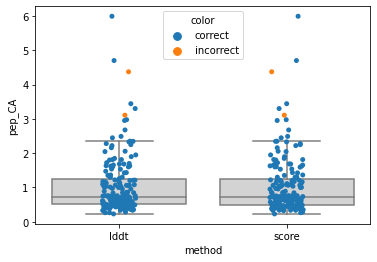

[0.4021164  0.06878307 0.02645503 0.00529101]
[0.4021164  0.06878307 0.03174603 0.        ]
[0.4021164  0.06878307 0.03174603 0.        ]
iteration 1
38.31186849557285
[0.13590976 0.24789381 0.17072899]
lddt      : fails:  0, regerr:  1
score     : fails:  0, regerr:  1
median:
lddt      : pep_CA: 0.73, pep_all: 1.51, mhc_CA: 0.47, mhc_all: 1.13
score     : pep_CA: 0.73, pep_all: 1.52, mhc_CA: 0.44, mhc_all: 1.13
mean:
lddt      : pep_CA: 1.00, pep_all: 1.81, mhc_CA: 0.53, mhc_all: 1.20
score     : pep_CA: 1.00, pep_all: 1.82, mhc_CA: 0.52, mhc_all: 1.19


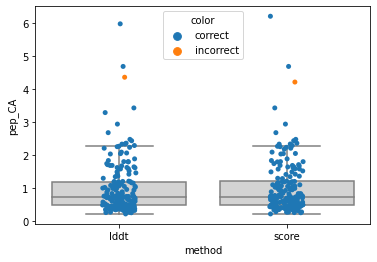

[0.40740741 0.06349206 0.02645503 0.00529101]
[0.4021164  0.07407407 0.02645503 0.        ]
[0.40740741 0.06878307 0.02645503 0.        ]
iteration 2
3.1622776601683795
[0.27109544 0.23946295 0.26005093]
lddt      : fails:  0, regerr:  1
score     : fails:  0, regerr:  1
median:
lddt      : pep_CA: 0.75, pep_all: 1.56, mhc_CA: 0.47, mhc_all: 1.14
score     : pep_CA: 0.75, pep_all: 1.57, mhc_CA: 0.47, mhc_all: 1.14
mean:
lddt      : pep_CA: 1.01, pep_all: 1.86, mhc_CA: 0.55, mhc_all: 1.21
score     : pep_CA: 1.01, pep_all: 1.86, mhc_CA: 0.54, mhc_all: 1.21


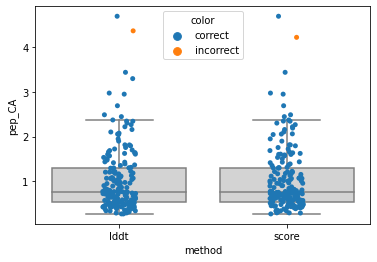

[0.40740741 0.07407407 0.02116402 0.        ]
[0.3968254  0.08465608 0.02116402 0.        ]
[0.39153439 0.08994709 0.02116402 0.        ]
iteration 3
3.1622776601683795
[0.13300035 0.35150132 0.02307674]
lddt      : fails:  0, regerr:  1
score     : fails:  0, regerr:  1
median:
lddt      : pep_CA: 0.72, pep_all: 1.49, mhc_CA: 0.47, mhc_all: 1.13
score     : pep_CA: 0.72, pep_all: 1.49, mhc_CA: 0.47, mhc_all: 1.13
mean:
lddt      : pep_CA: 1.02, pep_all: 1.86, mhc_CA: 0.55, mhc_all: 1.22
score     : pep_CA: 1.02, pep_all: 1.86, mhc_CA: 0.55, mhc_all: 1.22


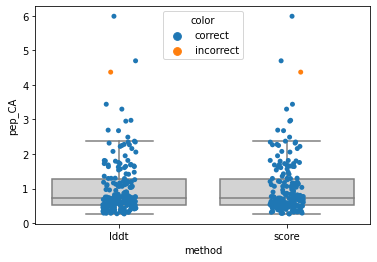

[0.41269841 0.05820106 0.02645503 0.00529101]
[0.40740741 0.06878307 0.02645503 0.        ]
[0.40740741 0.06878307 0.02645503 0.        ]
iteration 4
0.2610157215682533
[ 0.1335788   0.47212808 -0.0089823 ]
lddt      : fails:  0, regerr:  2
score     : fails:  0, regerr:  2
median:
lddt      : pep_CA: 0.75, pep_all: 1.55, mhc_CA: 0.45, mhc_all: 1.12
score     : pep_CA: 0.75, pep_all: 1.55, mhc_CA: 0.45, mhc_all: 1.12
mean:
lddt      : pep_CA: 1.02, pep_all: 1.87, mhc_CA: 0.54, mhc_all: 1.20
score     : pep_CA: 1.02, pep_all: 1.87, mhc_CA: 0.54, mhc_all: 1.20


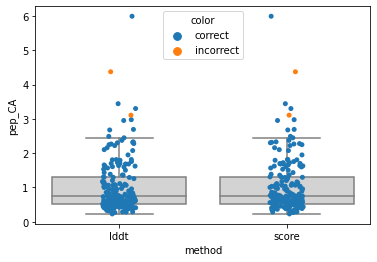

[0.40740741 0.06349206 0.02645503 0.00529101]
[0.41269841 0.06349206 0.02645503 0.        ]
[0.41269841 0.06349206 0.02645503 0.        ]
iteration 5
3.1622776601683795
[ 0.14674695  0.44381212 -0.09270451]
lddt      : fails:  0, regerr:  2
score     : fails:  0, regerr:  2
median:
lddt      : pep_CA: 0.72, pep_all: 1.48, mhc_CA: 0.48, mhc_all: 1.15
score     : pep_CA: 0.72, pep_all: 1.49, mhc_CA: 0.48, mhc_all: 1.16
mean:
lddt      : pep_CA: 0.98, pep_all: 1.79, mhc_CA: 0.57, mhc_all: 1.23
score     : pep_CA: 0.99, pep_all: 1.81, mhc_CA: 0.57, mhc_all: 1.24


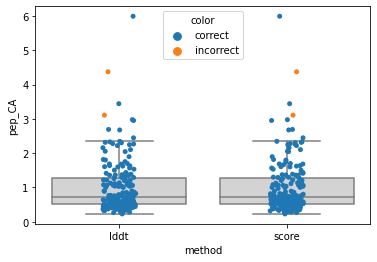

[0.4021164  0.07407407 0.02116402 0.00529101]
[0.39153439 0.08465608 0.02645503 0.        ]
[0.39153439 0.08465608 0.02645503 0.        ]
iteration 6
3.1622776601683795
[ 0.08129385  0.45438213 -0.15590098]
lddt      : fails:  0, regerr:  2
score     : fails:  0, regerr:  2
median:
lddt      : pep_CA: 0.71, pep_all: 1.51, mhc_CA: 0.44, mhc_all: 1.12
score     : pep_CA: 0.71, pep_all: 1.52, mhc_CA: 0.47, mhc_all: 1.14
mean:
lddt      : pep_CA: 0.97, pep_all: 1.77, mhc_CA: 0.55, mhc_all: 1.22
score     : pep_CA: 0.97, pep_all: 1.78, mhc_CA: 0.56, mhc_all: 1.24


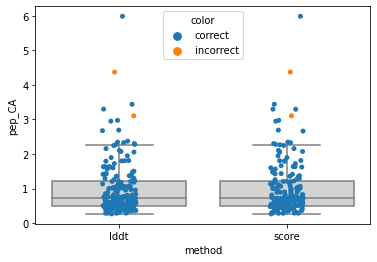

[0.40740741 0.06878307 0.02116402 0.00529101]
[0.39153439 0.08465608 0.02645503 0.        ]
[0.3968254  0.07936508 0.02645503 0.        ]
iteration 7
0.2610157215682533
[ 0.02404058  0.56215103 -0.02479425]
lddt      : fails:  0, regerr:  2
score     : fails:  0, regerr:  2
median:
lddt      : pep_CA: 0.72, pep_all: 1.49, mhc_CA: 0.47, mhc_all: 1.14
score     : pep_CA: 0.72, pep_all: 1.51, mhc_CA: 0.47, mhc_all: 1.14
mean:
lddt      : pep_CA: 0.98, pep_all: 1.81, mhc_CA: 0.55, mhc_all: 1.21
score     : pep_CA: 0.98, pep_all: 1.81, mhc_CA: 0.55, mhc_all: 1.21


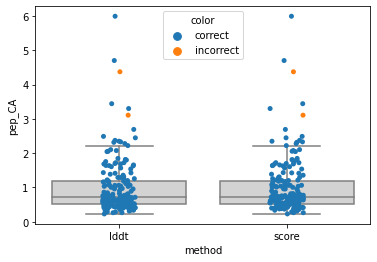

[0.4021164  0.06878307 0.02645503 0.00529101]
[0.40740741 0.06878307 0.02645503 0.        ]
[0.40740741 0.06878307 0.02645503 0.        ]
iteration 8
3.1622776601683795
[0.14984221 0.31853146 0.02524033]
lddt      : fails:  0, regerr:  2
score     : fails:  0, regerr:  2
median:
lddt      : pep_CA: 0.73, pep_all: 1.52, mhc_CA: 0.47, mhc_all: 1.13
score     : pep_CA: 0.73, pep_all: 1.52, mhc_CA: 0.47, mhc_all: 1.13
mean:
lddt      : pep_CA: 1.00, pep_all: 1.85, mhc_CA: 0.56, mhc_all: 1.22
score     : pep_CA: 1.00, pep_all: 1.85, mhc_CA: 0.56, mhc_all: 1.22


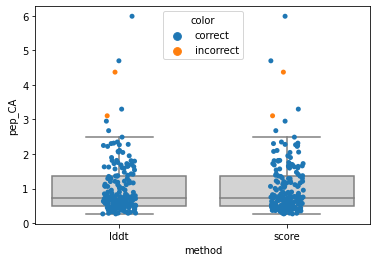

[0.4021164  0.06878307 0.02645503 0.00529101]
[0.3968254  0.07407407 0.03174603 0.        ]
[0.3968254  0.07407407 0.03174603 0.        ]
iteration 9
3.1622776601683795
[ 0.02186916  0.39822569 -0.01401863]
lddt      : fails:  0, regerr:  1
score     : fails:  0, regerr:  1
median:
lddt      : pep_CA: 0.71, pep_all: 1.48, mhc_CA: 0.45, mhc_all: 1.12
score     : pep_CA: 0.71, pep_all: 1.48, mhc_CA: 0.45, mhc_all: 1.12
mean:
lddt      : pep_CA: 0.97, pep_all: 1.78, mhc_CA: 0.54, mhc_all: 1.21
score     : pep_CA: 0.97, pep_all: 1.78, mhc_CA: 0.54, mhc_all: 1.21


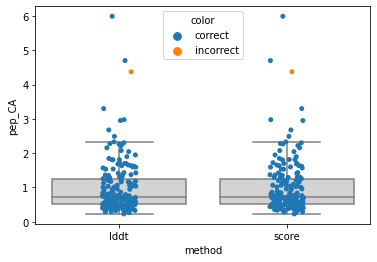

[0.41269841 0.06349206 0.02116402 0.00529101]
[0.41269841 0.06878307 0.02116402 0.        ]
[0.41269841 0.06878307 0.02116402 0.        ]


In [233]:
##cross-validation by repeated subsampling

train_fraction=0.6
N_tests=10

pmhc_ids=df['pmhc_id'].unique()
n=int(len(pmhc_ids)*test_fraction)
for i in range(N_tests):
    print(f'iteration {i}')    
    pmhc_ids=np.random.permutation(pmhc_ids)    
    pmhc_ids_train,pmhc_ids_test=pmhc_ids[:n],pmhc_ids[n:]
    df_train=df[df['pmhc_id'].isin(pmhc_ids_train)].copy()
    df_test=df[df['pmhc_id'].isin(pmhc_ids_test)].copy()
    features_train=features.loc[df_train.index]
    features_test=features.loc[df_test.index]    

    #choose alpha, train
    reg=RidgeCV(alphas=np.logspace(-6, 7, 13))#,positive=True)
    #reg=Ridge(alpha=100.)
    x=features_train.values
    y_true=df_train['pep_CA'].values
    y_true=0.8+y_true*(y_true>0.8) #don't care to distinguish values below 0.8
    reg.fit(x,np.log(y_true))
    alpha=reg.alpha_
    print(reg.alpha_)
    print(reg.coef_)
    
    df_test['regression_score']=reg.predict(features_test.values)  
    df_test['mean_pep_lddt']=features_test['P'] #note: it's 100-lddt
    df1=result_parse_tools.reduce_to_best(df_test,['pmhc_id'],'mean_pep_lddt',how='min') #reduce by lddt
    df2=result_parse_tools.reduce_to_best(df_test,['pmhc_id'],'regression_score',how='min')  #reduce by score
    summarize_results([df1,df2],['lddt','score'])  
    #reduce by lddt, use lddt
    frac1=make_hill_plot(df1['pep_CA'],df1['mean_pep_lddt'],[1.,1.5,2.5],return_frac=True)
    #reduce by lddt, use score
    frac2=make_hill_plot(df1['pep_CA'],df1['regression_score'],[1.,1.5,2.5],return_frac=True)  
    #reduce by score, use score
    frac3=make_hill_plot(df2['pep_CA'],df2['regression_score'],[1.,1.5,2.5],return_frac=True)
    print(frac1)
    print(frac2)
    print(frac3)

#conclusion:
#importantly, use pep_len, not core_len, since otherwise 'longer peptides are bad' translates into 
#'choose longer tails for a given pep', which leads to regerr;
#never observed any reweighted lddt substantially outperforming plain mean lddt, 
#but leads to occasional regerr, and there is a danger of overfitting, although do not observe on the test set here;
#interaction term len*P lead to negative effective beta for P for Len>=12, leading to inverse ranking (!) for long peps;
#no significant accuracy improvement observed for interaction term anyway
#=> use model with peplen, nreg and plain mean peplddt! For selection, exactly equivalent to mean lddt;
#drop interaction term!

#nreg feature leads to occasional neg coefs and in general unstable and doesn't add much (pure overfitting?)
#=> leave peplen and P features only!

#after fixing sign mistake in hill plot for lddt: no substantial improvement in thresholding over lddt!
#=> don't bother, just use lddt

#tried to add feature M: 100 - mean lddt for top mhc residues by pep contact number;
#result: unstable coefficient, no substantial change
#=> don't add M

In [ ]:
#train on whole thing, save parameters

df=result_df[result_df['class']==cl].copy()
y_true=df['pep_CA'].values
y_true=0.8+y_true*(y_true>0.8) #don't care to distinguish values below 0.8
reg=RidgeCV(alphas=np.logspace(-6, 7, 13))#,positive=True)
reg.fit(features.values,np.log(y_true))
print(alpha)
print(reg.coef_)

#save
if False:
    coef=reg.coef_/std
    intercept=reg.intercept_-np.dot(m,coef)
    with open('./data/obj/regression_I.pckl','wb') as f:
        pickle.dump({'coef':coef,'intercept':intercept},f)
        
#manually adjust coefs and see performance (turn on Pleft,Pmiddle,Pright in features)
if False:
    #reg.coef_=[0.15695787, 0.13010633, 0.19885215, 0.06384291]
    reg.coef_=np.array([0.15695787, 0.1,1.0,0.5])
    df['score']=reg.predict(features.values)
    df=result_parse_tools.reduce_to_best(df,['pmhc_id'],'score',how='min')
    df=df.reset_index(drop=True)
    summarize_results([df],['adjusted_score'])
#conclusion: no reweighting of Pleft,Pmiddle,Pright leads to substantial improvement in any score;
#if ends are weighted down too much, regerr appears.

lddt      : fails:  0, regerr:  2
rmsd      : fails:  0, regerr:  2
median:
lddt      : pep_CA: 0.72, pep_all: 1.51, mhc_CA: 0.47, mhc_all: 1.13
rmsd      : pep_CA: 0.65, pep_all: 1.42, mhc_CA: 0.45, mhc_all: 1.13
mean:
lddt      : pep_CA: 0.99, pep_all: 1.81, mhc_CA: 0.54, mhc_all: 1.21
rmsd      : pep_CA: 0.86, pep_all: 1.66, mhc_CA: 0.54, mhc_all: 1.20


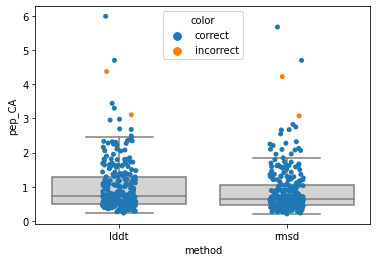

[0.41111111 0.06296296 0.02592593 0.0037037 ]


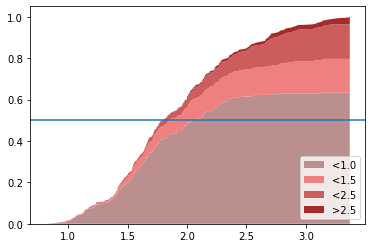

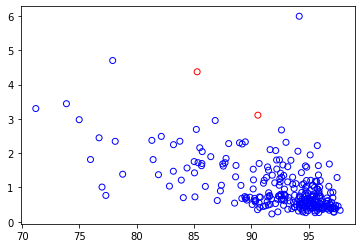

In [241]:
#test

df=result_df[result_df['class']==cl].copy()
#df['score']=result_parse_tools.get_regression_scores_I(df)

#best lddt
df1=df.copy()
df1['score']=df1['pep_lddt'].map(result_parse_tools.mean_pep_lddt)
df1=result_parse_tools.reduce_to_best(df1,['pmhc_id'],'score',how='max')
df1=df1.reset_index(drop=True)

#best score
#df2=df.copy()
#df2=result_parse_tools.reduce_to_best(df2,['pmhc_id'],'score',how='min')
#df2=df2.reset_index(drop=True)

#best rmsd
df3=df.copy()
df3=result_parse_tools.reduce_to_best(df3,['pmhc_id'],'pep_CA',how='min')
df3=df3.reset_index(drop=True)

#summarize_results([df1,df2,df3],['lddt','score','rmsd'])
summarize_results([df1,df3],['lddt','rmsd'])

#make_hill_plot(df2['pep_CA'],df2['score'],[1.,1.5,2.5],xticks=np.array([0.5,1.,1.5,2.,2.5,3.,3.5]),xlim=[0.5,3])   
make_hill_plot(df1['pep_CA'],100-df1['score'],[1.,1.5,2.5])#,xticks=np.array([0.5,1.,1.5,2.,2.5,3.,3.5]),xlim=[0.5,3])   

#colors=(df2['tails']!=df2['af_tails']).values
#cmap={True:'red',False:'blue'}
#colors=[cmap[c] for c in colors]
#plt.figure()
#plt.scatter(df2['score'],df2['pep_CA'],facecolors='none',edgecolors=colors)
#plt.show()

colors=(df1['tails']!=df1['af_tails']).values
cmap={True:'red',False:'blue'}
colors=[cmap[c] for c in colors]
plt.figure()
plt.scatter(df1['score'],df1['pep_CA'],facecolors='none',edgecolors=colors)
plt.show()

In [74]:
df2[df2['tails']!=df2['af_tails']]
#errors: one BF2, one mouse with (-1,1) 9mer (5trz, indeed -1,1)

,pmhc_id,model_id,n_reg,best_score,best_mhc_score,register_identified,af_tails,pep_lddt,pep_CA,pep_all,...,class,pep,mhc_a,mhc_b,tails,netmhc_tails,af_n_reg,seqnn_logkd,score,method
92,185,1,1,10,0,True,"(0, 0)","[88.16584166121902, 87.36592928500612, 89.9658...",4.371016,6.200813,...,I,YQSGLSIVM,"(10090, K, d)",None,"(-1, 1)","(0, 0)",1,4.042405,1.727405,score
182,484,1,1,31,22,True,"(0, 0)","[94.06630558804498, 95.73124057737459, 95.8707...",3.106247,3.899949,...,I,AVKGVGTMV,"(9031, BF2, 012:01)",None,"(0, 1)","(0, 0)",2,4.125988,1.375920,score


#### cl 2

Index(['len', 'mhc_score', 'n_reg', 'seqnn_logkd', 'register_identified',
       'mean_mhc_lddt', 'mean_pep_lddt', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9', 'P', 'M'],
      dtype='object')
Index(['n_reg', 'P', 'M'], dtype='object')


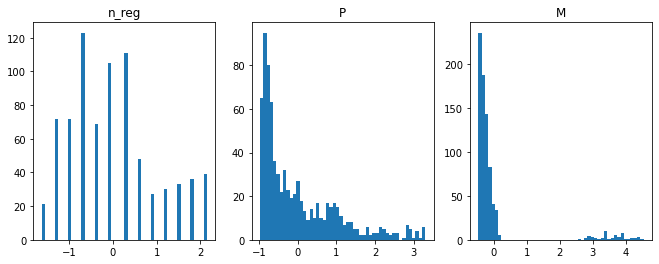

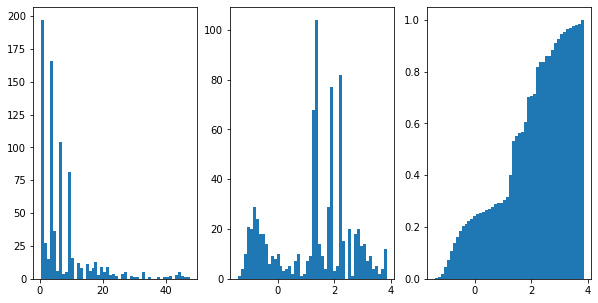

In [242]:
cl='II'

#prepare features
df=result_df[result_df['class']==cl]
features=features_all[result_df['class']==cl].copy()

#log? yes!
#for k in [f'P{i}' for i in range(1,10)]:
#    features[k]=np.log(features[k])
    
features['P']=features['mean_pep_lddt']
features['M']=features['mean_mhc_lddt']
    
#choose subset    #excl: len
print(features.columns)
#features=features[['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']]
#features=features[['mhc_score','n_reg','register_identified','seqnn_logkd','P']]
#features=features[['mhc_score','n_reg','register_identified','P']]
#features=features[['n_reg','register_identified','P']] #GOOD
features=features[['n_reg','P','M']]
print(features.columns)

#normalize
x=features.values
m=np.mean(x,axis=0)
std=np.std(x,axis=0)
features=(features-m)/std

#plot features and rmsd    
if True: 
    l=len(features.columns)
    nx=4
    ny=l//nx+int(l%nx>0)
    plt.figure(figsize=(15,4*ny))
    for i,k in enumerate(features.columns):
        plt.subplot(ny,nx,i+1)
        plt.hist(features[k],bins=50)
        plt.title(k)
    plt.show()
    plt.figure(figsize=(10,5))
    plt.subplot(131)
    plt.hist(df['pep_CA'],bins=50)
    plt.subplot(132)
    plt.hist(np.log(df['pep_CA']),bins=50)
    plt.subplot(133)
    plt.hist(np.log(df['pep_CA']),bins=50,cumulative=1,density=True)    
    plt.show()

iteration 0
[[0.24021558 1.09775915 0.21194853]]
lddt      : fails:  0, regerr:  2
score     : fails:  0, regerr:  2
median:
lddt      : pep_CA: 0.43, pep_all: 1.09, mhc_CA: 0.44, mhc_all: 1.15
score     : pep_CA: 0.43, pep_all: 1.09, mhc_CA: 0.44, mhc_all: 1.15
mean:
lddt      : pep_CA: 0.52, pep_all: 1.23, mhc_CA: 0.52, mhc_all: 1.19
score     : pep_CA: 0.52, pep_all: 1.23, mhc_CA: 0.52, mhc_all: 1.20


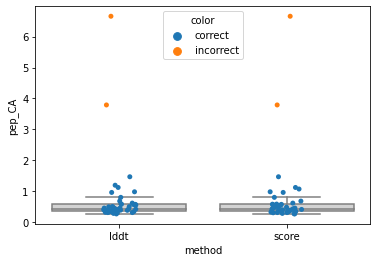

[0.5        0.02272727 0.         0.        ]
[0.47727273 0.04545455 0.         0.        ]
[0.47727273 0.04545455 0.         0.        ]
iteration 1
[[0.39073505 1.31124149 0.17514936]]
lddt      : fails:  0, regerr:  3
score     : fails:  0, regerr:  3
median:
lddt      : pep_CA: 0.49, pep_all: 1.11, mhc_CA: 0.44, mhc_all: 1.15
score     : pep_CA: 0.49, pep_all: 1.11, mhc_CA: 0.44, mhc_all: 1.15
mean:
lddt      : pep_CA: 0.58, pep_all: 1.25, mhc_CA: 0.53, mhc_all: 1.22
score     : pep_CA: 0.58, pep_all: 1.25, mhc_CA: 0.53, mhc_all: 1.22


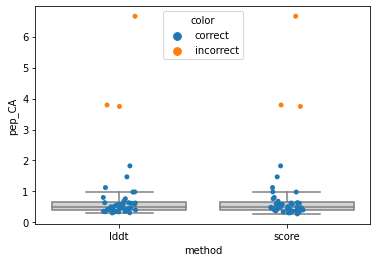

[0.47727273 0.04545455 0.         0.        ]
[0.47727273 0.02272727 0.02272727 0.        ]
[0.47727273 0.02272727 0.02272727 0.        ]
iteration 2
[[0.45845957 1.41902601 0.19730784]]
lddt      : fails:  0, regerr:  3
score     : fails:  0, regerr:  3
median:
lddt      : pep_CA: 0.47, pep_all: 1.12, mhc_CA: 0.44, mhc_all: 1.15
score     : pep_CA: 0.47, pep_all: 1.12, mhc_CA: 0.44, mhc_all: 1.15
mean:
lddt      : pep_CA: 0.56, pep_all: 1.25, mhc_CA: 0.53, mhc_all: 1.21
score     : pep_CA: 0.55, pep_all: 1.25, mhc_CA: 0.53, mhc_all: 1.22


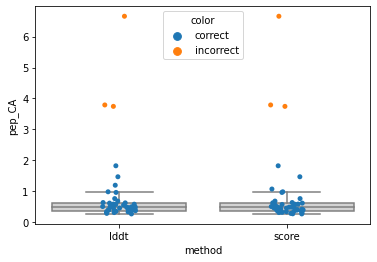

[0.5        0.02272727 0.         0.        ]
[0.45454545 0.04545455 0.02272727 0.        ]
[0.45454545 0.04545455 0.02272727 0.        ]
iteration 3
[[0.37069282 1.40550595 0.23341123]]
lddt      : fails:  0, regerr:  3
score     : fails:  0, regerr:  3
median:
lddt      : pep_CA: 0.47, pep_all: 1.21, mhc_CA: 0.44, mhc_all: 1.17
score     : pep_CA: 0.47, pep_all: 1.21, mhc_CA: 0.44, mhc_all: 1.17
mean:
lddt      : pep_CA: 0.57, pep_all: 1.32, mhc_CA: 0.53, mhc_all: 1.22
score     : pep_CA: 0.56, pep_all: 1.32, mhc_CA: 0.53, mhc_all: 1.22


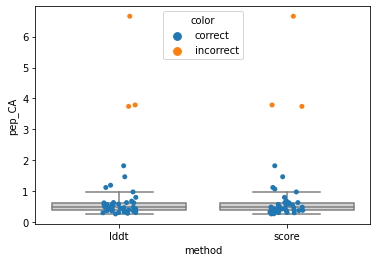

[0.5        0.02272727 0.         0.        ]
[0.45454545 0.04545455 0.02272727 0.        ]
[0.45454545 0.04545455 0.02272727 0.        ]
iteration 4
[[0.34719086 1.25419714 0.21630662]]
lddt      : fails:  0, regerr:  3
score     : fails:  0, regerr:  3
median:
lddt      : pep_CA: 0.47, pep_all: 1.22, mhc_CA: 0.44, mhc_all: 1.14
score     : pep_CA: 0.47, pep_all: 1.22, mhc_CA: 0.44, mhc_all: 1.15
mean:
lddt      : pep_CA: 0.55, pep_all: 1.31, mhc_CA: 0.48, mhc_all: 1.17
score     : pep_CA: 0.55, pep_all: 1.31, mhc_CA: 0.48, mhc_all: 1.18


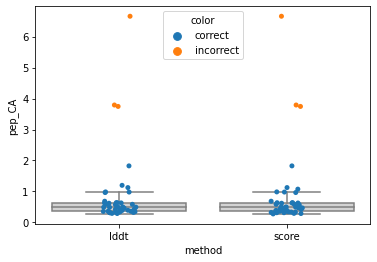

[0.5        0.02272727 0.         0.        ]
[0.47727273 0.02272727 0.02272727 0.        ]
[0.47727273 0.02272727 0.02272727 0.        ]
iteration 5
[[0.12925247 1.09282064 0.24232412]]
lddt      : fails:  0, regerr:  0
score     : fails:  0, regerr:  0
median:
lddt      : pep_CA: 0.47, pep_all: 1.25, mhc_CA: 0.43, mhc_all: 1.13
score     : pep_CA: 0.47, pep_all: 1.25, mhc_CA: 0.43, mhc_all: 1.14
mean:
lddt      : pep_CA: 0.55, pep_all: 1.31, mhc_CA: 0.50, mhc_all: 1.18
score     : pep_CA: 0.55, pep_all: 1.31, mhc_CA: 0.50, mhc_all: 1.18


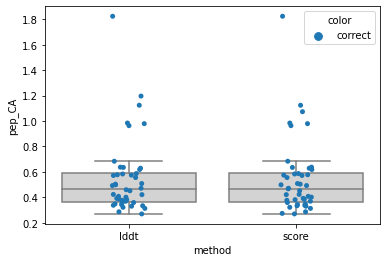

[0.52272727 0.         0.         0.        ]
[0.47727273 0.02272727 0.02272727 0.        ]
[0.47727273 0.02272727 0.02272727 0.        ]
iteration 6
[[0.42833256 1.03313238 0.16903386]]
lddt      : fails:  0, regerr:  2
score     : fails:  0, regerr:  2
median:
lddt      : pep_CA: 0.43, pep_all: 1.10, mhc_CA: 0.44, mhc_all: 1.15
score     : pep_CA: 0.43, pep_all: 1.10, mhc_CA: 0.44, mhc_all: 1.15
mean:
lddt      : pep_CA: 0.53, pep_all: 1.23, mhc_CA: 0.53, mhc_all: 1.20
score     : pep_CA: 0.53, pep_all: 1.23, mhc_CA: 0.53, mhc_all: 1.20


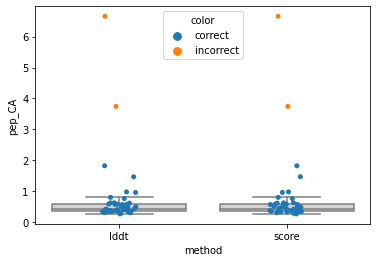

[0.5        0.02272727 0.         0.        ]
[0.47727273 0.02272727 0.02272727 0.        ]
[0.47727273 0.02272727 0.02272727 0.        ]
iteration 7
[[0.1358711  1.34979536 0.20696181]]
lddt      : fails:  0, regerr:  2
score     : fails:  0, regerr:  2
median:
lddt      : pep_CA: 0.44, pep_all: 1.13, mhc_CA: 0.42, mhc_all: 1.14
score     : pep_CA: 0.44, pep_all: 1.13, mhc_CA: 0.42, mhc_all: 1.15
mean:
lddt      : pep_CA: 0.51, pep_all: 1.23, mhc_CA: 0.50, mhc_all: 1.20
score     : pep_CA: 0.50, pep_all: 1.23, mhc_CA: 0.50, mhc_all: 1.20


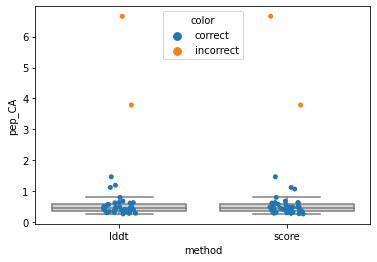

[0.47727273 0.04545455 0.         0.        ]
[0.47727273 0.04545455 0.         0.        ]
[0.47727273 0.04545455 0.         0.        ]
iteration 8
[[0.34808117 1.29576832 0.22358831]]
lddt      : fails:  0, regerr:  3
score     : fails:  0, regerr:  3
median:
lddt      : pep_CA: 0.46, pep_all: 1.14, mhc_CA: 0.47, mhc_all: 1.15
score     : pep_CA: 0.46, pep_all: 1.14, mhc_CA: 0.47, mhc_all: 1.15
mean:
lddt      : pep_CA: 0.56, pep_all: 1.26, mhc_CA: 0.55, mhc_all: 1.22
score     : pep_CA: 0.55, pep_all: 1.26, mhc_CA: 0.55, mhc_all: 1.23


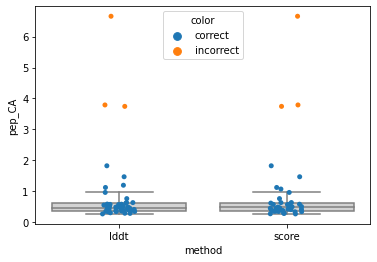

[0.47727273 0.04545455 0.         0.        ]
[0.45454545 0.04545455 0.02272727 0.        ]
[0.45454545 0.04545455 0.02272727 0.        ]
iteration 9
[[0.33889781 1.39139948 0.2194266 ]]
lddt      : fails:  0, regerr:  1
score     : fails:  0, regerr:  1
median:
lddt      : pep_CA: 0.45, pep_all: 1.22, mhc_CA: 0.43, mhc_all: 1.15
score     : pep_CA: 0.45, pep_all: 1.22, mhc_CA: 0.43, mhc_all: 1.15
mean:
lddt      : pep_CA: 0.55, pep_all: 1.30, mhc_CA: 0.49, mhc_all: 1.17
score     : pep_CA: 0.55, pep_all: 1.30, mhc_CA: 0.49, mhc_all: 1.18


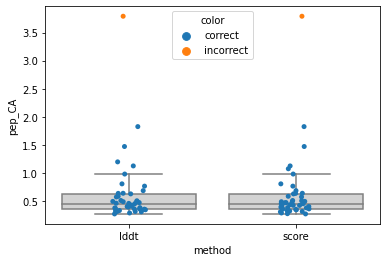

[0.47727273 0.04545455 0.         0.        ]
[0.45454545 0.04545455 0.02272727 0.        ]
[0.45454545 0.04545455 0.02272727 0.        ]


In [243]:
##cross-validation by repeated subsampling

threshold=1.5 #for binarizing pep_CA in logistic regression
C=0.1 #0.01
l1_ratio=0.1

train_fraction=0.6
N_tests=10

pmhc_ids=df['pmhc_id'].unique()
n=int(len(pmhc_ids)*test_fraction)
for i in range(N_tests):
    print(f'iteration {i}')    
    pmhc_ids=np.random.permutation(pmhc_ids)    
    pmhc_ids_train,pmhc_ids_test=pmhc_ids[:n],pmhc_ids[n:]
    df_train=df[df['pmhc_id'].isin(pmhc_ids_train)].copy()
    df_test=df[df['pmhc_id'].isin(pmhc_ids_test)].copy()
    features_train=features.loc[df_train.index]
    features_test=features.loc[df_test.index]    

    #train
    reg=LogisticRegression(penalty='elasticnet',solver='saga',C=C,l1_ratio=l1_ratio,max_iter=1000)    
    reg.fit(features_train.values,(df_train['pep_CA']>threshold).values.astype(int))
    print(reg.coef_)
    
    #test
    df_test['regression_score']=reg.predict_proba(features_test.values)[:,1]  
    df_test['mean_pep_lddt']=features_test['P']
    df1=result_parse_tools.reduce_to_best(df_test,['pmhc_id'],'mean_pep_lddt',how='min') #reduce by lddt
    df2=result_parse_tools.reduce_to_best(df_test,['pmhc_id'],'regression_score',how='min')  #reduce by score
    summarize_results([df1,df2],['lddt','score'])  
    #reduce by lddt, use lddt
    frac1=make_hill_plot(df1['pep_CA'],df1['mean_pep_lddt'],[1.,1.5,2.5],return_frac=True)
    #reduce by lddt, use score
    frac2=make_hill_plot(df1['pep_CA'],df1['regression_score'],[1.,1.5,2.5],return_frac=True)  
    #reduce by score, use score
    frac3=make_hill_plot(df2['pep_CA'],df2['regression_score'],[1.,1.5,2.5],return_frac=True)
    print(frac1)
    print(frac2)
    print(frac3)   

In [244]:
print(reg.coef_.shape)
for x in zip(features.columns,reg.coef_[0]):
    print(x)

(1, 3)
('n_reg', 0.33889781365501864)
('P', 1.3913994814723074)
('M', 0.2194265950916447)


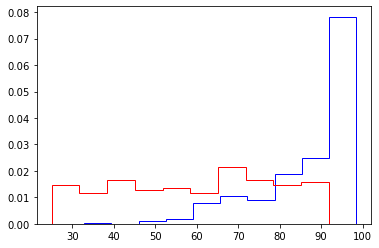

In [504]:
x1=df[df['register_identified']]['pep_lddt'].map(np.mean)
x2=df[~df['register_identified']]['pep_lddt'].map(np.mean)
plt.figure()
plt.hist(x1,histtype='step',color='blue',density=True)
plt.hist(x2,histtype='step',color='red',density=True)
plt.show()

[[0.14205821 2.05897507 0.35676408]]
lddt      : fails:  0, regerr:  3
score     : fails:  0, regerr:  3
rmsd      : fails:  0, regerr:  0
median:
lddt      : pep_CA: 0.46, pep_all: 1.14, mhc_CA: 0.44, mhc_all: 1.15
score     : pep_CA: 0.47, pep_all: 1.14, mhc_CA: 0.44, mhc_all: 1.15
rmsd      : pep_CA: 0.41, pep_all: 1.16, mhc_CA: 0.45, mhc_all: 1.15
mean:
lddt      : pep_CA: 0.55, pep_all: 1.27, mhc_CA: 0.51, mhc_all: 1.20
score     : pep_CA: 0.54, pep_all: 1.27, mhc_CA: 0.52, mhc_all: 1.20
rmsd      : pep_CA: 0.50, pep_all: 1.25, mhc_CA: 0.50, mhc_all: 1.19


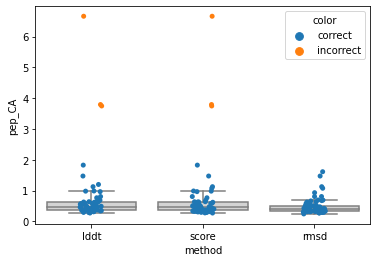

[0.48387097 0.03225806 0.         0.        ]


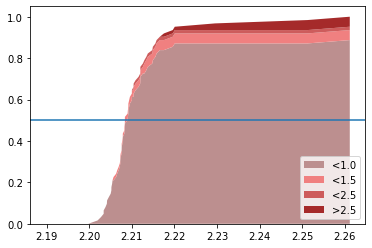

[0.4516129  0.0483871  0.01612903 0.        ]


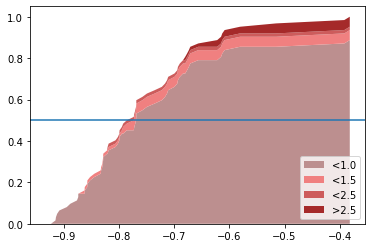

[0.4516129  0.0483871  0.01612903 0.        ]


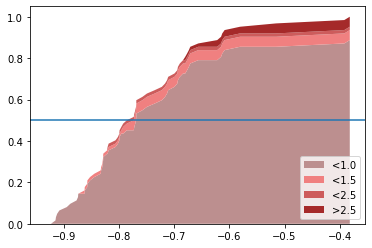

In [254]:
#test

df0=df.copy()
reg=LogisticRegression(penalty='elasticnet',solver='saga',C=C,l1_ratio=l1_ratio,max_iter=1000)    
reg.fit(features.values,(df0['pep_CA']>threshold).values.astype(int))
print(reg.coef_)
df0['regression_score']=reg.predict_proba(features.values)[:,1]
df0['mean_pep_lddt']=features['P']

#lddt
df1=df0.copy()
df1=result_parse_tools.reduce_to_best(df1,['pmhc_id'],'mean_pep_lddt',how='min')
df1=df1.reset_index(drop=True)

#linear model
df3=df0.copy()
df3=result_parse_tools.reduce_to_best(df3,['pmhc_id'],'regression_score',how='min')
df3=df3.reset_index(drop=True)

#best rmsd
df4=df0.copy()
df4=result_parse_tools.reduce_to_best(df4,['pmhc_id'],'pep_CA',how='min')
df4=df4.reset_index(drop=True)

#summarize_results([df1,df2,df3,df4],['lddt','mod_lddt','score','rmsd'])
summarize_results([df1,df3,df4],['lddt','score','rmsd'])

make_hill_plot(df1['pep_CA'],10+df1['mean_pep_lddt'],[1.,1.5,2.5])#,xlim=[0.5,3])   
make_hill_plot(df1['pep_CA'],df1['regression_score'],[1.,1.5,2.5])#,xticks=np.array([0.1,0.5,1.]))#,xlim=[0.5,3])   
make_hill_plot(df3['pep_CA'],df3['regression_score'],[1.,1.5,2.5])#,xticks=np.array([0.1,0.5,1.]))#,xlim=[0.5,3])  

In [495]:
df3[df3['af_tails']!=df3['tails']]

,pmhc_id,model_id,n_reg,best_score,best_mhc_score,register_identified,af_tails,pep_lddt,pep_CA,pep_all,...,mhc_all,class,pep,mhc_a,mhc_b,tails,netmhc_tails,af_n_reg,regression_score,method
17,216,9,1,7,0,True,"(3, 1)","[96.31331347479963, 97.67958477575021, 97.7208...",6.658695,8.126685,...,1.170889,II,QPFPQPELPYPGS,"(9606, DQA1, 05:01)","(9606, DQB1, 02:01)","(1, 3)","(3, 1)",5,0.465179,score
42,553,5,1,15,0,True,"(4, 2)","[95.31313550792073, 92.07542320821427, 96.7328...",3.517968,5.338878,...,1.064305,II,TSKGLFRAAVPSGAS,"(9606, DRA, 01:01)","(9606, DRB1, 04:01)","(5, 1)","(4, 2)",3,0.338521,score
52,754,3,1,16,0,True,"(3, 2)","[94.08464776781055, 96.63649632368178, 96.3406...",3.791334,6.054087,...,1.246270,II,LVEALYLVCGERGG,"(9606, DQA1, 03:01)","(9606, DQB1, 03:02)","(2, 3)","(4, 0)",4,0.664642,score
57,871,1,1,13,0,True,"(-1, 4)","[91.25652338038162, 91.25652338038162, 93.4139...",8.928325,9.688874,...,1.134683,II,AYMRADAAAGGA,"(9606, DRA, 01:01)","(9606, DRB1, 04:01)","(2, 1)","(2, 1)",5,0.409080,score


In [77]:
#pmhc seq clusters selected for modeling
print('pmhcs seq clusters filtered')
with open(source_dir+'/pmhcs_seq_clusters_filtered.pckl','rb') as f:
    pmhcs_filtered=pickle.load(f) #seq clusters filtered
print(len(pmhcs_filtered))
print(pmhcs_filtered[0].keys())

#make dataframes
df=pd.DataFrame(pmhcs_filtered)
def _map_pep(x):    
    return ''.join(pmhcs[x]['P']['data']['seq'])
def _map_mhc_a(x):    
    return seq_tools.load_NUMSEQ(pmhcs[x]['M'])
def _map_mhc_b(x):    
    if 'N' in pmhcs[x]:
        return seq_tools.load_NUMSEQ(pmhcs[x]['N'])
    else:
        return None
df['pmhc_id']=df['pmhc_ids'].map(lambda x:x[0]) #keep id of the pmhc we model
df['pdb_id']=df['pmhc_id'].map(lambda x:pmhcs[x]['pdbs'][0][0])
df=df.drop(['pmhc_ids'],axis=1)
df=df.drop(['pdbs'],axis=1)
for k in ['class','tails','netmhc_tails','netmhc_kd']:
    df[k]=df['pmhc_id'].map(lambda x: pmhcs[x][k])
df['pep']=df['pmhc_id'].map(_map_pep)
df['mhc_a']=df['pmhc_id'].map(_map_mhc_a)
df['mhc_b']=df['pmhc_id'].map(_map_mhc_b)

#drop test
df=df[df['date']<date_cutoff]
print('before cutoff:',len(df))
#tail statistics for cl 1
x=df[df['class']=='I']
print('cl 1:',len(x))
print('non trivial tails in cl 1:',np.sum(x['tails']!=(0,0)))
print('netmhc errors in cl 1:',np.sum(x['tails']!=x['netmhc_tails']))
x=df[df['class']=='II']
print('cl 2:',len(x))
print('netmhc errors in cl 2:',np.sum(x['tails']!=x['netmhc_tails']))

df_target=df
df_target=df_target.rename({'id':'cluster_seq'},axis=1) #that's what it is
df_target=df_target[df_target.columns[[4,0,3,2,1,5,6,7,8,9,10]]]
df_target=df_target.sort_values(['class','cluster_seq','pmhc_id','pdb_id'])
df_target=df_target.reset_index(drop=True)

#pdbs to exclude from templates: pdbs from the same seq cluster
def _cluster_to_pdbs(x):
    return list(set([a[0].split('_')[0] for a in pmhcs_seq_clusters[x]['pdbs']]))        
df_target['exclude_pdbs']=df_target['cluster_seq'].map(_cluster_to_pdbs)

print(len(df_target))
print(df_target.columns)

pmhcs seq clusters filtered
444
dict_keys(['id', 'pmhc_ids', 'pdbs', 'date'])
before cutoff: 332
cl 1: 270
non trivial tails in cl 1: 13
netmhc errors in cl 1: 9
cl 2: 62
netmhc errors in cl 2: 19
332
Index(['class', 'cluster_seq', 'pdb_id', 'pmhc_id', 'date', 'tails',
       'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b', 'exclude_pdbs'],
      dtype='object')


In [233]:
target_dir='/scratch/vmikhayl/pmhc_modeling/discovery_dataset_final'
target_dir_apollo='/scratch/lustre/vmikhayl/pmhc_modeling/discovery_dataset_final'

ctarget_dir=target_dir
ctarget_dir_apollo=target_dir_apollo

In [79]:
#run seqnn
t0=time.time()
df_target=make_inputs.run_seqnn(df_target)
print('kd predicted for {:4d} pmhcs in {:5.1f} s'.format(len(df_target),time.time()-t0))

making Kd predictions for 270 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


making Kd predictions for 62 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


kd predicted for  332 pmhcs in  51.5 s


In [82]:
#UPDATE PEP GAP PENALTY IN CONFIG, RELOAD!!!

t0=time.time()
af_inputs=make_inputs.make_inputs(df_target,date_cutoff=date_cutoff,print_stats=True)
print('prepared {:4d} inputs in {:5.1f} s'.format(len(af_inputs),time.time()-t0))

class I:
pmhcs: 270; runs:  954, runs per pmhc: av 3.5, max 15; registers per pmhc: av 1.2, max  5
class II:
pmhcs:  62; runs:  786, runs per pmhc: av 12.7, max 39; registers per pmhc: av 4.2, max 13
prepared 1740 inputs in  31.9 s


In [87]:
#verify template date cutoff and cluster separation
with open('./data/experimental_structures/processed_updated/summary.pckl','rb') as f:
    pdb_summary=pickle.load(f)
    
pdbs_target=set()
pdbs_template=set()
scores=[]
for x in af_inputs:
    pdbs_target.add(x['true_pdb'])
    for y in x['template_hits']:
        pdbs_template.add(y['name'])
        scores.append(1000-y['sum_probs'])
target_dates=[pdb_summary[x]['date'] for x in pdbs_target]
template_dates=[pdb_summary[x]['date'] for x in pdbs_template]
print('targets:')
print(min(target_dates),max(target_dates))
print('templates:')
print(min(template_dates),max(template_dates))

utils.print_hist(scores)

targets:
1992-08-11 2019-06-11
templates:
1992-08-11 2018-04-24
3     3
4    44
5   152
6   373
7   481
8   414
9   307
10  228
11  149
12  133
13  133
14  224
15  296
16  217
17  158
18  102
19  113
20   68
21   44
22   40
23   65
24   69
25   82
26   61
27   40
28   40
29   85
30   61
31   88
32   50
33   81
34   45
35   49
36   50
37   78
38  130
39  169
40  182
41  115
42   79
43   23
44   16
45   22
46   21
47   11
48    9
49   16
50    6
51   10
52    4
53   19
54   29
55   36
56   31
57   34
58   28
59   16
60   12
61    4
63    1
66    1
67    1
68    1
69    4
70    4
71    3
72   16
73   13
74   11
75   14
76    8
77   15
78   23
79   24
80    6
104   4
105   5
106   1


In [146]:
#compare inputs to run_4
af_inputs4=[]
for filename in os.listdir('/scratch/vmikhayl/pmhc_modeling/discovery_dataset/run_4/inputs'):
    with open('/scratch/vmikhayl/pmhc_modeling/discovery_dataset/run_4/inputs/'+filename,'rb') as f:
        af_inputs4+=pickle.load(f)
print(len(af_inputs4))

inputs_dict={(x['target_id'],x['current_id']):x for x in af_inputs}
inputs_dict4={(x['target_id'],x['current_id']):x for x in af_inputs4}
print(inputs_dict.keys()==inputs_dict4.keys())
dif_inputs=[]
for k in inputs_dict:
    if inputs_dict[k]!=inputs_dict4[k]:
        dif_inputs.append((inputs_dict[k],inputs_dict4[k]))
print(len(dif_inputs))

klist=['sequences', 'msas',  'renumber_list', 'target_id', 'current_id', 
       'registers', 'best_mhc_score', 'best_score', 'true_pdb'] #all keys except template_hits
for x in dif_inputs:
    for k in klist:
        assert x[0][k]==x[1][k] 
#difference only in template_hits

#print old pdbids, new pdbids (difference only)
for x in dif_inputs:
    z=[]
    for i in [0,1]:
        z.append([y['name'] for y in x[i]['template_hits']])
    print(set(z[1])-set(z[0]),set(z[0])-set(z[1]))    

1740
True
40
{'7k81_0'} {'4wu5_0'}
{'7bh8_0'} {'1kpr_0'}
{'7k81_0'} {'4wu5_0'}
{'6pag_0'} {'5vge_0'}
{'6pag_0'} {'5vge_0'}
{'6pag_0'} {'5vge_0'}
{'6pag_0'} {'5vge_0'}
{'6pag_0'} {'5vge_0'}
{'7bh8_0'} {'1kpr_0'}
{'6pag_0'} {'5vge_0'}
{'7k81_0'} {'4wu5_0'}
{'7k81_0'} {'4wu5_0'}
{'6pag_0'} {'5vge_0'}
{'6pag_0'} {'5vge_0'}
{'6pag_0'} {'5vge_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}
{'6v1a_0'} {'6bil_0'}


In [88]:
#split jobs

inputs=af_inputs
python_path='/data/vmikhayl/alphafold-multimer/alphafold/tfold_run_alphafold.py'
sh_path='./scripts/run_alphafold.sh'

n_tasks=8 #16
apollo=True
exclusive=False #True
gpu=True
qos='short'
time_per_input=35. #in seconds
time_per_task=int(len(inputs)*time_per_input/(60*n_tasks))
max_run_time=int(time_per_task*1.5)
print('estimated time per task, min:',time_per_task)
print('max run time, min:',max_run_time)

input_dir =ctarget_dir+'/inputs'
log_dir   =ctarget_dir+'/logs'
output_dir=ctarget_dir+'/outputs'
if apollo:
    input_dir_server =ctarget_dir_apollo+'/inputs'
    log_dir_server   =ctarget_dir_apollo+'/logs'
    output_dir_server=ctarget_dir_apollo+'/outputs'
else:
    input_dir_server =input_dir
    log_dir_server   =log_dir
    output_dir_server=output_dir

#make dirs
for d in [input_dir,log_dir,output_dir]:
    os.makedirs(d,exist_ok=True)    
#save a copy of df_target
df_target.to_pickle(ctarget_dir+'/target_df.pckl')
#make input files
indices=utils.split_jobs(len(inputs),n_tasks)
n_tasks=len(indices)
max_inputs_per_task=-1
for i,job in enumerate(indices):
    c_inputs=[inputs[j] for j in job]        
    max_inputs_per_task=max(max_inputs_per_task,len(c_inputs))
    with open(input_dir+'/input_'+str(i)+'.pckl','wb') as f:
        pickle.dump(c_inputs,f)  
print('tasks: {}, max inputs per task: {}'.format(n_tasks,max_inputs_per_task))

#make .sh        
lines=[]
lines.append('#!/bin/bash')
lines.append('')
lines.append(f'#SBATCH --array=0-{n_tasks-1}')             #run an array of n_tasks tasks
lines.append(f'#SBATCH --output={log_dir_server}/output_%a.txt')  #here %a will evaluate to array task id
lines.append(f'#SBATCH --error={log_dir_server}/error_%a.txt')
lines.append(f'#SBATCH --ntasks=1')                        #each array element is one task
if exclusive:
    lines.append(f'#SBATCH --exclusive')                   #request exclusive use of node, e.g. for hhblits
if gpu:
    lines.append(f'#SBATCH --gpus=1')                      #one gpu per task will use one core
#elif not exclusive:
#    lines.append(f'#SBATCH --cpus-per-task=1')             #one cpu per task
lines.append(f'#SBATCH --qos={qos}')  
lines.append(f'#SBATCH --time={max_run_time}')             #maximal run time in minutes, same for each array task
lines.append('')
lines.append(f'input_file={input_dir_server}/input_$SLURM_ARRAY_TASK_ID.pckl')        
lines.append(f'srun python {python_path} --inputs $input_file --output_dir {output_dir_server}')

if not sh_path.startswith(('/','./')):
    sh_path='./'+sh_path
with open(sh_path,'w') as f:
    f.writelines('\n'.join(lines))
os.chmod(sh_path, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)      

estimated time per task, min: 126
max run time, min: 189
tasks: 8, max inputs per task: 218


In [113]:
#check results
n=0
for x in os.listdir(ctarget_dir+'/outputs'):
    for y in os.listdir(ctarget_dir+'/outputs/'+x):
        if y.endswith('.pdb'):
            n+=1
print('structures produced:',n)
t=[]
for x in os.listdir(ctarget_dir+'/logs'):
    if x.startswith('output'):
        with open(ctarget_dir+'/logs/'+x) as f:
            s=f.read().split('\n')
        if len(s)>1:
            for line in s:
                if line.startswith('time per input:'):
                    t.append(float(line.split(':')[1]))
                    break            
print('times loaded for {} runs'.format(len(t)))
print('time per structure: mean {:4.1f} s, max {:4.1f} s'.format(np.mean(t),max(t)))
#note: on 16 jobs, time per structure was ~42s; on 8 jobs, down to 35, despite pep renumbering and rmsd added:
#still saving on startup time!

structures produced: 1740
times loaded for 8 runs
time per structure: mean 29.6 s, max 32.2 s


In [114]:
#assemple result_df
result_parse_tools.parse_results(ctarget_dir)

1740 outputs collected in  253.7 s


In [115]:
result_df=pd.read_pickle(ctarget_dir+'/result_df.pckl')
print(len(result_df))
print(result_df.columns)

1740
Index(['pmhc_id', 'model_id', 'n_reg', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'pep', 'mhc_a', 'mhc_b',
       'tails', 'netmhc_tails', 'af_n_reg', 'seqnn_logkd'],
      dtype='object')


In [116]:
def _color_by_regerr(x):
    if not x['register_identified']:
        return 'not identified'
    elif x['tails']!=x['af_tails']:
        return 'incorrect'
    else:
        return 'correct'
def summarize_results(df_list,names_list):    
    df_list=[x.copy() for x in df_list]
    n_fail=[np.sum(~x['register_identified']) for x in df_list]
    n_regerr=[np.sum(x['register_identified']&(x['tails']!=x['af_tails'])) for x in df_list]
    #good_df_list=[x[(x['tails']==x['af_tails'])&(x['register_identified'])] for x in df_list]    
    good_df_list=df_list #median and mean for all
    for name, fail, regerr in zip(names_list,n_fail,n_regerr):
        print('{:10s}: fails: {:2d}, regerr: {:2d}'.format(name, fail, regerr))    
    print('median:')
    for name, df in zip(names_list,good_df_list):
        s=[]
        for k in ['pep_CA','pep_all','mhc_CA','mhc_all']:
            s.append('{:s}: {:4.2f}'.format(k,df[k].median()))
        print('{:10s}: '.format(name)+', '.join(s))
    print('mean:')
    for name, df in zip(names_list,good_df_list):
        s=[]
        for k in ['pep_CA','pep_all','mhc_CA','mhc_all']:
            s.append('{:s}: {:4.2f}'.format(k,df[k].mean()))
        print('{:10s}: '.format(name)+', '.join(s))       
    for name,df in zip(names_list,df_list):
        df['model selection']=[name]*len(df)    
    df=pd.concat(df_list)
    df['register']=df.apply(_color_by_regerr,axis=1)
    plt.figure()
    sns.boxplot(data=df,y='pep_CA',x='model selection',color='lightgray',fliersize=0)
    sns.stripplot(data=df,y='pep_CA',x='model selection',hue='register',marker='.')
    plt.show()
#hill_colors=['rosybrown','lightcoral','indianred','brown','maroon']
hill_colors=['lightgray','darkgray','dimgray','black']
def make_hill_plot(rmsds,scores,rmsd_bins,xticks=None,xlim=None,loc=None,return_frac=False): 
    rmsd_bins_ext=[0.]+rmsd_bins+[10000.]
    scores=np.array(scores)
    score_bins=np.sort(np.unique(scores))
    score_bins=[0.99*score_bins[0]]+list(score_bins)+[1.01*score_bins[-1]]    
    counts=[]
    for s in score_bins:        
        r=rmsds[scores<s]
        counts.append([np.sum((r>=rmsd_bins_ext[i])&(r<rmsd_bins_ext[i+1])) for i in range(len(rmsd_bins_ext)-1)])
    counts=np.stack(counts).T/len(rmsds) #fractions, (n_groups,n_score_thresholds)
    counts_at_half=counts[:,np.sum(counts,axis=0)>0.5][:,0]
    if return_frac:
        return counts_at_half
    print(counts_at_half) #fractions for threshold when half models pass
    plt.figure()
    plt.stackplot(np.log(score_bins),counts,colors=hill_colors[:len(rmsd_bins)+1])            
    if not (xlim is None):
        plt.xlim(np.log(xlim))
        if not (xticks is None):
            xticks=xticks[(xticks>=xlim[0])&(xticks<=xlim[1])]
    if not (xticks is None):
        plt.xticks(np.log(xticks),xticks)
    loc=loc or 'lower right'
    plt.legend([f'<{r}' for r in rmsd_bins]+[f'>{rmsd_bins[-1]}'],loc=loc)
    plt.axhline(0.5)
    plt.show()

1740
Index(['pmhc_id', 'model_id', 'n_reg', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'pep', 'mhc_a', 'mhc_b',
       'tails', 'netmhc_tails', 'af_n_reg', 'seqnn_logkd'],
      dtype='object')
I
best lddt : fails:  1, regerr:  2
best rmsd : fails:  0, regerr:  2
median:
best lddt : pep_CA: 0.73, pep_all: 1.55, mhc_CA: 0.47, mhc_all: 1.13
best rmsd : pep_CA: 0.66, pep_all: 1.44, mhc_CA: 0.46, mhc_all: 1.12
mean:
best lddt : pep_CA: 1.01, pep_all: 1.86, mhc_CA: 0.54, mhc_all: 1.21
best rmsd : pep_CA: 0.87, pep_all: 1.68, mhc_CA: 0.53, mhc_all: 1.20


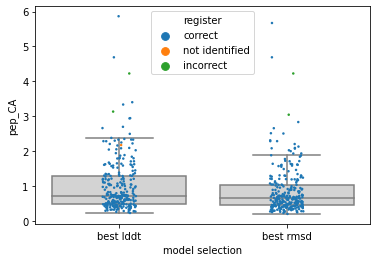

[0.41111111 0.06296296 0.02592593 0.0037037 ]


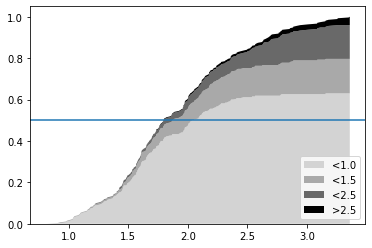

II
best lddt : fails:  0, regerr:  3
best rmsd : fails:  0, regerr:  0
median:
best lddt : pep_CA: 0.48, pep_all: 1.21, mhc_CA: 0.44, mhc_all: 1.15
best rmsd : pep_CA: 0.41, pep_all: 1.15, mhc_CA: 0.45, mhc_all: 1.15
mean:
best lddt : pep_CA: 0.75, pep_all: 1.54, mhc_CA: 0.51, mhc_all: 1.20
best rmsd : pep_CA: 0.50, pep_all: 1.25, mhc_CA: 0.50, mhc_all: 1.19


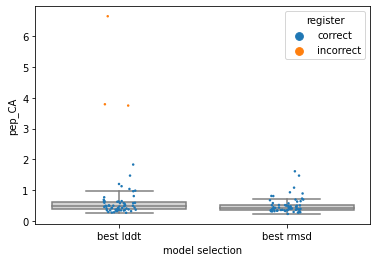

[0.46774194 0.0483871  0.         0.        ]


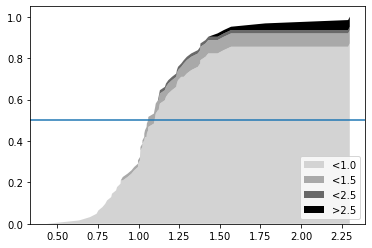

In [234]:
result_df=pd.read_pickle(ctarget_dir+'/result_df.pckl')
print(len(result_df))
print(result_df.columns)

result_df['score']=100-result_df['pep_lddt'].map(result_parse_tools.mean_pep_lddt)
#MAKE compute_scores in result parse tools; add smth like 10*(reg not assigned)!!

for cl in ['I','II']:
    print(cl)
    df0=result_df[result_df['class']==cl].copy()
    df_lddt=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'score',how='min')
    df_lddt=df_lddt.reset_index(drop=True)
    df_rmsd=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'pep_CA',how='min')
    df_rmsd=df_rmsd.reset_index(drop=True)    
    summarize_results([df_lddt,df_rmsd],['best lddt','best rmsd'])
    make_hill_plot(df_lddt['pep_CA'],df_lddt['score'],[1.,1.5,2.5])#,xticks=None,xlim=None,loc=None)     

# test dataset

## load data

In [3]:
#pmhc seq clusters selected for modeling
print('pmhcs seq clusters filtered')
with open(source_dir+'/pmhcs_seq_clusters_filtered.pckl','rb') as f:
    pmhcs_filtered=pickle.load(f) #seq clusters filtered
print(len(pmhcs_filtered))
print(pmhcs_filtered[0].keys())

#make dataframes
df=pd.DataFrame(pmhcs_filtered)
def _map_pep(x):    
    return ''.join(pmhcs[x]['P']['data']['seq'])
def _map_mhc_a(x):    
    return seq_tools.load_NUMSEQ(pmhcs[x]['M'])
def _map_mhc_b(x):    
    if 'N' in pmhcs[x]:
        return seq_tools.load_NUMSEQ(pmhcs[x]['N'])
    else:
        return None
df['pmhc_id']=df['pmhc_ids'].map(lambda x:x[0]) #keep id of the pmhc we model
df['pdb_id']=df['pmhc_id'].map(lambda x:pmhcs[x]['pdbs'][0][0])
df=df.drop(['pmhc_ids'],axis=1)
df=df.drop(['pdbs'],axis=1)
for k in ['class','tails','netmhc_tails','netmhc_kd']:
    df[k]=df['pmhc_id'].map(lambda x: pmhcs[x][k])
df['pep']=df['pmhc_id'].map(_map_pep)
df['mhc_a']=df['pmhc_id'].map(_map_mhc_a)
df['mhc_b']=df['pmhc_id'].map(_map_mhc_b)

#drop train
df=df[df['date']>date_cutoff]
print('after cutoff:',len(df))
#tail statistics for cl 1
x=df[df['class']=='I']
print('cl 1:',len(x))
print('non trivial tails in cl 1:',np.sum(x['tails']!=(0,0)))
print('netmhc errors in cl 1:',np.sum(x['tails']!=x['netmhc_tails']))
x=df[df['class']=='II']
print('cl 2:',len(x))
print('netmhc errors in cl 2:',np.sum(x['tails']!=x['netmhc_tails']))

df_target=df
df_target=df_target.rename({'id':'cluster_seq'},axis=1) #that's what it is
df_target=df_target[df_target.columns[[4,0,3,2,1,5,6,7,8,9,10]]]
df_target=df_target.sort_values(['class','cluster_seq','pmhc_id','pdb_id'])
df_target=df_target.reset_index(drop=True)

#fix MHC pdbnum order to match seq_tools.mhcs
#TODO: fix NUMSEQ.repair_gaps and pdbnum ordering in pmhcs/tcrs in the database! 
def fix_mhc_chain_pdbnums(mhc):
    if not (mhc is None):
        mhc_true=seq_tools.mhcs[mhc.info['species'],mhc.info['locus'],mhc.info['allele']]    
        pdbnum=mhc.data['pdbnum']
        pdbnum_true=mhc_true.data['pdbnum']
        assert set(list(pdbnum))==set(list(pdbnum_true)) #must only differ by permutation
        pdbnum_l=list(pdbnum)
        ind=[pdbnum_l.index(x) for x in pdbnum_true]
        mhc.data=mhc.data[ind] #permute
        return tuple(ind)==tuple(list(range(len(ind))))            
    else:
        return True
mismatches=df_target['mhc_a'].map(fix_mhc_chain_pdbnums)
print('pdbnum misordering in chain A:',np.sum(~mismatches))
mismatches=df_target['mhc_b'].map(fix_mhc_chain_pdbnums)
print('pdbnum misordering in chain B:',np.sum(~mismatches))

#pdbs to exclude from templates: pdbs from the same seq cluster:
#IMPOSE DATE CUTOFF ON TEMPLATES INSTEAD
#def _cluster_to_pdbs(x):
#    return list(set([a[0].split('_')[0] for a in pmhcs_seq_clusters[x]['pdbs']]))        
#df_target['exclude_pdbs']=df_target['cluster_seq'].map(_cluster_to_pdbs)

print(len(df_target))
print(df_target.columns)

pmhcs seq clusters filtered
444
dict_keys(['id', 'pmhc_ids', 'pdbs', 'date'])
after cutoff: 112
cl 1: 101
non trivial tails in cl 1: 3
netmhc errors in cl 1: 3
cl 2: 11
netmhc errors in cl 2: 6
pdbnum misordering in chain A: 1
pdbnum misordering in chain B: 0
112
Index(['class', 'cluster_seq', 'pdb_id', 'pmhc_id', 'date', 'tails',
       'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b'],
      dtype='object')


## make inputs, process outputs

In [4]:
target_dir='/scratch/vmikhayl/pmhc_modeling/test_dataset'
target_dir_apollo='/scratch/lustre/vmikhayl/pmhc_modeling/test_dataset'

ctarget_dir=target_dir
ctarget_dir_apollo=target_dir_apollo

In [5]:
#run seqnn
t0=time.time()
df_target=make_inputs.run_seqnn(df_target)
print('kd predicted for {:4d} pmhcs in {:5.1f} s'.format(len(df_target),time.time()-t0))

making Kd predictions for 101 pmhcs...


2022-11-22 18:26:40.523579: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


making Kd predictions for 11 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


kd predicted for  112 pmhcs in  54.1 s


In [6]:
t0=time.time()
#NOTE: KEEP DATE CUTOFF HERE
af_inputs=make_inputs.make_inputs(df_target,date_cutoff=date_cutoff,print_stats=True)
print('prepared {:4d} inputs in {:5.1f} s'.format(len(af_inputs),time.time()-t0))

class I:
pmhcs: 101; runs:  463, runs per pmhc: av 4.6, max 10; registers per pmhc: av 1.1, max  2
class II:
pmhcs:  11; runs:  181, runs per pmhc: av 16.5, max 36; registers per pmhc: av 5.2, max 12
prepared  644 inputs in  15.0 s


In [7]:
#verify template date cutoff, summarize scores
with open('./data/experimental_structures/processed_updated/summary.pckl','rb') as f:
    pdb_summary=pickle.load(f)
    
pdbs_target=set()
pdbs_template=set()
scores=[]
for x in af_inputs:
    pdbs_target.add(x['true_pdb'])
    for y in x['template_hits']:
        pdbs_template.add(y['name'])
        scores.append(1000-y['sum_probs'])
target_dates=[pdb_summary[x]['date'] for x in pdbs_target]
template_dates=[pdb_summary[x]['date'] for x in pdbs_template]
print('targets:')
print(min(target_dates),max(target_dates))
print('templates:')
print(min(template_dates),max(template_dates))

utils.print_hist(scores)

targets:
2018-05-04 2022-02-22
templates:
1993-06-30 2018-04-24
1     5
2     7
3     6
4     4
5    26
6   150
7   301
8   229
9   120
10   64
11   44
12   35
13   40
14   53
15   82
16   89
17   62
18   61
19   54
20   53
21   55
22   42
23   38
24   47
25   66
26   44
27   69
28   78
29   25
30   12
31   16
32   21
33   16
34   10
35    9
36   11
37   15
38   30
39   68
40   50
41   31
42   16
43   13
44    6
45    2
46    2
47    2
48    8
49   13
50   39
51   16
52   22
55    2
56    3
57    3
58    4
59    3
105   1
109   1
110   1
111   3
112  22
113  11
114   1


In [9]:
#split jobs

inputs=af_inputs
python_path='/data/vmikhayl/alphafold-multimer/alphafold/tfold_run_alphafold.py'
sh_path='./scripts/run_alphafold.sh'

n_tasks=8 #CHECK!!!!!!
apollo=True
exclusive=False #True
gpu=True
qos='short'
time_per_input=80. #60. #in seconds #INCREASED relative to discovery dataset (previously one job timeouted)
time_per_task=int(len(inputs)*time_per_input/(60*n_tasks))
max_run_time=int(time_per_task*1.5)
print('estimated time per task, min:',time_per_task)
print('max run time, min:',max_run_time)

input_dir =ctarget_dir+'/inputs'
log_dir   =ctarget_dir+'/logs'
output_dir=ctarget_dir+'/outputs'
if apollo:
    input_dir_server =ctarget_dir_apollo+'/inputs'
    log_dir_server   =ctarget_dir_apollo+'/logs'
    output_dir_server=ctarget_dir_apollo+'/outputs'
else:
    input_dir_server =input_dir
    log_dir_server   =log_dir
    output_dir_server=output_dir

#make dirs
for d in [input_dir,log_dir,output_dir]:
    os.makedirs(d,exist_ok=True)    
#save a copy of df_target
df_target.to_pickle(ctarget_dir+'/target_df.pckl')
#make input files
indices=utils.split_jobs(len(inputs),n_tasks)
n_tasks=len(indices)
max_inputs_per_task=-1
for i,job in enumerate(indices):
    c_inputs=[inputs[j] for j in job]        
    max_inputs_per_task=max(max_inputs_per_task,len(c_inputs))
    with open(input_dir+'/input_'+str(i)+'.pckl','wb') as f:
        pickle.dump(c_inputs,f)  
print('tasks: {}, max inputs per task: {}'.format(n_tasks,max_inputs_per_task))

#make .sh        
lines=[]
lines.append('#!/bin/bash')
lines.append('')
lines.append(f'#SBATCH --array=0-{n_tasks-1}')             #run an array of n_tasks tasks
lines.append(f'#SBATCH --output={log_dir_server}/output_%a.txt')  #here %a will evaluate to array task id
lines.append(f'#SBATCH --error={log_dir_server}/error_%a.txt')
lines.append(f'#SBATCH --ntasks=1')                        #each array element is one task
if exclusive:
    lines.append(f'#SBATCH --exclusive')                   #request exclusive use of node, e.g. for hhblits
if gpu:
    lines.append(f'#SBATCH --gpus=1')                      #one gpu per task will use one core
#elif not exclusive:
#    lines.append(f'#SBATCH --cpus-per-task=1')             #one cpu per task
lines.append(f'#SBATCH --qos={qos}')  
lines.append(f'#SBATCH --time={max_run_time}')             #maximal run time in minutes, same for each array task
lines.append('')
lines.append(f'input_file={input_dir_server}/input_$SLURM_ARRAY_TASK_ID.pckl')        
lines.append(f'srun python {python_path} --inputs $input_file --output_dir {output_dir_server}')

if not sh_path.startswith(('/','./')):
    sh_path='./'+sh_path
with open(sh_path,'w') as f:
    f.writelines('\n'.join(lines))
os.chmod(sh_path, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)      

estimated time per task, min: 107
max run time, min: 160
tasks: 8, max inputs per task: 81


In [5]:
#check results
n=0
for x in os.listdir(ctarget_dir+'/outputs'):
    for y in os.listdir(ctarget_dir+'/outputs/'+x):
        if y.endswith('.pdb'):
            n+=1
print('structures produced:',n)
t=[]
for x in os.listdir(ctarget_dir+'/logs'):
    if x.startswith('output'):
        with open(ctarget_dir+'/logs/'+x) as f:
            s=f.read().split('\n')
        if len(s)>1:
            for line in s:
                if line.startswith('time per input:'):
                    t.append(float(line.split(':')[1]))
                    break            
print('times loaded for {} runs'.format(len(t)))
print('time per structure: mean {:4.1f} s, max {:4.1f} s'.format(np.mean(t),max(t)))
#note: on 16 jobs, time per structure was ~42s; on 8 jobs, down to 35, despite pep renumbering and rmsd added:
#still saving on startup time!

structures produced: 644
times loaded for 8 runs
time per structure: mean 35.0 s, max 41.6 s


In [7]:
#assemple result_df
result_parse_tools.parse_results(ctarget_dir,get_rmsd=True)

 644 outputs collected in   60.6 s


## analyze results

In [8]:
def _color_by_regerr(x):
    if not x['register_identified']:
        return 'not identified'
    elif x['tails']!=x['af_tails']:
        return 'incorrect'
    else:
        return 'correct'
def summarize_results(df_list,names_list):    
    df_list=[x.copy() for x in df_list]
    n_fail=[np.sum(~x['register_identified']) for x in df_list]
    n_regerr=[np.sum(x['register_identified']&(x['tails']!=x['af_tails'])) for x in df_list]
    #good_df_list=[x[(x['tails']==x['af_tails'])&(x['register_identified'])] for x in df_list]    
    good_df_list=df_list #median and mean for all
    for name, fail, regerr in zip(names_list,n_fail,n_regerr):
        print('{:10s}: fails: {:2d}, regerr: {:2d}'.format(name, fail, regerr))    
    print('median:')
    for name, df in zip(names_list,good_df_list):
        s=[]
        for k in ['pep_CA','pep_all','mhc_CA','mhc_all']:
            s.append('{:s}: {:4.2f}'.format(k,df[k].median()))
        print('{:10s}: '.format(name)+', '.join(s))
    print('mean:')
    for name, df in zip(names_list,good_df_list):
        s=[]
        for k in ['pep_CA','pep_all','mhc_CA','mhc_all']:
            s.append('{:s}: {:4.2f}'.format(k,df[k].mean()))
        print('{:10s}: '.format(name)+', '.join(s))       
    for name,df in zip(names_list,df_list):
        df['model selection']=[name]*len(df)    
    df=pd.concat(df_list)
    df['register']=df.apply(_color_by_regerr,axis=1)
    plt.figure()
    sns.boxplot(data=df,y='pep_CA',x='model selection',color='lightgray',fliersize=0)
    sns.stripplot(data=df,y='pep_CA',x='model selection',hue='register',marker='.')
    plt.show()
#hill_colors=['rosybrown','lightcoral','indianred','brown','maroon']
hill_colors=['lightgray','darkgray','dimgray','black']
def make_hill_plot(rmsds,scores,rmsd_bins,xticks=None,xlim=None,loc=None,return_frac=False): 
    rmsd_bins_ext=[0.]+rmsd_bins+[10000.]
    scores=np.array(scores)
    score_bins=np.sort(np.unique(scores))
    score_bins=[0.99*score_bins[0]]+list(score_bins)+[1.01*score_bins[-1]]    
    counts=[]
    for s in score_bins:        
        r=rmsds[scores<s]
        counts.append([np.sum((r>=rmsd_bins_ext[i])&(r<rmsd_bins_ext[i+1])) for i in range(len(rmsd_bins_ext)-1)])
    counts=np.stack(counts).T/len(rmsds) #fractions, (n_groups,n_score_thresholds)
    counts_at_half=counts[:,np.sum(counts,axis=0)>0.5][:,0]
    if return_frac:
        return counts_at_half
    print(counts_at_half) #fractions for threshold when half models pass
    plt.figure()
    plt.stackplot(np.log(score_bins),counts,colors=hill_colors[:len(rmsd_bins)+1])            
    if not (xlim is None):
        plt.xlim(np.log(xlim))
        if not (xticks is None):
            xticks=xticks[(xticks>=xlim[0])&(xticks<=xlim[1])]
    if not (xticks is None):
        plt.xticks(np.log(xticks),xticks)
    loc=loc or 'lower right'
    plt.legend([f'<{r}' for r in rmsd_bins]+[f'>{rmsd_bins[-1]}'],loc=loc)
    plt.axhline(0.5)
    plt.show()

In [9]:
ctarget_dir='/scratch/vmikhayl/pmhc_modeling/test_dataset'
result_df=pd.read_pickle(ctarget_dir+'/result_df.pckl')
print(len(result_df))
print(result_df.columns)

result_df['score']=100-result_df['pep_lddt'].map(result_parse_tools.mean_pep_lddt)
#MAKE compute_scores in result parse tools; add smth like 10*(reg not assigned)!!

644
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'cluster_seq', 'pdb_id',
       'date', 'tails', 'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b',
       'tails_prefiltered', 'af_n_reg', 'seqnn_logkd'],
      dtype='object')


I
best lddt : fails:  1, regerr:  2
best rmsd : fails:  1, regerr:  2
median:
best lddt : pep_CA: 0.77, pep_all: 1.77, mhc_CA: 0.47, mhc_all: 1.15
best rmsd : pep_CA: 0.64, pep_all: 1.55, mhc_CA: 0.46, mhc_all: 1.15
mean:
best lddt : pep_CA: 1.07, pep_all: 2.00, mhc_CA: 0.52, mhc_all: 1.19
best rmsd : pep_CA: 0.89, pep_all: 1.77, mhc_CA: 0.52, mhc_all: 1.20


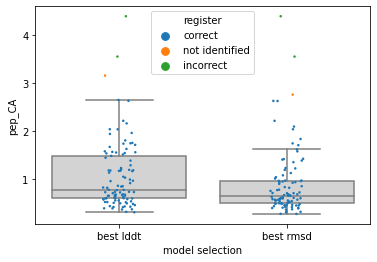

[0.3960396  0.04950495 0.05940594 0.        ]


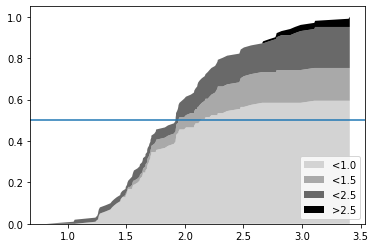

II
best lddt : fails:  0, regerr:  1
best rmsd : fails:  0, regerr:  0
median:
best lddt : pep_CA: 0.46, pep_all: 1.07, mhc_CA: 0.43, mhc_all: 1.10
best rmsd : pep_CA: 0.41, pep_all: 1.04, mhc_CA: 0.41, mhc_all: 1.07
mean:
best lddt : pep_CA: 0.81, pep_all: 1.63, mhc_CA: 0.51, mhc_all: 1.19
best rmsd : pep_CA: 0.48, pep_all: 1.20, mhc_CA: 0.46, mhc_all: 1.14


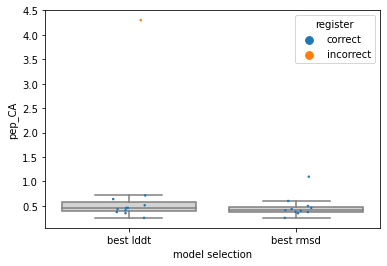

[0.54545455 0.         0.         0.        ]


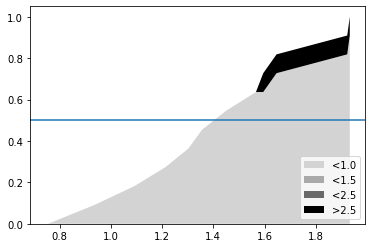

In [10]:
#analyze for all species

df_lddt_save={}
for cl in ['I','II']:
    print(cl)
    df0=result_df[result_df['class']==cl].copy()
    df_lddt=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'score',how='min')
    df_lddt=df_lddt.reset_index(drop=True)
    df_lddt_save[cl]=df_lddt
    df_rmsd=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'pep_CA',how='min')
    df_rmsd=df_rmsd.reset_index(drop=True)    
    summarize_results([df_lddt,df_rmsd],['best lddt','best rmsd'])
    make_hill_plot(df_lddt['pep_CA'],df_lddt['score'],[1.,1.5,2.5])#,xticks=None,xlim=None,loc=None)    

# PANDORA

it would be best to use their pipeline to run netmhc and parse anchors from that; however, their pipeline can only handle mhc input via allele, not via sequence; there are two problems:
1. many of our mhcs have mutations or are misidentified;
2. I don't know how they will parse mouse alleles
3. would have to run netmhc once per input
therefore, use my version netmhc anchor prediction, but verify manually in regerr cases that netmhc core was interpreted correctly

In [42]:
cd /data/vmikhayl/tfold

/data/vmikhayl/tfold


## load my test set

In [43]:
#pmhc seq clusters selected for modeling
print('pmhcs seq clusters filtered')
with open(source_dir+'/pmhcs_seq_clusters_filtered.pckl','rb') as f:
    pmhcs_filtered=pickle.load(f) #seq clusters filtered
print(len(pmhcs_filtered))
print(pmhcs_filtered[0].keys())

#make dataframes
df=pd.DataFrame(pmhcs_filtered)
def _map_pep(x):    
    return ''.join(pmhcs[x]['P']['data']['seq'])
def _map_mhc_a(x):    
    return seq_tools.load_NUMSEQ(pmhcs[x]['M'])
def _map_mhc_b(x):    
    if 'N' in pmhcs[x]:
        return seq_tools.load_NUMSEQ(pmhcs[x]['N'])
    else:
        return None
df['pmhc_id']=df['pmhc_ids'].map(lambda x:x[0]) #keep id of the pmhc we model
df['pdb_id']=df['pmhc_id'].map(lambda x:pmhcs[x]['pdbs'][0][0])
df=df.drop(['pmhc_ids'],axis=1)
df=df.drop(['pdbs'],axis=1)
for k in ['class','tails','netmhc_tails','netmhc_kd']:
    df[k]=df['pmhc_id'].map(lambda x: pmhcs[x][k])
df['pep']=df['pmhc_id'].map(_map_pep)
df['mhc_a']=df['pmhc_id'].map(_map_mhc_a)
df['mhc_b']=df['pmhc_id'].map(_map_mhc_b)

#drop train
df=df[df['date']>date_cutoff]
print('after cutoff:',len(df))
#tail statistics for cl 1
x=df[df['class']=='I']
print('cl 1:',len(x))
print('non trivial tails in cl 1:',np.sum(x['tails']!=(0,0)))
print('netmhc errors in cl 1:',np.sum(x['tails']!=x['netmhc_tails']))
x=df[df['class']=='II']
print('cl 2:',len(x))
print('netmhc errors in cl 2:',np.sum(x['tails']!=x['netmhc_tails']))

df_target=df
df_target=df_target.rename({'id':'cluster_seq'},axis=1) #that's what it is
df_target=df_target[df_target.columns[[4,0,3,2,1,5,6,7,8,9,10]]]
df_target=df_target.sort_values(['class','cluster_seq','pmhc_id','pdb_id'])
df_target=df_target.reset_index(drop=True)

df_target=df_target[df_target['class']=='I'] #restrict to cl I

print(len(df_target))
print(df_target.columns)

pmhcs seq clusters filtered
444
dict_keys(['id', 'pmhc_ids', 'pdbs', 'date'])
after cutoff: 112
cl 1: 101
non trivial tails in cl 1: 3
netmhc errors in cl 1: 3
cl 2: 11
netmhc errors in cl 2: 7
101
Index(['class', 'cluster_seq', 'pdb_id', 'pmhc_id', 'date', 'tails',
       'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b'],
      dtype='object')


In [44]:
#add mhc alleles in PANDORA format

def _map_species_to_pandora(x):
    if x=='9606':
        return 'HLA'
    elif x=='10090':
        return 'H2'    
    else:
        x=seq_tools.species[x]
        if x[1]:
            return x[1]
        if x[0]:
            return x[0][0].upper()+x[0][1:]
        else:
            return x
def _map_mhc_to_pandora(x):
    s=_map_species_to_pandora(x['species'])
    l,a=x['locus'],x['allele']
    if s=='H2':
        return '{}-{}{}'.format(s,l,a)  #H2-Ld
    else:
        return '{}-{}*{}'.format(s,l,a) #HLA-A*02:01

df_target['mhc_pandora']=df_target['mhc_a'].map(lambda x: _map_mhc_to_pandora(x.info))
my_mhcs=df_target['mhc_pandora'].unique()
    
pandora_alleles=[]
with open('./PANDORA/PANDORA_files/data/csv_pkl_files/NonHuman_MHC_data.fasta') as f:
    s=[x[1:] for x in f.read().split('\n') if x.startswith('>')]
pandora_alleles+=s
print('nonhuman alleles in pandora:',len(s))
with open('./PANDORA/PANDORA_files/data/csv_pkl_files/Human_MHC_data.fasta') as f:
    s=[x[1:] for x in f.read().split('\n') if x.startswith('>')]
pandora_alleles+=s
print('human alleles in pandora:',len(s))

missing_alleles=[x for x in my_mhcs if x not in pandora_alleles]
print('my alleles:',len(my_mhcs))
print('missing mhcs:',len(missing_alleles))
print(missing_alleles)

nonhuman alleles in pandora: 4544
human alleles in pandora: 6596
my alleles: 41
missing mhcs: 8
['SLA-1*04:01', 'H2-Ld', 'H2-Kb', 'Gaga-BF2*015:01', 'Onmy-UBA*14:01', 'H2-Db', 'H2-Dd', 'Rano-A*av1']


In [45]:
#restrict target to human and mouse, since for them and only for them can Pandora find templates
print('all species:',len(df_target))
df_target=df_target[df_target['mhc_pandora'].map(lambda x: x.startswith(('HLA-','H2-')))]
print('human and mouse:',len(df_target))

all species: 101
human and mouse: 81


## look at pandora pdbs and species

In [37]:
pandora_date='2021-03-23' #when pandora dataset was generated, according to https://github.com/X-lab-3D/PANDORA

In [63]:
#compare pdb sets

p_pdbs=set([x.split('.')[0].lower() for x in os.listdir('./PANDORA/PANDORA_files/data/PDBs/pMHCI')])
print(len(p_pdbs))

my_pdbs={'pdb':[],'pdb_short':[],'date':[]}
for k,v in summary.items():
    if ('P' in v) and ('N' not in v): #cl I pmhc
        my_pdbs['pdb'].append(k)
        my_pdbs['pdb_short'].append(k.split('_')[0])
        my_pdbs['date'].append(v['date'])
my_pdbs=pd.DataFrame(my_pdbs)
my_pdbs=my_pdbs[my_pdbs['date']<=pandora_date] #restrict to before pandora date

my_pdbs_set=set(list(my_pdbs['pdb_short'].unique()))
print(len(my_pdbs_set))

my_pdb_source=set([x.split('.')[0].lower() for x in os.listdir('./data/experimental_structures/pdb_source')])

p_missing=my_pdbs_set-p_pdbs
my_missing=p_pdbs-my_pdbs_set
my_source_missing=p_pdbs-my_pdb_source
pdb_intersection=p_pdbs&my_pdbs_set
print('missing in my dataset:',len(my_missing))
print('missing in my pdb source:',len(my_source_missing))
print('missing in PANDORA dataset:',len(p_missing))
print('present in both:',len(pdb_intersection))

#all 10 that are missing in my source are obsolete; checked a couple others: have short pep

835
1006
missing in my dataset: 16
missing in my pdb source: 10
missing in PANDORA dataset: 187
present in both: 819


In [66]:
#species, hetero pep, pep gaps for structures missing from pandora
species_for_missing=[]
pep_hetero_status=[]
pep_gaps=[]
for k in p_missing:
    for s in summary:
        if ('P' in summary[s]) and s.startswith(k):
            species_for_missing.append(summary[s]['M']['info']['species'])
            pep_hetero_status.append(summary[s]['pep_hetero'])
            pep_gaps.append(len(summary[s]['P']['info']['gaps']))
            break
print('species in pdbs missing from pandora:')
utils.print_hist(species_for_missing)
print('by pep hetero status:')
utils.print_hist(pep_hetero_status)
print('by pep gaps:')
utils.print_hist(pep_gaps)

#species in structures present in pandora
species_present=[]
for k in pdb_intersection:
    for s in summary:
        if ('P' in summary[s]) and s.startswith(k):
            species_present.append(summary[s]['M']['info']['species'])
            break
print('species present in pandora:')
utils.print_hist(species_present)

#species in my test set
def _get_species(x):
    return x.info['species']
print('species in my test set:')
utils.print_hist(df_target['mhc_a'].map(_get_species))

#conclusion: all species from my test set except for one are present in pandora dataset;
#the one missing is 9545, but 9544 present (two kinds of macaques)

species in pdbs missing from pandora:
10090  51
8022    1
9031    3
9544    3
9545    2
9606  123
9796    2
9823    2
by pep hetero status:
0 131
1  20
2  36
by pep gaps:
0 187
species present in pandora:
10090 167
10116   5
8022    3
9031   18
9531    8
9541    1
9544    2
9606  592
9796    5
9823   13
9913    5
species in my test set:
10090  9
10116  1
8022   1
9031   3
9544   3
9545   1
9606  72
9796   2
9823   9


## run PANDORA

In [6]:
from PANDORA.PMHC import PMHC
from PANDORA.Pandora import Pandora
from PANDORA.Database import Database
#importlib.reload(Pandora)

In [7]:
#load db
t0=time.time()
db=Database.load('./PANDORA/PANDORA_files/data/csv_pkl_files/database_c.pkl')
db.repath('/data/vmikhayl/tfold/PANDORA/PANDORA_files/data/PDBs',save='/data/vmikhayl/tfold/PANDORA/PANDORA_files/data/csv_pkl_files/database_repath.pkl')
print('db loaded in {} s'.format(time.time()-t0))

#delete structures after date cutoff
pandora_pdb_dir='./PANDORA/PANDORA_files/data/PDBs/pMHCI'
t0=time.time()
pdbs_to_delete=set()
for filename in os.listdir(pandora_pdb_dir):
    structure,header=pdb_tools.parse_pdb(pandora_pdb_dir+'/'+filename)
    c_date=header.get('deposition_date') #yyyy-mm-dd (Bio.PDB parses into this format)
    if c_date>date_cutoff:
        pdb_id=filename.split('.')[0]
        pdbs_to_delete.add(pdb_id)
        db.remove_structure(id=pdb_id)
print('completed in {:4.1f} s'.format(time.time()-t0))
print('removed {} pdbs'.format(len(pdbs_to_delete)))

db loaded in 44.85869288444519 s
completed in 47.4 s
removed 104 pdbs


In [46]:
from Bio import pairwise2

def run_pandora(c_id,pep,mhc_allele,anchors,mhc_seq,coutput_dir):
    target=PMHC.Target(id=c_id,
                       allele_type=[mhc_allele],
                       peptide=pep,
                       anchors=anchors,
                       M_chain_seq=mhc_seq)
    case=Pandora.Pandora(target, db,output_dir=coutput_dir)
    case.model()
def pandora_rmsd(pdb_filename,true_pdb_filename,mhc_pdbnum,mhc_seq):    
    structure,_=pdb_tools.parse_pdb(pdb_filename,'modeled')
    pepseq=''.join([pdb_tools.aa_dict.get(x.get_resname(),'X') for x in structure['P'].get_residues()])    
    structure_dict=pdb_tools.get_structure_dict(structure,False)
    pdbnum_current=['P'+x for x in structure_dict['P'].keys()] 
    mhc_pdbnum_model=['M'+x for x in structure_dict['M'].keys()] 
    mhc_seq_model=''.join([pdb_tools.aa_dict[x.get_resname()] for x in structure['M'].get_residues()])
    s=re.search(mhc_seq_model,mhc_seq)
    if not s:
        raise ValueError(f'model mhc sequence not within target mhc sequence for {pdb_filename}')
    i1,i2=s.start(),s.end()
    mhc_pdbnum=mhc_pdbnum[i1:i2]
    
    structure_ref,_=pdb_tools.parse_pdb(true_pdb_filename,'true')
    pepseq_ref=''.join([pdb_tools.aa_dict[x.get_resname()] for x in structure_ref['P'].get_residues()])
    structure_ref_dict=pdb_tools.get_structure_dict(structure_ref,False)
    pdbnum_true=['P'+x for x in structure_ref_dict['P'].keys()]
    mhc_pdbnum_ref=['M'+x for x in structure_ref_dict['M'].keys()]
    
    mhc_pdbnum_shared=set(mhc_pdbnum_ref)&set(mhc_pdbnum)
    mhc_resmap=[[a,b] for a,b in zip(mhc_pdbnum_model,mhc_pdbnum) if b in mhc_pdbnum_shared]        
    print(f'mhc resmap of len {len(mhc_resmap)} for {pdb_filename}')
    pdb_tools.superimpose_by_resmap(structure,structure_ref,mhc_resmap,CA_only=True,verbose=False)
    #align peptide sequences, make resmap                    
    y=pairwise2.align.globalms(pepseq,pepseq_ref,match=1,mismatch=-1,open=-1,extend=-1)[0]
    i1,i2=0,0
    resmap=[]
    for i,x in enumerate(zip(y.seqA,y.seqB)):
        if x[0]!='-' and x[1]!='-':
            resmap.append([pdbnum_current[i1],pdbnum_true[i2]])
        if x[0]!='-':
            i1+=1
        if x[1]!='-':
            i2+=1
    print(f'pep resmap of len {len(resmap)} for {pdb_filename}')
    pep_rmsd=pdb_tools.rmsd_by_resmap(structure,structure_ref,resmap,allow_missing_res=True,verbose=False)
    mhc_rmsd=pdb_tools.rmsd_by_resmap(structure,structure_ref,mhc_resmap,verbose=False) 
    return {'pep_CA':pep_rmsd['CA'],'pep_all':pep_rmsd['all'],'mhc_CA':mhc_rmsd['CA'],'mhc_all':mhc_rmsd['all']}    

def model_one_entry(x):
    result={}
    c_id=str(x['pmhc_id'])
    coutput_dir=f'/scratch/vmikhayl/pmhc_modeling/pandora1/outputs/{c_id}'
    tails=x['netmhc_tails']
    anchors=[2+tails[0],len(x['pep'])-tails[1]]
    result.update({'netmhc_anchors':anchors})
    #do modeling
    run_pandora(c_id,x['pep'],x['mhc_pandora'],anchors,x['mhc_a'].seq(),coutput_dir)
    #choose model
    d=os.listdir(coutput_dir)
    if len(d)!=1:
        raise ValueError(f'check output dir for id {c_id}')
    d=d[0]
    pandora_template=d.split('_')[-1]
    result.update({'pandora_template':pandora_template})
    modeller_result=pd.read_csv(coutput_dir+f'/{d}/molpdf_DOPE.tsv',sep='\t',names=['pdb','molpdf','DOPE'])
    best_structure=modeller_result.iloc[0]
    result.update({k:best_structure[k] for k in ['molpdf','DOPE']})
    best_pdb=best_structure['pdb']
    #compute rmsd
    mhc_pdbnum=['M'+a for a in x['mhc_a'].data['pdbnum']]
    mhc_seq=x['mhc_a'].seq()
    result.update(pandora_rmsd(coutput_dir+'/'+d+'/'+best_pdb,source_dir+'/pdb/'+x['pdb_id']+'.pdb',
                              mhc_pdbnum,mhc_seq))
    with open(coutput_dir+'/result.pckl','wb') as f:
        pickle.dump(result,f)    

In [47]:
from multiprocessing import Pool

n_cpus=12
target_list=[x[1] for x in df_target.iterrows()]
#target_list=target_list[:10] ##REMOVE

t0=time.time()
with Pool(n_cpus) as p:
    print(p.map(model_one_entry,target_list))
print('all done in {} s'.format(time.time()-t0))
#all done in 1166.6932706832886 s


Modelling 3...

Modelling 28...


Modelling 19...

Modelling 42...
	Target MHC Class: I
Modelling 55...

Modelling 68...

Modelling 94...

Modelling 117...







Modelling 123...

Modelling 129...

Modelling 140...

	Target MHC Class: I
Modelling 147...

	Target MHC Class: I	Target Allele:  ['HLA-B*53:01']	Target MHC Class: I	Target MHC Class: I	Target MHC Class: I


	Target MHC Class: I

	Target MHC Class: I




	Target MHC Class: I	Target MHC Class: I	Target MHC Class: I
	Target Allele:  ['HLA-B*27:03']
	Target MHC Class: I	Target Allele:  ['HLA-A*02:01']	Target Peptide: QASQEVKNW	Target Allele:  ['H2-Kb']	Target Allele:  ['HLA-B*37:01']	Target Allele:  ['HLA-C*08:02']


	Target Allele:  ['HLA-A*24:02']



	Target Allele:  ['HLA-A*02:01']


	Target Allele:  ['HLA-A*02:01']	Target Allele:  ['HLA-A*02:01']
	Target Allele:  ['HLA-C*01:02']	Target Peptide: LRNQSVFNF
	Target Anchors: 2,9
	Target Peptide: IIGWMWIPV	Target Allele:  ['HLA-B*15:02']	Target Peptide: SIIVFNLV	Target Peptide: 

	94.BL00120001		17.6004
	94.BL00010001		18.124
	94.BL00080001		22.3018
	94.BL00020001		23.7247
	94.BL00030001		24.0099
	94.BL00110001		24.9563
	Successfully modelled 20 models
mhc resmap of len 182 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/94/94_3L3D/94.BL00060001.pdb
pep resmap of len 9 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/94/94_3L3D/94.BL00060001.pdb
Chain M, excess N 0, C 0
	Successfully created alignment file

Modelling 101...

	Target MHC Class: I
	Target Allele:  ['HLA-B*07:02']
	Target Peptide: IPRRNVATL
	Target Anchors: 2,9

	Using allele type based template selection
	Selected template structure (1): ['4U1S']
	Templates Allele:  [['HLA-B*0702', 'HLA-B*0704', 'HLA-B*0705', 'HLA-B*0706', 'HLA-B*0707', 'HLA-B*0709', 'HLA-B*0712', 'HLA-B*0714', 'HLA-B*0717', 'HLA-B*0718', 'HLA-B*0719', 'HLA-B*0720', 'HLA-B*0722', 'HLA-B*0724', 'HLA-B*0725', 'HLA-B*0726', 'HLA-B*0728', 'HLA-B*4201', 'HLA-B*4204', 'HLA-B*5510', 'HLA-B*6701', 'HLA-B*8101', 'HLA-B*0734', 'HL


###############
TEMPLATE:  4F7T
Chain M, excess N 0, C 0
	Successfully created alignment file

	Modelling was successfull and took 108.52 seconds

	Model				Molpdf
	85.BL00140001		1.3628
	85.BL00200001		8.8714
	85.BL00090001		9.2891
	85.BL00020001		10.0162
	85.BL00070001		10.8276
	85.BL00190001		12.1892
	85.BL00010001		12.8235
	85.BL00170001		12.9082
	85.BL00180001		13.0307
	85.BL00110001		13.6111
	85.BL00050001		15.0623
	85.BL00080001		15.1786
	85.BL00030001		16.0212
	85.BL00040001		16.052
	85.BL00120001		16.9999
	85.BL00160001		17.154
	85.BL00130001		19.8137
	85.BL00150001		20.5877
	85.BL00060001		43.9463
	85.BL00100001		375.5695
	Successfully modelled 20 models
mhc resmap of len 182 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/85/85_1X7Q/85.BL00140001.pdb
pep resmap of len 9 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/85/85_1X7Q/85.BL00140001.pdb

Modelling 320...

	Target MHC Class: I
	Target Allele:  ['HLA-B*07:02']
	Target Peptide: SPKLHFYYL
	Target Anchors: 2,9

	Templates Peptide: ['EADPTGHSY']
	Templates Anchors: [[2, 9]]

###############
TEMPLATE:  1W72
Chain M, excess N 0, C 0
	Successfully created alignment file
	Successfully created the initital model
	Calculating peptide anchor residue constraints...
	Performing homology modelling of 273 on 1W72...

	Modelling was successfull and took 137.02 seconds

	Model				Molpdf
	207.BL00030001		1.5699
	207.BL00110001		2.3215
	207.BL00090001		3.8702
	207.BL00150001		4.3822
	207.BL00130001		5.2086
	207.BL00200001		5.3335
	207.BL00080001		7.303
	207.BL00140001		7.8453
	207.BL00050001		7.9672
	207.BL00100001		8.0965
	207.BL00010001		8.842
	207.BL00120001		9.1855
	207.BL00170001		10.0251
	207.BL00040001		12.5488
	207.BL00070001		16.2345
	207.BL00180001		17.2696
	207.BL00160001		18.5252
	207.BL00060001		23.9646
	207.BL00190001		30.3496
	207.BL00020001		224.8168
	Successfully modelled 20 models
mhc resmap of len 182 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/207/207_1XR9/207.BL00030001.pdb
pep 

	Successfully created alignment file
	Successfully created the initital model
	Calculating peptide anchor residue constraints...
	Performing homology modelling of 525 on 6D29...

	Modelling was successfull and took 120.02 seconds

	Model				Molpdf
	372.BL00130001		-4.0633
	372.BL00010001		-2.1053
	372.BL00180001		-1.6894
	372.BL00030001		1.5736
	372.BL00200001		7.8025
	372.BL00020001		10.2116
	372.BL00110001		11.472
	372.BL00140001		11.6171
	372.BL00060001		12.7836
	372.BL00040001		13.4647
	372.BL00090001		13.5688
	372.BL00070001		14.4443
	372.BL00170001		16.8963
	372.BL00080001		18.1765
	372.BL00190001		20.4258
	372.BL00100001		21.0428
	372.BL00150001		21.0966
	372.BL00050001		25.0182
	372.BL00160001		27.4577
	372.BL00120001		41.1989
	Successfully modelled 20 models
mhc resmap of len 182 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/372/372_3BZF/372.BL00130001.pdb
pep resmap of len 9 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/372/372_3BZF/372.BL00130001.pdb

Modelling

	Templates Allele:  [['HLA-A*0101', 'HLA-A*0103', 'HLA-A*0106', 'HLA-A*0108', 'HLA-A*3601', 'HLA-A*3602', 'HLA-A*3603', 'HLA-A*0110', 'HLA-A*0112', 'HLA-A*0114', 'HLA-A*3604', 'HLA-A*0119', 'HLA-A*0125', 'HLA-A*0121', 'HLA-A*0126', 'HLA-A*0130', 'HLA-A*0132', 'HLA-A*0137', 'HLA-A*0135', 'HLA-A*0138', 'HLA-A*0136', 'HLA-A*0142', 'HLA-A*0144', 'HLA-A*0145', 'HLA-A*0140', 'HLA-A*0139', 'HLA-A*0141', 'HLA-A*0155', 'HLA-A*0146', 'HLA-A*0154', 'HLA-A*0148', 'HLA-A*3605', 'HLA-A*0150', 'HLA-A*0149', 'HLA-A*0101', 'HLA-A*0132', 'HLA-A*0137', 'HLA-A*0145']]
	Templates Peptide: ['CTELKLSDY']
	Templates Anchors: [[2, 9]]

###############
TEMPLATE:  4NQV
Chain M, excess N 0, C 0
	Successfully created alignment file
	Successfully created the initital model
	Calculating peptide anchor residue constraints...
	Performing homology modelling of 583 on 4NQV...

	Modelling was successfull and took 142.34 seconds

	Model				Molpdf
	525.BL00150001		15.7697
	525.BL00080001		19.2211
	525.BL00010001		19.9263
	

	Calculating peptide anchor residue constraints...
	Performing homology modelling of 747 on 1WBX...

	Modelling was successfull and took 142.16 seconds

	Model				Molpdf
	583.BL00070001		-7.5758
	583.BL00140001		-5.9268
	583.BL00110001		-4.363
	583.BL00190001		-0.2011
	583.BL00040001		1.6071
	583.BL00150001		2.1953
	583.BL00060001		4.1751
	583.BL00200001		5.1227
	583.BL00020001		5.3723
	583.BL00160001		5.4794
	583.BL00170001		6.773
	583.BL00180001		7.2916
	583.BL00010001		8.3837
	583.BL00100001		9.4974
	583.BL00130001		10.4415
	583.BL00030001		14.0408
	583.BL00050001		15.1923
	583.BL00120001		20.8177
	583.BL00080001		24.2045
	583.BL00090001		31.2759
	Successfully modelled 20 models
mhc resmap of len 182 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/583/583_4NQV/583.BL00070001.pdb
pep resmap of len 9 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/583/583_4NQV/583.BL00070001.pdb

Modelling 833...

	Target MHC Class: I
	Target Allele:  ['HLA-A*02:01']
	Target Peptide: SLSKILD

	Successfully modelled 20 models
mhc resmap of len 182 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/662/662_4ZEZ/662.BL00200001.pdb
pep resmap of len 10 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/662/662_4ZEZ/662.BL00200001.pdb

	Modelling was successfull and took 124.17 seconds

	Model				Molpdf
	782.BL00140001		4.1582
	782.BL00040001		4.6582
	782.BL00070001		6.7761
	782.BL00180001		7.6541
	782.BL00190001		8.0126
	782.BL00060001		8.4129
	782.BL00010001		9.3638
	782.BL00030001		9.788
	782.BL00160001		10.0607
	782.BL00120001		10.6863
	782.BL00080001		13.4079
	782.BL00050001		14.269
	782.BL00200001		15.0636
	782.BL00110001		16.4777
	782.BL00170001		16.7105
	782.BL00090001		19.3154
	782.BL00100001		19.3635
	782.BL00150001		19.6228
	782.BL00020001		20.487
	782.BL00130001		42.0726
	Successfully modelled 20 models
mhc resmap of len 182 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/782/782_4NO3/782.BL00140001.pdb
pep resmap of len 9 for /scratch/vmikhayl/pmhc_modeling

	861.BL00080001		8.9361
	861.BL00110001		11.758
	861.BL00190001		11.8226
	861.BL00060001		12.1713
	861.BL00010001		12.1984
	861.BL00070001		14.18
	861.BL00030001		34.5524
	861.BL00040001		49.9782
	Successfully modelled 20 models
mhc resmap of len 182 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/861/861_1I4F/861.BL00180001.pdb
pep resmap of len 10 for /scratch/vmikhayl/pmhc_modeling/pandora1/outputs/861/861_1I4F/861.BL00180001.pdb
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
all done in 1166.6932706832886 s


In [48]:
pandora_results={}
for d in os.listdir('/scratch/vmikhayl/pmhc_modeling/pandora1/outputs'):
    if 'result.pckl' in os.listdir('/scratch/vmikhayl/pmhc_modeling/pandora1/outputs/'+d):
        with open('/scratch/vmikhayl/pmhc_modeling/pandora1/outputs/'+d+'/result.pckl','rb') as f:
            r=pickle.load(f)
            r.update({'pmhc_id':int(d)})
        for k,v in r.items():
            pandora_results.setdefault(k,[]).append(v)        
    else:
        print(d)
pandora_results=pd.DataFrame(pandora_results)
pandora_results=pd.merge(df_target,pandora_results,left_on='pmhc_id',right_on='pmhc_id')
print(len(pandora_results))
print(pandora_results.columns)

81
Index(['class', 'cluster_seq', 'pdb_id', 'pmhc_id', 'date', 'tails',
       'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b', 'mhc_pandora',
       'netmhc_anchors', 'pandora_template', 'molpdf', 'DOPE', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all'],
      dtype='object')


In [49]:
#mhc distance to template
def _mhc_edit_distance(x):
    mhc1=''.join(summary[x['pdb_id']]['M']['data']['seq']).upper()
    pdb_id2_short=x['pandora_template'].lower()
    for i in range(10):
        pdb_id2=pdb_id2_short+f'_{i}'
        if pdb_id2 in summary:
            break
    if pdb_id2 not in summary:
        return -10
    mhc2=''.join(summary[pdb_id2]['M']['data']['seq']).upper()
    return template_tools.edit_distance(mhc1,mhc2)
pandora_results['mhc_edit_distance']=pandora_results.apply(_mhc_edit_distance,axis=1)
print(pandora_results['mhc_edit_distance'].value_counts().sort_index())
#alleles with poor template mhc match
df=pandora_results[pandora_results['mhc_edit_distance']>10] #entries with poor template mhc match
print(df.apply(lambda x: (x['mhc_a'].info['species'],x['mhc_a'].info['locus'],x['mhc_a'].info['allele'],x['mhc_edit_distance']),axis=1))
print(df['pep_CA'])

-10     2
 0     41
 1     11
 2      7
 3      2
 4      1
 5      4
 7      1
 8      1
 9      1
 12     1
 14     1
 15     3
 18     2
 34     1
 38     1
 43     1
Name: mhc_edit_distance, dtype: int64
6        (10090, K, b, 34)
7        (10090, K, b, 38)
12    (9606, B, 37:01, 15)
20    (9606, C, 01:02, 43)
27       (10090, L, d, 15)
34    (9606, B, 07:02, 15)
35    (9606, A, 30:03, 14)
51    (9606, A, 30:03, 18)
64    (9606, A, 30:03, 18)
79    (9606, A, 30:01, 12)
dtype: object
6     2.002340
7     0.983894
12    1.466560
20    1.600247
27    1.673746
34    2.855103
35    2.163376
51    2.117458
64    1.869650
79    1.908433
Name: pep_CA, dtype: float64


median:
pandora best score: pep_CA: 1.48, pep_all: 2.63, mhc_CA: 0.56, mhc_all: 1.31
mean:
pandora best score: pep_CA: 1.47, pep_all: 2.66, mhc_CA: 0.60, mhc_all: 1.33
[0.16049383 0.09876543 0.22222222 0.02469136]


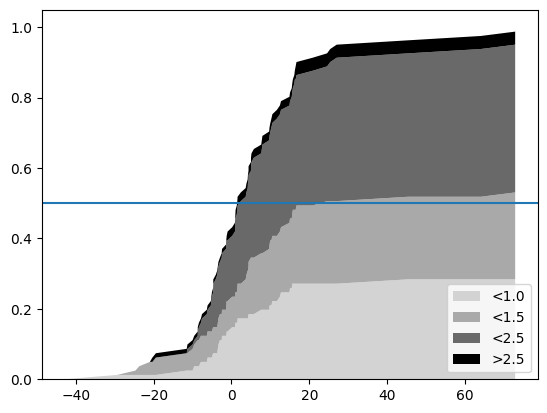

In [56]:
#hill_colors=['rosybrown','lightcoral','indianred','brown','maroon']
hill_colors=['lightgray','darkgray','dimgray','black']
def make_hill_plot(rmsds,scores,rmsd_bins,xticks=None,xlim=None,loc=None,return_frac=False): 
    rmsd_bins_ext=[0.]+rmsd_bins+[10000.]
    scores=np.array(scores)
    score_bins=np.sort(np.unique(scores))
    score_bins=[0.99*score_bins[0]]+list(score_bins)+[1.01*score_bins[-1]]    
    counts=[]
    for s in score_bins:        
        r=rmsds[scores<s]
        counts.append([np.sum((r>=rmsd_bins_ext[i])&(r<rmsd_bins_ext[i+1])) for i in range(len(rmsd_bins_ext)-1)])
    counts=np.stack(counts).T/len(rmsds) #fractions, (n_groups,n_score_thresholds)
    counts_at_half=counts[:,np.sum(counts,axis=0)>0.5][:,0]
    if return_frac:
        return counts_at_half
    print(counts_at_half) #fractions for threshold when half models pass
    plt.figure()
    plt.stackplot(np.log(score_bins),counts,colors=hill_colors[:len(rmsd_bins)+1])            
    if not (xlim is None):
        plt.xlim(np.log(xlim))
        if not (xticks is None):
            xticks=xticks[(xticks>=xlim[0])&(xticks<=xlim[1])]
    if not (xticks is None):
        plt.xticks(np.log(xticks),xticks)
    loc=loc or 'lower right'
    plt.legend([f'<{r}' for r in rmsd_bins]+[f'>{rmsd_bins[-1]}'],loc=loc)
    plt.axhline(0.5)
    plt.show()
    
good_df_list,names_list=[pandora_results],['pandora best score']
for name, df in zip(names_list,good_df_list):
    print('median:')
    s=[]
    for k in ['pep_CA','pep_all','mhc_CA','mhc_all']:
        s.append('{:s}: {:4.2f}'.format(k,df[k].median()))
    print('{:10s}: '.format(name)+', '.join(s))        
    print('mean:')
    s=[]
    for k in ['pep_CA','pep_all','mhc_CA','mhc_all']:
        s.append('{:s}: {:4.2f}'.format(k,df[k].mean()))
    print('{:10s}: '.format(name)+', '.join(s))        
    #plt.figure()
    #sns.boxplot(data=df,y='pep_CA')#,x='model selection',color='lightgray',fliersize=0)
    #sns.stripplot(data=df,y='pep_CA')#,x='model selection',hue='register',marker='.')
    #plt.show()

make_hill_plot(pandora_results['pep_CA'],np.exp(pandora_results['molpdf']),[1.,1.5,2.5])#,xticks=None,xlim=None,loc=None)    

#previous run
#pandora best score: pep_CA: 1.47, pep_all: 2.66, mhc_CA: 0.60, mhc_all: 1.33
#[0.16049383 0.09876543 0.22222222 0.02469136]

#new run
#pandora best score: pep_CA: 1.47, pep_all: 2.66, mhc_CA: 0.60, mhc_all: 1.33
#[0.16049383 0.09876543 0.22222222 0.02469136]
#looks like it is deterministic! o_O

In [51]:
pandora_results[pandora_results['pep_CA']>2.]
#pmhc_id 601 inspected pdbs: anchors correct; right tail pointing in wrong direction, hence high rmsd;
#in AF model, tail is much better and rmsd is 1.39, compared to 5.39 for pandora

#prev run:11

,class,cluster_seq,pdb_id,pmhc_id,date,tails,netmhc_tails,netmhc_kd,pep,mhc_a,...,mhc_pandora,netmhc_anchors,pandora_template,molpdf,DOPE,pep_CA,pep_all,mhc_CA,mhc_all,mhc_edit_distance
6,I,42,6jq2_0,42,2019-03-28,"(0, 0)","(0, 0)",34.400376,SIIVFNLV,<tfold.utils.seq_tools.NUMSEQ object at 0x7fcb...,...,H2-Kb,"[2, 8]",1FFP,72.92717,-1177.79614,2.002340,4.256002,0.837480,1.670523,34
8,I,54,6ulk_0,55,2019-04-11,"(0, 0)","(0, 0)",474.311241,GADGVGKSAL,<tfold.utils.seq_tools.NUMSEQ object at 0x7fcb...,...,HLA-C*08:02,"[2, 10]",5VGD,-20.99023,-661.67944,2.590921,4.154107,1.071797,1.879326,3
17,I,106,6vpz_0,126,2019-07-30,"(0, 0)","(0, 0)",115.946468,KRWIILGLNKI,<tfold.utils.seq_tools.NUMSEQ object at 0x7fcc...,...,HLA-B*27:05,"[2, 11]",4G8I,10.51465,-1607.41357,2.271671,2.933520,0.275690,0.956287,0
34,I,240,6uj7_0,349,2019-10-02,"(0, 0)","(0, 0)",124.663875,SPNGTIQNIL,<tfold.utils.seq_tools.NUMSEQ object at 0x7fcc...,...,HLA-B*07:02,"[2, 10]",4O2E,-1.23705,-1033.46643,2.855103,3.731949,0.857799,1.729823,15
35,I,246,6j1v_0,357,2018-12-29,"(0, 0)","(0, 0)",8777.596801,AIFQSSMTK,<tfold.utils.seq_tools.NUMSEQ object at 0x7fcc...,...,HLA-A*30:03,"[2, 9]",1Q94,7.79452,-995.88544,2.163376,2.802491,0.435701,1.139205,14
41,I,282,7s8q_0,433,2021-09-19,"(0, 0)","(0, 0)",11.978808,KTNGNAFIGK,<tfold.utils.seq_tools.NUMSEQ object at 0x7fcc...,...,HLA-A*11:01,"[2, 10]",5GRD,0.17986,-864.54779,2.279888,3.377766,0.429925,1.182026,0
51,I,354,6j2a_0,583,2018-12-31,"(0, 0)","(0, 0)",533.681552,CTELKLSDY,<tfold.utils.seq_tools.NUMSEQ object at 0x7fcc...,...,HLA-A*30:03,"[2, 9]",4NQV,-7.57580,-756.78314,2.117458,3.515868,0.540662,1.317819,18
54,I,364,6zkx_0,601,2020-06-30,"(0, 3)","(0, 3)",26666.121102,RLPAKAPLLGCG,<tfold.utils.seq_tools.NUMSEQ object at 0x7fcc...,...,HLA-E*01:03,"[2, 9]",3BZF,16.27730,-988.28186,5.392097,4.984343,1.475392,1.930962,2
56,I,385,7r7y_0,643,2021-06-25,"(0, 0)","(0, 0)",360.337598,QATQEVKNW,<tfold.utils.seq_tools.NUMSEQ object at 0x7fcc...,...,HLA-B*57:01,"[2, 9]",2RFX,-11.52255,-848.03711,2.166406,4.022972,0.418419,1.245181,0
69,I,430,7kgr_0,782,2020-10-18,"(0, 0)","(0, 0)",3069.768605,LQLPQGTTL,<tfold.utils.seq_tools.NUMSEQ object at 0x7fcc...,...,HLA-A*02:01,"[2, 9]",4NO3,4.15818,-878.08441,2.300255,3.040405,0.613289,1.384298,0


In [53]:
df_tsv=pandora_results[['pmhc_id','pdb_id','pep','mhc_pandora','netmhc_anchors','molpdf','pep_CA','pep_all','pandora_template','mhc_edit_distance']].copy()
df_tsv=df_tsv.rename({'pep':'peptide','mhc_pandora':'mhc','netmhc_anchors':'anchors','pep_CA':'backbone_LRMSD','pep_all':'full_atom_LRMSD'},axis=1)
df_tsv['pdb_id']=df_tsv['pdb_id'].map(lambda x:x.split('_')[0].upper())

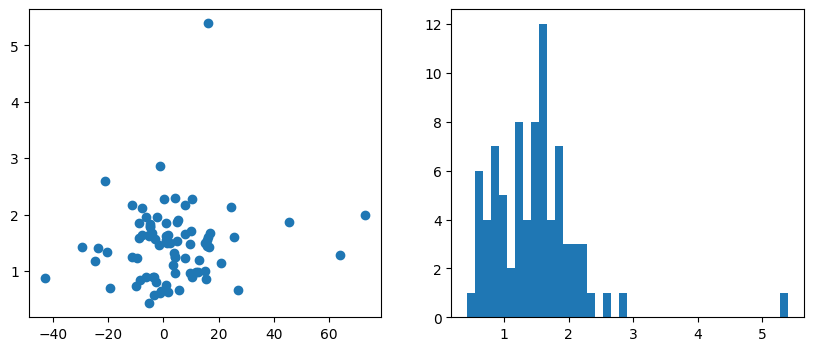

1.4821416818742146
1.4691076499605007


In [54]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(df_tsv['molpdf'],df_tsv['backbone_LRMSD'])
plt.subplot(122)
plt.hist(df_tsv['backbone_LRMSD'],bins=40)
plt.show()
print(df_tsv['backbone_LRMSD'].median())
print(df_tsv['backbone_LRMSD'].mean())
df_tsv.to_csv('/scratch/vmikhayl/pmhc_modeling/pandora1/results.tsv',sep='\t')

In [55]:
df_tsv

,pmhc_id,pdb_id,peptide,mhc,anchors,molpdf,backbone_LRMSD,full_atom_LRMSD,pandora_template,mhc_edit_distance
0,3,7R7V,QASQEVKNW,HLA-B*53:01,"[2, 9]",-24.70895,1.185670,2.210400,1A1O,1
1,12,6UJQ,KQWLVWLLL,HLA-A*02:06,"[2, 9]",27.04659,0.673002,2.051134,2CLR,1
2,19,6PYV,LRNQSVFNF,HLA-B*27:03,"[2, 9]",-4.70176,1.772358,2.680906,3BP4,2
3,22,6L9M,SPSYVYHQF,H2-Ld,"[2, 9]",16.14965,1.600478,2.290991,1LD9,0
4,28,6Z9V,IIGWMWIPV,HLA-A*02:01,"[2, 9]",15.04576,1.505521,4.038623,3BGM,0
...,...,...,...,...,...,...,...,...,...,...
76,865,7MJA,QYNPIRTTF,HLA-A*24:02,"[2, 9]",-4.68029,1.840839,3.422724,3WLB,0
77,888,7KGO,ILLNKHIDA,HLA-A*02:01,"[2, 9]",-10.01155,0.730978,1.623347,3D25,0
78,892,6JOZ,ATIGTAMYK,HLA-A*11:01,"[2, 9]",1.05588,1.555542,1.897641,1Q94,0
79,898,6J1W,AIFQSSMTK,HLA-A*30:01,"[2, 9]",5.14262,1.908433,2.616220,1Q94,12


## same, but use Pandora internal benchmarking

looks like their internal benchmarking is commented out:(

In [139]:
#load db
t0=time.time()
db=Database.load('./PANDORA/PANDORA_files/data/csv_pkl_files/database_c.pkl')
db.repath('/data/vmikhayl/tfold/PANDORA/PANDORA_files/data/PDBs',save='/data/vmikhayl/tfold/PANDORA/PANDORA_files/data/csv_pkl_files/database_repath.pkl')
print('db loaded in {} s'.format(time.time()-t0))
print('completed in {:4.1f} s'.format(time.time()-t0))

#(do not delete structures!)

db loaded in 62.330185413360596 s
completed in 62.3 s


In [123]:
#read old results
pandora_results={}
for d in os.listdir('/scratch/vmikhayl/pmhc_modeling/pandora'):
    if 'results.pckl' in os.listdir('/scratch/vmikhayl/pmhc_modeling/pandora/'+d):
        with open('/scratch/vmikhayl/pmhc_modeling/pandora/'+d+'/results.pckl','rb') as f:
            r=pickle.load(f)
            r.update({'pmhc_id':int(d)})
        for k,v in r.items():
            pandora_results.setdefault(k,[]).append(v)        
    else:
        print(d)
pandora_results=pd.DataFrame(pandora_results)
result_df=pd.merge(df_target,pandora_results,left_on='pmhc_id',right_on='pmhc_id')

In [138]:
result_df.iloc[0]

class                                                               I
cluster_seq                                                         3
pdb_id                                                         7r7v_0
pmhc_id                                                             3
date                                                       2021-06-25
tails                                                          (0, 0)
netmhc_tails                                                   (0, 0)
netmhc_kd                                                  817.375486
pep                                                         QASQEVKNW
mhc_a               <tfold.utils.seq_tools.NUMSEQ object at 0x7f5f...
mhc_b                                                            None
mhc_pandora                                               HLA-B*53:01
pep_CA                                                        1.18567
pep_all                                                        2.2104
mhc_CA              

In [166]:
df=result_df[result_df['pdb_id'].map(lambda x: x.split('_')[0].upper() in p_pdbs)]
print('my test set in pandora templates:',len(df))

x=df.iloc[0]

c_id=str(x['pmhc_id']) 
target_pdb=x['pdb_id'].split('_')[0].upper()
pandora_template_pdb=x['pandora_template']
coutput_dir=f'/scratch/vmikhayl/pmhc_modeling/pandora_self_benchmark/{c_id}'  

try:
    target=PMHC.Target(target_pdb,
                       db.MHCI_data[target_pdb].allele_type,
                       db.MHCI_data[target_pdb].peptide,
                       anchors=db.MHCI_data[target_pdb].anchors)                   
    case=Pandora.Pandora(target, db, template=db.MHCI_data[pandora_template_pdb], output_dir=coutput_dir)
    case.model(benchmark=True)
except Exception as e:
    print(e)    

my test set in pandora templates: 31
No MHC sequence was provided. Trying to retrieve it from reference sequences...
The model will be generated using the best template's MHC sequence.
To be sure you use the right sequence, please double check your MHC allele name
Or provide the MHC sequence as target.M_chain_seq

Modelling 6UJQ...

	Target MHC Class: I
	Target Allele:  ['HLA-A*0206', 'HLA-A*0210', 'HLA-A*0251', 'HLA-A*0257', 'HLA-A*0279', 'HLA-A*0206']
	Target Peptide: KQWLVWLLL
	Target Anchors: 2,9

	User defined template structure: 2CLR
	Template Allele:  ['HLA-A*0201', 'HLA-A*0201']
	Template Peptide: MLLSVPLLLG
	Template Anchors: [2, 9]

###############
TEMPLATE:  2CLR
Chain M, excess N 0, C 0
	Successfully created alignment file
	Successfully created the initital model
	Calculating peptide anchor residue constraints...
	Performing homology modelling of 6UJQ on 2CLR...

	Modelling was successfull and took 176.23 seconds

	Model				Molpdf
	6UJQ.BL00080001		17.9227
	6UJQ.BL00060001	

In [155]:
p_pdbs=set([x.split('.')[0] for x in os.listdir('/data/vmikhayl/tfold/PANDORA/PANDORA_files/data/PDBs/pMHCI')])
print(len(p_pdbs))

835


In [165]:
type(db.MHCI_data['1A1O'])

PANDORA.PMHC.PMHC.Template

In [157]:
np.sum(ind)

31

In [153]:
for x in df_target['pdb_id'].map(lambda x: x.split('_')[0].upper()):
    if x in p_pdbs:
        print(x)


# test: void

In [119]:
#df_target from test set with human and mouse only

print(df_target[df_target['tails']!=df_target['netmhc_tails']]) #none

#compare pep (core) length in target vs template

test_r=pd.read_pickle('/scratch/vmikhayl/pmhc_modeling/test_dataset/result_df.pckl')
print(len(test_r))
print(test_r.columns)

Empty DataFrame
Columns: [class, cluster_seq, pdb_id, pmhc_id, date, tails, netmhc_tails, netmhc_kd, pep, mhc_a, mhc_b, mhc_pandora]
Index: []
644
Index(['pmhc_id', 'model_id', 'n_reg', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'pep', 'mhc_a', 'mhc_b',
       'tails', 'netmhc_tails', 'af_n_reg', 'seqnn_logkd'],
      dtype='object')


In [120]:
df_target['pep'].map(len).value_counts().sort_index()

8      4
9     61
10    14
11     1
12     1
Name: pep, dtype: int64

# test: similar seq, different CA geometry

## choose pmhcs

In [367]:
#pmhcs with multiple registers
seq_to_id={}
for x in pmhcs:
    seq=''.join(x['P']['data']['seq'])
    seq+='_'+''.join(x['M']['data']['seq'])
    if x['class']=='II':
        seq+='_'+''.join(x['N']['data']['seq'])
    seq_to_id.setdefault(seq,[]).append(x['id'])
for x in seq_to_id.values():
    if len(x)>1:
        print(x)
        for y in x:
            z=pmhcs[y]
            assert z['id']==y
            print(y,z['date'],z['date']<date_cutoff,z['class'])            
            m=z['M']['info']
            print(''.join(z['P']['data']['seq']),m['species'],m['locus'],m['allele'],z['netmhc_kd'])
        print()
pmhcs_w_mult_reg_ids=[x for y in seq_to_id.values() for x in y if len(y)>1]
print(len(pmhcs_w_mult_reg_ids))

[39, 249]
39 2010-07-23 True I
XLAXXLTV 9606 A 02:01 812.0863799128646
249 2010-07-23 True I
XLAXXLTV 9606 A 02:01 812.0863799128646

[217, 748]
217 2008-05-12 True I
LLFGXPVYV 9606 A 02:01 2.594055462809111
748 2008-05-09 True I
LLFGXPVYV 9606 A 02:01 2.594055462809111

[255, 341]
255 2006-05-01 True I
AAGIGILTV 9606 A 02:01 3873.7670014369387
341 2017-10-12 True I
AAGIGILTV 9606 A 02:01 3873.7670014369387

[390, 890]
390 2017-08-11 True I
MMWDRGLGMM 9606 A 02:01 97.62114559307155
890 2017-08-11 True I
MMWDRGLGMM 9606 A 02:01 97.62114559307155

[422, 450]
422 2005-07-01 True I
KAFSPEVIPMF 9606 B 57:03 37.38912145012966
450 2005-07-01 True I
KAFSPEVIPMF 9606 B 57:03 37.38912145012966

[430, 730]
430 2010-07-23 True I
ELAXXLTV 9606 A 02:01 8580.405066194853
730 2010-07-23 True I
ELAXXLTV 9606 A 02:01 8580.405066194853

[728, 729]
728 2015-04-06 True I
LYLVCGERGF 10090 K d 9175.746456253162
729 2015-04-06 True I
LYLVCGERGF 10090 K d 9175.746456253162

14


pmhcs: 928
after filtering: 832
dropped for these reasons:
gaps in pep: 21
bad aa in pep: 73
binds in mult. registers: 14
1 379
2  58
3  11
4   5
5   3
6   2
seq clusters with more than one CA cluster: 72
by class:
I     70
II     2
Name: class, dtype: int64
1924
drop 3 with pep mismatch >3
0.39 0
13 PKYVKQNTLKLAT 9606_DRA_01:01|9606_DRB1_01:01 
13 PKYVKQNTLKLAT 9606_DRA_01:01|9606_DRB1_01:01 
0.26 1
13 ADLIAYLKQATKG 10090_IEA_d|10090_IEB_k 
13 ADLIAYLEQATKG 10090_IEA_d|10090_IEB_k 


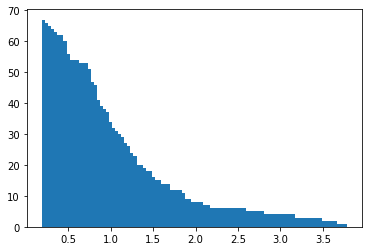

1.5 16
2.0 8
2.5 6


In [556]:
#prefilter to pmhcs with no X residues anywhere and with no gaps (anywhere for cl I, outside ext core for cl II)
aa_set=set(list('ACDEFGHIKLMNPQRSTVWY'))

gap_cutoff=0  #require no more than this number of gaps in pep

n_gaps=0
n_bad_aa=0
n_mult_reg=0
pmhcs_keep=[]
for pmhc in pmhcs:
    drop=False    
    structure=summary[pmhc['pdbs'][0][0]]
    pep=pmhc['P']
    pep_structure=structure['P']
    cl=pmhc['class']        
    if pmhc['id'] in pmhcs_w_mult_reg_ids:
        drop=True
        n_mult_reg+=1
    if cl=='I': #for cl I, count gaps everywhere
        pepseq=pep_structure['data']['seq']
    else:       #for cl II, only count gaps in ext binding core, since tails move around and we don't care
        pepseq=pep_structure['data']['seq'][(pep_structure['data']['pdbnum']>='   09')&(pep_structure['data']['pdbnum']<='   9 ')]    
    gap_count=np.sum([c.islower() for c in pepseq])
    if gap_count>gap_cutoff:
        drop=True
        n_gaps+=1            
    if set(list(pep['data']['seq']))-aa_set:
        drop=True
        n_bad_aa+=1    
    if not drop:
        pmhcs_keep.append(pmhc)            
print('pmhcs:',len(pmhcs))
print('after filtering:',len(pmhcs_keep))        
print('dropped for these reasons:')
print('gaps in pep:',n_gaps)
print('bad aa in pep:',n_bad_aa)
print('binds in mult. registers:',n_mult_reg)

#count CA clusters for each seq cluster (filtered pmhcs only)
cluster_ids=pd.DataFrame([[x['id'],x['cluster_seq'], x['cluster_CA']] for x in pmhcs_keep],columns=['pmhc_id','cluster_seq','cluster_CA'])
CA_counts=cluster_ids.groupby('cluster_seq').apply(lambda x: x['cluster_CA'].nunique()).reset_index().rename({0:'CA_counts'},axis=1)
utils.print_hist(CA_counts['CA_counts'].values)
pmhc_ids=cluster_ids.groupby('cluster_seq').apply(lambda x: x['pmhc_id'].values).reset_index().rename({0:'pmhc_ids'},axis=1)
pmhc_ids=pmhc_ids.explode('pmhc_ids')
pmhc_ids['peplen']=pmhc_ids['pmhc_ids'].map(lambda x:len(pmhcs[x]['P']['data']))
pmhc_ids=pmhc_ids.groupby(['cluster_seq','peplen']).apply(lambda x: list(x['pmhc_ids'].values)).reset_index().rename({0:'pmhc_ids'},axis=1)
df_pairs=pd.merge(CA_counts,pmhc_ids,left_on='cluster_seq',right_on='cluster_seq')
df_pairs=df_pairs[(df_pairs['CA_counts']>1)&(df_pairs['pmhc_ids'].map(len)>1)]
df_pairs['class']=df_pairs['pmhc_ids'].map(lambda x:pmhcs[x[0]]['class'])
print('seq clusters with more than one CA cluster:',len(df_pairs))
print('by class:')
print(df_pairs['class'].value_counts())

#compute pairwise core CA rmsds
with open(source_dir+'/peptide_coords_CA.pckl','rb') as f:
    pep_coords_CA=pickle.load(f)
print(len(pep_coords_CA))
def _get_rmsd_matrix(x):    
    c_pdbs=[pmhcs[i]['pdbs'][0][0] for i in x]
    pos=set(pep_coords_CA[c_pdbs[0]].keys())
    for pdb in c_pdbs:
        pos&=set(pep_coords_CA[pdb].keys())
    pos=np.sort(list(pos))
    pos=[p for p in pos if '   1 '<=p<='   9 '] #filter to core    
    coord_matrix=np.array([[pep_coords_CA[pdb][p] for p in pos] for pdb in c_pdbs])
    return (np.sum(np.sum((coord_matrix[:,np.newaxis,:,:]-coord_matrix[np.newaxis,:,:,:])**2,axis=-1),axis=-1)/coord_matrix.shape[1])**0.5
df_pairs['dist_matrix']=df_pairs['pmhc_ids'].map(_get_rmsd_matrix)
df_pairs['max_dist']=df_pairs['dist_matrix'].map(np.max)
def _dist_to_pair(x):
    xx=x['dist_matrix']
    ind=np.unravel_index(np.argmax(xx),xx.shape)
    return x['pmhc_ids'][ind[0]],x['pmhc_ids'][ind[1]]
df_pairs['pair']=df_pairs.apply(_dist_to_pair, axis=1)
#add pep mismatch
def _get_pep_mismatch(x):
    peps=[pmhcs[i]['P']['data']['seq'] for i in x]
    return np.sum([y[0]!=y[1] for y in zip(*peps)])
df_pairs['pep_mismatch']=df_pairs['pair'].map(_get_pep_mismatch)
print('drop {} with pep mismatch >3'.format(np.sum(df_pairs['pep_mismatch']>3)))
df_pairs=df_pairs[df_pairs['pep_mismatch']<=3]

#look at cl II
for y in df_pairs[df_pairs['class']=='II'].iterrows():
    y=y[1]
    x=y['pair']    
    s=[]
    for i in range(2):
        z=pmhcs[x[i]]
        pepseq=''.join(z['P']['data']['seq'])
        linker=np.any(z['P']['info']['linker']).astype(int)*'LINKER'+'' #check for linkers
        if linker:
            print('LINKER!') #double check
        m=z['M']['info']
        mhc_allele='_'.join([m['species'],m['locus'],m['allele']])
        if 'N' in z:
            m=z['N']['info']
            mhc_allele+='|'+'_'.join([m['species'],m['locus'],m['allele']])
        s.append([pepseq,mhc_allele,linker])
    print('{:4.2f} {:1d}'.format(y['max_dist'],y['pep_mismatch']))
    for s1 in s:
        print('{:2d} {:12s} {:12s} {}'.format(len(s1[0]),*s1))
df_pairs=df_pairs[df_pairs['class']=='I'] #drop cl II

def _compute_rmsds(pmhc_id1,pmhc_id2):
    pmhc1=pmhcs[pmhc_id1]
    pmhc2=pmhcs[pmhc_id2]
    pdb_id1=pmhc1['pdbs'][0][0]
    pdb_id2=pmhc2['pdbs'][0][0]    
    structure1,_=pdb_tools.parse_pdb(source_dir+f'/pdb/{pdb_id1}.pdb','pdb1')    
    structure2,_=pdb_tools.parse_pdb(source_dir+f'/pdb/{pdb_id2}.pdb','pdb2')    
    pdbnum1=['P'+p for p in pmhc1['P']['data']['pdbnum']]
    pdbnum2=['P'+p for p in pmhc2['P']['data']['pdbnum']]
    assert len(pdbnum1)==len(pdbnum2)    
    chainmap=[['M','M']]
    pdb_tools.superimpose_by_chainmap(structure1,structure2,chainmap,CA_only=True,verbose=False)    
    resmap=list(zip(pdbnum1,pdbnum2))
    pep_rmsd=pdb_tools.rmsd_by_resmap(structure1,structure2,resmap,allow_missing_res=True,verbose=False)    
    return pep_rmsd['CA']
df_pairs['true_rmsd']=df_pairs['pair'].map(lambda x: _compute_rmsds(*x))

#look at max distances
plt.figure()
plt.hist(df_pairs['true_rmsd'],bins=100,cumulative=-1)
plt.show()
for t in [1.5,2.,2.5]:
    print(t,np.sum(df_pairs['true_rmsd']>t))

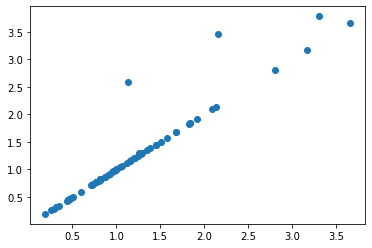

In [557]:
plt.figure()
plt.scatter(df_pairs['max_dist'],df_pairs['true_rmsd'])
plt.show()
#outliers due to reg difference that is not picked up by old CA dist computation

#NOTE: very good agreement except for reg mismatch! Threrefore, superimposing on canonical structure is a good approx

In [564]:
threshold=1.5
df_target=df_pairs[df_pairs['true_rmsd']>threshold]
df_target.to_pickle('/scratch/vmikhayl/pmhc_modeling/difficult_dataset/pmhcs_df.pckl')

for y in df_target.iterrows():
    y=y[1]
    x=y['pair']    
    s=[]
    for i in range(2):
        z=pmhcs[x[i]]
        pepseq=''.join(z['P']['data']['seq'])
        numseq=','.join(z['P']['data']['pdbnum']).replace(' ','')
        linker=np.any(z['P']['info']['linker']).astype(int)*'LINKER'+'' #check for linkers
        if linker:
            print('LINKER!') #double check
        m=z['M']['info']
        mhc_allele='_'.join([m['species'],m['locus'],m['allele']])
        if 'N' in z:
            m=z['N']['info']
            mhc_allele+='|'+'_'.join(m['species'],m['locus'],m['allele'])
        s.append([pepseq,numseq,mhc_allele,linker])
    print('{:4.2f} {:1d}'.format(y['true_rmsd'],y['pep_mismatch']))
    for s1 in s:
        print('{:2d} {:12s} {:24s} {:12s} {}'.format(len(s1[0]),*s1))        

1.92 1
 9 QASQEVKNW    1,2,3,4,5,6,7,8,9        9606_B_53:01 
 9 QATQEVKNW    1,2,3,4,5,6,7,8,9        9606_B_53:01 
1.84 2
 9 NLVPMGATV    1,2,3,4,5,6,7,8,9        9606_A_02:01 
 9 NLVPMVAAV    1,2,3,4,5,6,7,8,9        9606_A_02:01 
1.84 1
 9 LTVQVARVW    1,2,3,4,5,6,7,8,9        9606_B_57:03 
 9 LTVQVARVY    1,2,3,4,5,6,7,8,9        9606_B_57:01 
1.58 2
 9 SLYNTIATL    1,2,3,4,5,6,7,8,9        9606_A_02:01 
 9 SLFNTVATL    1,2,3,4,5,6,7,8,9        9606_A_02:01 
3.66 1
11 HPVGDADYFEY  1,2,3,4,5,51,59,6,7,8,9  9606_B_35:08 
11 HPVGQADYFEY  1,2,3,4,5,51,59,6,7,8,9  9606_B_35:01 
2.60 2
 9 ALGIGILTV    1,2,3,4,5,6,7,8,9        9606_A_02:01 
 9 LAGIGILTV    2,3,4,5,51,6,7,8,9       9606_A_02:01 
2.81 0
10 GADGVGKSAL   1,2,3,4,5,51,6,7,8,9     9606_C_08:02 
10 GADGVGKSAL   1,2,3,4,5,51,6,7,8,9     9606_C_05:01 
1.68 3
 9 EEYLQAFTY    1,2,3,4,5,6,7,8,9        9606_B_44:03 
 9 EEYLKAWTF    1,2,3,4,5,6,7,8,9        9606_B_44:03 
2.14 1
 9 RRRWRRLTV    1,2,3,4,5,6,7,8,9        9606_B_27:05 
 9

## load data

In [3]:
df_pairs=pd.read_pickle('/scratch/vmikhayl/pmhc_modeling/difficult_dataset/pmhcs_df.pckl')
print(len(df_pairs))
print(df_pairs.columns)

#make dataframes
df=pd.DataFrame([[y] for x in df_pairs['pair'].values for y in x],columns=['pmhc_id'])
def _map_pep(x):    
    return ''.join(pmhcs[x]['P']['data']['seq'])
def _map_mhc_a(x):    
    return seq_tools.load_NUMSEQ(pmhcs[x]['M'])
def _map_mhc_b(x):    
    if 'N' in pmhcs[x]:
        return seq_tools.load_NUMSEQ(pmhcs[x]['N'])
    else:
        return None
df['pdb_id']=df['pmhc_id'].map(lambda x:pmhcs[x]['pdbs'][0][0])
for k in ['class','tails','netmhc_tails','netmhc_kd']:
    df[k]=df['pmhc_id'].map(lambda x: pmhcs[x][k])
df['pep']=df['pmhc_id'].map(_map_pep)
df['mhc_a']=df['pmhc_id'].map(_map_mhc_a)
df['mhc_b']=df['pmhc_id'].map(_map_mhc_b)

print('class:',df['class'].value_counts()) #only cl I !
print('non trivial tails:',np.sum(df['tails']!=(0,0)))
print('netmhc errors:',np.sum(df['tails']!=df['netmhc_tails']))

df=df[df.columns[[0,2,6,7,8,3,4,5,1]]]

#pdbs to exclude from templates: pdbs from the same seq cluster
def _pmhc_id_to_cluster_to_pdbs(x):
    cseq_id=pmhcs[x]['cluster_seq']
    return list(set([a[0].split('_')[0] for a in pmhcs_seq_clusters[cseq_id]['pdbs']]))        
df['exclude_pdbs']=df['pmhc_id'].map(_pmhc_id_to_cluster_to_pdbs)

df_target=df
print(len(df_target))
print(df_target.columns)

16
Index(['cluster_seq', 'CA_counts', 'peplen', 'pmhc_ids', 'class',
       'dist_matrix', 'max_dist', 'pair', 'pep_mismatch', 'true_rmsd'],
      dtype='object')
class: I    32
Name: class, dtype: int64
non trivial tails: 3
netmhc errors: 3
32
Index(['pmhc_id', 'class', 'pep', 'mhc_a', 'mhc_b', 'tails', 'netmhc_tails',
       'netmhc_kd', 'pdb_id', 'exclude_pdbs'],
      dtype='object')


## make inputs, parse results

In [4]:
target_dir='/scratch/vmikhayl/pmhc_modeling/difficult_dataset'
target_dir_apollo='/scratch/lustre/vmikhayl/pmhc_modeling/difficult_dataset'

ctarget_dir=target_dir+'/run_ext'#'/run_basic'
ctarget_dir_apollo=target_dir_apollo+'/run_ext' #'/run_basic'

In [5]:
#run seqnn
t0=time.time()
df_target=make_inputs.run_seqnn(df_target)
print('kd predicted for {:4d} pmhcs in {:5.1f} s'.format(len(df_target),time.time()-t0))

making Kd predictions for 32 pmhcs...


2023-02-04 23:56:00.227080: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


kd predicted for   32 pmhcs in  24.7 s


In [11]:
#params
params_I ={'templates_per_register':40, #former (ext_old): 80
           'pep_gap_penalty':1,
            'mhc_cutoff':25,   #20
            'score_cutoff':None,
            'pep_score_cutoff':4, #templates with pep mismatch<=4 excluded
            'kd_threshold':10., 
            'use_mhc_msa':False,
            'use_paired_msa':True,
            'tile_registers':False,
            'shuffle':False
           }
params_II={'templates_per_register':20,
           'pep_gap_penalty':1,
            'mhc_cutoff':25,
            'score_cutoff':None,
            'kd_threshold':100.,  
            'use_mhc_msa':False,
            'use_paired_msa':True,
            'tile_registers':False,
            'shuffle':False
           }
params={'I':params_I,'II':params_II}

In [12]:
t0=time.time()
#NOTE: NO DATE CUTOFF
af_inputs=make_inputs.make_inputs(df_target,params=params,date_cutoff=None,print_stats=True)
print('prepared {:4d} inputs in {:5.1f} s'.format(len(af_inputs),time.time()-t0))

#5.2 per pmhc -> 10.4 -> 20.5
#167 -> 334 -> 657

class I:
pmhcs:  32; runs:  334, runs per pmhc: av 10.4, max 20; registers per pmhc: av 1.2, max  3
prepared  334 inputs in   8.0 s


In [13]:
#verify template date cutoff, summarize scores
with open('./data/experimental_structures/processed_updated/summary.pckl','rb') as f:
    pdb_summary=pickle.load(f)
    
pdbs_target=set()
pdbs_template=set()
scores=[]
for x in af_inputs:
    pdbs_target.add(x['true_pdb'])
    for y in x['template_hits']:
        pdbs_template.add(y['name'])
        scores.append(1000-y['sum_probs'])
        if 1000-y['sum_probs']<6:
            print(1000-y['sum_probs'],y['query'][:15],y['hit_sequence'][:15])
target_dates=[pdb_summary[x]['date'] for x in pdbs_target]
template_dates=[pdb_summary[x]['date'] for x in pdbs_template]
print('targets:')
print(min(target_dates),max(target_dates))
print('templates:')
print(min(template_dates),max(template_dates))

utils.print_hist(scores)

5 NLVPMGATVGSHSMR YLEPGPVTVGSHSMR
5 NLVPMVAAVGSHSMR GLCPLVAMLGSHSMR
5 NLVPMVAAVGSHSMR GLLPELPAV-SHSMR
5 SLYNTIATLGSHSMR NLVPTVATVGSHSMR
5 SLYNTIATLGSHSMR SLLMWITQLGSHSMR
5 SLFNTVATLGSHSMR NLVPMVATVGSHSMR
5 SLFNTVATLGSHSMR GLCPLVAMLGSHSMR
5 SLFNTVATLGSHSMR GLCTLVAMLGSHSMR
5 SLFNTVATLGSHSMR NLVXMVATVGSHSMR
5 ALGIGILTVGSHSMR XLAXX-LTVGSHSMR
5 ALGIGILTVGSHSMR XLAXX-LTVGSHSMR
5 ALGIGILTVGSHSMR YLEPGPVTVGSHSMR
5 EEYLQAFTYGSHSMR EEFGRAFSFGSHSMR
5 EEYLKAWTFGSHSMR EEFGRAFSFGSHSMR
targets:
2004-03-01 2021-06-25
templates:
1993-06-30 2022-02-22
5   14
6  112
7  220
8  138
9  101
10  67
11  48
12  36
13  24
14  18
15  14
16  27
17  15
18  12
19  31
20  36
21  20
22  42
23  40
24  51
25  61
26  49
27  44
28  34
29  23
30  13
31  24
32   9
33   9


In [14]:
#split jobs

inputs=af_inputs
python_path='/data/vmikhayl/alphafold-multimer/alphafold/tfold_run_alphafold.py'
sh_path='./scripts/run_alphafold.sh'

n_tasks=15 #CHECK!!!!!!
apollo=True
exclusive=False #True
gpu=True
qos='short'
time_per_input=120. #less models => more time per model
time_per_task=int(len(inputs)*time_per_input/(60*n_tasks))
max_run_time=int(time_per_task*1.5)
print('estimated time per task, min:',time_per_task)
print('max run time, min:',max_run_time)

input_dir =ctarget_dir+'/inputs'
log_dir   =ctarget_dir+'/logs'
output_dir=ctarget_dir+'/outputs'
if apollo:
    input_dir_server =ctarget_dir_apollo+'/inputs'
    log_dir_server   =ctarget_dir_apollo+'/logs'
    output_dir_server=ctarget_dir_apollo+'/outputs'
else:
    input_dir_server =input_dir
    log_dir_server   =log_dir
    output_dir_server=output_dir

#make dirs
for d in [input_dir,log_dir,output_dir]:
    os.makedirs(d,exist_ok=True)    
#save a copy of df_target
df_target.to_pickle(ctarget_dir+'/target_df.pckl')
#make input files
indices=utils.split_jobs(len(inputs),n_tasks)
n_tasks=len(indices)
max_inputs_per_task=-1
for i,job in enumerate(indices):
    c_inputs=[inputs[j] for j in job]        
    max_inputs_per_task=max(max_inputs_per_task,len(c_inputs))
    with open(input_dir+'/input_'+str(i)+'.pckl','wb') as f:
        pickle.dump(c_inputs,f)  
print('tasks: {}, max inputs per task: {}'.format(n_tasks,max_inputs_per_task))

#make .sh        
lines=[]
lines.append('#!/bin/bash')
lines.append('')
lines.append(f'#SBATCH --array=0-{n_tasks-1}')             #run an array of n_tasks tasks
lines.append(f'#SBATCH --output={log_dir_server}/output_%a.txt')  #here %a will evaluate to array task id
lines.append(f'#SBATCH --error={log_dir_server}/error_%a.txt')
lines.append(f'#SBATCH --ntasks=1')                        #each array element is one task
if exclusive:
    lines.append(f'#SBATCH --exclusive')                   #request exclusive use of node, e.g. for hhblits
if gpu:
    lines.append(f'#SBATCH --gpus=1')                      #one gpu per task will use one core
#elif not exclusive:
#    lines.append(f'#SBATCH --cpus-per-task=1')             #one cpu per task
lines.append(f'#SBATCH --qos={qos}')  
lines.append(f'#SBATCH --time={max_run_time}')             #maximal run time in minutes, same for each array task
lines.append('')
lines.append(f'input_file={input_dir_server}/input_$SLURM_ARRAY_TASK_ID.pckl')        
lines.append(f'srun python {python_path} --inputs $input_file --output_dir {output_dir_server}')

if not sh_path.startswith(('/','./')):
    sh_path='./'+sh_path
with open(sh_path,'w') as f:
    f.writelines('\n'.join(lines))
os.chmod(sh_path, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)      

estimated time per task, min: 44
max run time, min: 66
tasks: 15, max inputs per task: 23


In [15]:
#check results
n=0
for x in os.listdir(ctarget_dir+'/outputs'):
    for y in os.listdir(ctarget_dir+'/outputs/'+x):
        if y.endswith('.pdb'):
            n+=1
print('structures produced:',n)
t=[]
for x in os.listdir(ctarget_dir+'/logs'):
    if x.startswith('output'):
        with open(ctarget_dir+'/logs/'+x) as f:
            s=f.read().split('\n')
        if len(s)>1:
            for line in s:
                if line.startswith('time per input:'):
                    t.append(float(line.split(':')[1]))
                    break            
print('times loaded for {} runs'.format(len(t)))
print('time per structure: mean {:4.1f} s, max {:4.1f} s'.format(np.mean(t),max(t)))
#note: on 16 jobs, time per structure was ~42s; on 8 jobs, down to 35, despite pep renumbering and rmsd added:
#still saving on startup time!

structures produced: 334
times loaded for 15 runs
time per structure: mean 38.9 s, max 50.5 s


In [17]:
#assemple result_df
result_parse_tools.parse_results(ctarget_dir,get_rmsd=True)

 334 outputs collected in   40.2 s


## analyze results

In [18]:
def _color_by_regerr(x):
    if not x['register_identified']:
        return 'not identified'
    elif x['tails']!=x['af_tails']:
        return 'incorrect'
    else:
        return 'correct'
def summarize_results(df_list,names_list):    
    df_list=[x.copy() for x in df_list]
    n_fail=[np.sum(~x['register_identified']) for x in df_list]
    n_regerr=[np.sum(x['register_identified']&(x['tails']!=x['af_tails'])) for x in df_list]
    #good_df_list=[x[(x['tails']==x['af_tails'])&(x['register_identified'])] for x in df_list]    
    good_df_list=df_list #median and mean for all
    for name, fail, regerr in zip(names_list,n_fail,n_regerr):
        print('{:10s}: fails: {:2d}, regerr: {:2d}'.format(name, fail, regerr))    
    print('median:')
    for name, df in zip(names_list,good_df_list):
        s=[]
        for k in ['pep_CA','pep_all','mhc_CA','mhc_all']:
            s.append('{:s}: {:4.2f}'.format(k,df[k].median()))
        print('{:10s}: '.format(name)+', '.join(s))
    print('mean:')
    for name, df in zip(names_list,good_df_list):
        s=[]
        for k in ['pep_CA','pep_all','mhc_CA','mhc_all']:
            s.append('{:s}: {:4.2f}'.format(k,df[k].mean()))
        print('{:10s}: '.format(name)+', '.join(s))       
    for name,df in zip(names_list,df_list):
        df['model selection']=[name]*len(df)    
    df=pd.concat(df_list)
    df['register']=df.apply(_color_by_regerr,axis=1)
    plt.figure()
    sns.boxplot(data=df,y='pep_CA',x='model selection',color='lightgray',fliersize=0)
    sns.stripplot(data=df,y='pep_CA',x='model selection',hue='register',marker='.')
    plt.show()
#hill_colors=['rosybrown','lightcoral','indianred','brown','maroon']
hill_colors=['lightgray','darkgray','dimgray','black']
def make_hill_plot(rmsds,scores,rmsd_bins,xticks=None,xlim=None,loc=None,return_frac=False): 
    rmsd_bins_ext=[0.]+rmsd_bins+[10000.]
    scores=np.array(scores)
    score_bins=np.sort(np.unique(scores))
    score_bins=[0.99*score_bins[0]]+list(score_bins)+[1.01*score_bins[-1]]    
    counts=[]
    for s in score_bins:        
        r=rmsds[scores<s]
        counts.append([np.sum((r>=rmsd_bins_ext[i])&(r<rmsd_bins_ext[i+1])) for i in range(len(rmsd_bins_ext)-1)])
    counts=np.stack(counts).T/len(rmsds) #fractions, (n_groups,n_score_thresholds)
    counts_at_half=counts[:,np.sum(counts,axis=0)>0.5][:,0]
    if return_frac:
        return counts_at_half
    print(counts_at_half) #fractions for threshold when half models pass
    plt.figure()
    plt.stackplot(np.log(score_bins),counts,colors=hill_colors[:len(rmsd_bins)+1])            
    if not (xlim is None):
        plt.xlim(np.log(xlim))
        if not (xticks is None):
            xticks=xticks[(xticks>=xlim[0])&(xticks<=xlim[1])]
    if not (xticks is None):
        plt.xticks(np.log(xticks),xticks)
    loc=loc or 'lower right'
    plt.legend([f'<{r}' for r in rmsd_bins]+[f'>{rmsd_bins[-1]}'],loc=loc)
    plt.axhline(0.5)
    plt.show()

In [19]:
result_df=pd.read_pickle(ctarget_dir+'/result_df.pckl')
print(len(result_df))
print(result_df.columns)

334
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'pep', 'mhc_a', 'mhc_b',
       'tails', 'netmhc_tails', 'netmhc_kd', 'pdb_id', 'exclude_pdbs',
       'tails_prefiltered', 'af_n_reg', 'seqnn_logkd'],
      dtype='object')


334
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'pep', 'mhc_a', 'mhc_b',
       'tails', 'netmhc_tails', 'netmhc_kd', 'pdb_id', 'exclude_pdbs',
       'tails_prefiltered', 'af_n_reg', 'seqnn_logkd'],
      dtype='object')
best lddt : fails:  0, regerr:  2
best rmsd : fails:  0, regerr:  2
median:
best lddt : pep_CA: 1.37, pep_all: 2.80, mhc_CA: 0.35, mhc_all: 0.98
best rmsd : pep_CA: 1.09, pep_all: 2.27, mhc_CA: 0.37, mhc_all: 1.00
mean:
best lddt : pep_CA: 1.59, pep_all: 2.75, mhc_CA: 0.37, mhc_all: 1.02
best rmsd : pep_CA: 1.27, pep_all: 2.28, mhc_CA: 0.39, mhc_all: 1.03


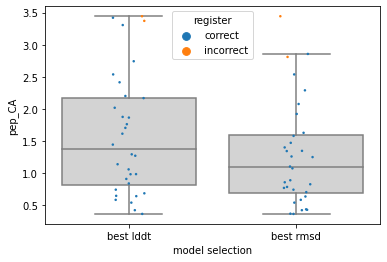

[0.34375 0.125   0.0625  0.     ]


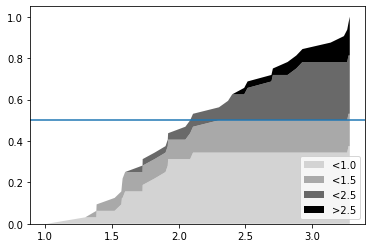

In [20]:
result_df=pd.read_pickle(ctarget_dir+'/result_df.pckl')
print(len(result_df))
print(result_df.columns)

result_df['score']=100-result_df['pep_lddt'].map(result_parse_tools.mean_pep_lddt)
#MAKE compute_scores in result parse tools; add smth like 10*(reg not assigned)!!

cl='I'
df0=result_df[result_df['class']==cl].copy()
df_lddt=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'score',how='min')
df_lddt=df_lddt.reset_index(drop=True)
df_rmsd=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'pep_CA',how='min')
df_rmsd=df_rmsd.reset_index(drop=True)    
summarize_results([df_lddt,df_rmsd],['best lddt','best rmsd'])
make_hill_plot(df_lddt['pep_CA'],df_lddt['score'],[1.,1.5,2.5])#,xticks=None,xlim=None,loc=None)   


#before new template split: median rmsd 1.40 (2.86), regerr 2, sa50=0.28*2
#after: rmsd 1.37(2.80), regerr 2, sa50 0.34*2

In [21]:
#compute rmsds to opposite
def _compute_cross_rmsd(pmhc_id_model,pmhc_id_cross):
    pmhc_model=pmhcs[pmhc_id_model]
    pmhc_cross=pmhcs[pmhc_id_cross]
    
    model_id=df_lddt[df_lddt['pmhc_id']==pmhc_id_model].iloc[0]['model_id']
    pdb_model=ctarget_dir+f'/outputs/{pmhc_id_model}/structure_model_1_{model_id}.pdb'        
    pdb_id_cross=pmhc_cross['pdbs'][0][0]    
        
    structure1,_=pdb_tools.parse_pdb(pdb_model)
    structure2,_=pdb_tools.parse_pdb(source_dir+f'/pdb/{pdb_id_cross}.pdb','pdb2')    
    
    structure1_dict=pdb_tools.get_structure_dict(structure1,False)
    pdbnum1=['P'+x for x in structure1_dict['P'].keys()]              
    pdbnum2=['P'+p for p in pmhc_cross['P']['data']['pdbnum']]
    assert len(pdbnum1)==len(pdbnum2)    
    chainmap=[['M','M']]
    pdb_tools.superimpose_by_chainmap(structure1,structure2,chainmap,CA_only=True,verbose=False)    
    resmap=list(zip(pdbnum1,pdbnum2))
    pep_rmsd=pdb_tools.rmsd_by_resmap(structure1,structure2,resmap,allow_missing_res=True,verbose=False)    
    return (pmhc_id_model,pep_rmsd['CA'])

r1=df_pairs['pair'].map(lambda x:_compute_cross_rmsd(x[0],x[1])) #for 1st model in pair
r2=df_pairs['pair'].map(lambda x:_compute_cross_rmsd(x[1],x[0])) #for 2nd model in pair
cross_rmsd=pd.DataFrame([list(x) for x in pd.concat([r1,r2]).values],columns=['pmhc_id','cross_rmsd'])

In [22]:
def _add_model_data(x,k):
    return tuple([df_lddt[df_lddt['pmhc_id']==a].iloc[0][k] for a in x])

df_pairs['model_rmsds']=df_pairs['pair'].map(lambda x:_add_model_data(x,'pep_CA'))
df_pairs['model_lddts']=df_pairs['pair'].map(lambda x:_add_model_data(x,'score'))

df_pairs=df_pairs.sort_values('true_rmsd')

#sort by max dist
#plot triples of rmsds, ticks: pep,mhc; color: predicted accuracy

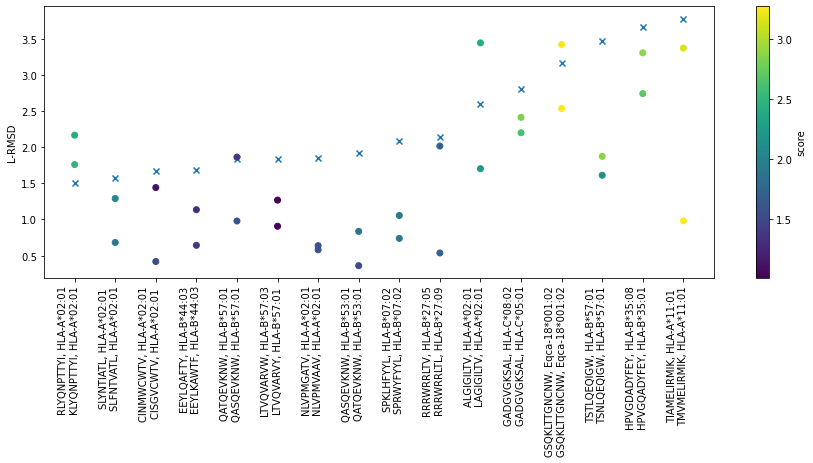

In [23]:
spd={'9606':'HLA','9796':'Eqca'}
def _make_names(x):
    s=''
    for a in x:
        pepseq=''.join(pmhcs[a]['P']['data']['seq'])
        mhc=pmhcs[a]['M']['info']        
        mhc=spd[mhc['species']]+'-'+mhc['locus']+'*'+mhc['allele']
        s+=(pepseq+', '+mhc+'\n')
    return s
names=df_pairs['pair'].map(_make_names).values
exp_rmsds=df_pairs['true_rmsd'].values
model_rmsds=[np.stack(df_pairs['model_rmsds'].values)[:,i] for i in range(2)]
model_lddts=[np.log(np.stack(df_pairs['model_lddts'].values))[:,i] for i in range(2)] #log scale

plt.figure(figsize=(15,5))
plt.scatter(range(len(names)),exp_rmsds,marker='x')
plt.scatter(range(len(names)),model_rmsds[0],c=model_lddts[0])
plt.scatter(range(len(names)),model_rmsds[1],c=model_lddts[1])
plt.xticks(range(len(names)),names,rotation=90)
plt.ylabel('L-RMSD')
plt.colorbar(label='score')
plt.show()                        

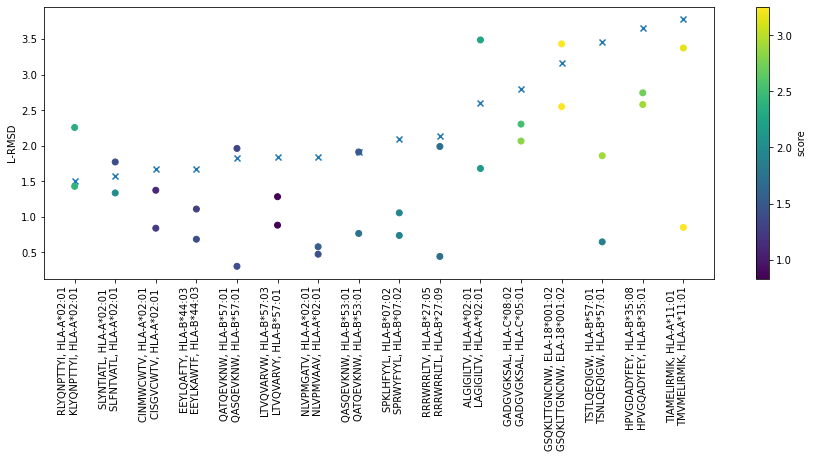

In [675]:
#OLD VERSION BEFORE TEMPLATE SPLIT: DON'T RUN!!!

spd={'9606':'HLA','9796':'Eqca'}
def _make_names(x):
    s=''
    for a in x:
        pepseq=''.join(pmhcs[a]['P']['data']['seq'])
        mhc=pmhcs[a]['M']['info']        
        mhc=spd[mhc['species']]+'-'+mhc['locus']+'*'+mhc['allele']
        s+=(pepseq+', '+mhc+'\n')
    return s
names=df_pairs['pair'].map(_make_names).values
exp_rmsds=df_pairs['true_rmsd'].values
model_rmsds=[np.stack(df_pairs['model_rmsds'].values)[:,i] for i in range(2)]
model_lddts=[np.log(np.stack(df_pairs['model_lddts'].values))[:,i] for i in range(2)] #log scale

plt.figure(figsize=(15,5))
plt.scatter(range(len(names)),exp_rmsds,marker='x')
plt.scatter(range(len(names)),model_rmsds[0],c=model_lddts[0])
plt.scatter(range(len(names)),model_rmsds[1],c=model_lddts[1])
plt.xticks(range(len(names)),names,rotation=90)
plt.ylabel('L-RMSD')
plt.colorbar(label='score')
plt.show()                        

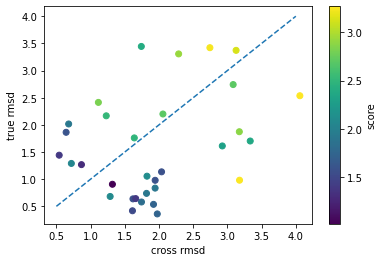

In [24]:
#plot proper vs cross rmsds
#cross_rmsd
proper_rmsd=np.array([df_lddt[df_lddt['pmhc_id']==x].iloc[0]['pep_CA'] for x in cross_rmsd['pmhc_id']])
lddt_list=np.log([df_lddt[df_lddt['pmhc_id']==x].iloc[0]['score'] for x in cross_rmsd['pmhc_id']])
plt.figure()
plt.scatter(cross_rmsd['cross_rmsd'].values,proper_rmsd,c=lddt_list)
plt.plot([0.5,4.],[0.5,4.],linestyle='--')
plt.xlabel('cross rmsd')
plt.ylabel('true rmsd')
plt.colorbar(label='score')
plt.show()

In [25]:
print(np.sum(proper_rmsd<cross_rmsd['cross_rmsd']),len(proper_rmsd)) #all
ind=lddt_list<2.
print(np.sum(proper_rmsd[ind]<cross_rmsd['cross_rmsd'][ind]),len(proper_rmsd[ind])) #score<2.

19 32
11 15


# pMHC assays test set

## load data

In [30]:
with open('./data/pmhc_assays/test_i.pckl','rb') as f:
    assays_i=pickle.load(f)
with open('./data/pmhc_assays/test_ii.pckl','rb') as f:
    assays_ii=pickle.load(f)
assays_i['mhc_b']=[None for i in range(len(assays_i))]
assays=pd.concat([assays_i,assays_ii])
assays=assays.reset_index()
print(len(assays))

assays['pmhc_id']=assays.index.copy()
def _add_mhc(x):
    if x:
        return seq_tools.mhcs[x]
assays['mhc_a']=assays['mhc_a'].map(_add_mhc)
assays['mhc_b']=assays['mhc_b'].map(_add_mhc)
assays=assays[['pmhc_id','class','pep','mhc_a','mhc_b','mhc_iedb','date','kd']]
print(assays.columns)

#pep len stats
print('pep len cl I:')
print(assays[assays['class']=='I']['pep'].map(len).value_counts().sort_index())
print('pep len cl II:')
print(assays[assays['class']=='II']['pep'].map(len).value_counts().sort_index())

df_target=assays

871
Index(['pmhc_id', 'class', 'pep', 'mhc_a', 'mhc_b', 'mhc_iedb', 'date', 'kd'], dtype='object')
pep len cl I:
8      25
9     255
10    105
11     14
Name: pep, dtype: int64
pep len cl II:
12     14
13     17
14      2
15    334
16     14
17     14
18     58
20     19
Name: pep, dtype: int64


## make inputs, parse outputs

In [100]:
target_dir='/scratch/vmikhayl/pmhc_modeling/pmhc_assays_test_dataset'
target_dir_apollo='/scratch/lustre/vmikhayl/pmhc_modeling/pmhc_assays_test_dataset'

ctarget_dir=target_dir
ctarget_dir_apollo=target_dir_apollo

In [39]:
#run seqnn
t0=time.time()
df_target=make_inputs.run_seqnn(df_target)
print('kd predicted for {:4d} pmhcs in {:5.1f} s'.format(len(df_target),time.time()-t0))

making Kd predictions for 399 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


making Kd predictions for 472 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


kd predicted for  871 pmhcs in  52.0 s


In [40]:
params={'I':
                 {
                  'templates_per_register':20,
                  'pep_gap_penalty':1,
                  'mhc_cutoff':20,  
                  'score_cutoff':None,
                  'kd_threshold':10., 
                  'use_mhc_msa':False,
                  'use_paired_msa':True,
                  'tile_registers':False,
                  'shuffle':False
                 },
                 'II':
                 {
                  'templates_per_register':12, #REDUCED FROM 20 to keep runtime reasonable
                  'pep_gap_penalty':1,
                  'mhc_cutoff':25,
                  'score_cutoff':None,
                  'kd_threshold':100.,  
                  'use_mhc_msa':False,
                  'use_paired_msa':False, #not available
                  'tile_registers':False,
                  'shuffle':False
                 }
                }

In [41]:
t0=time.time()
#use all templates, no date cutoff
af_inputs=make_inputs.make_inputs(df_target,params=params,date_cutoff=None,print_stats=True)
print('prepared {:4d} inputs in {:5.1f} s'.format(len(af_inputs),time.time()-t0))

class I:
pmhcs: 399; runs: 2880, runs per pmhc: av 7.2, max 25; registers per pmhc: av 1.5, max  5
class II:
pmhcs: 472; runs: 8328, runs per pmhc: av 17.6, max 36; registers per pmhc: av 6.0, max 12
prepared 11208 inputs in 202.0 s


In [42]:
#verify template dates, summarize scores
with open('./data/experimental_structures/processed_updated/summary.pckl','rb') as f:
    pdb_summary=pickle.load(f)
    
pdbs_template=set()
scores=[]
for x in af_inputs:    
    for y in x['template_hits']:
        pdbs_template.add(y['name'])
        scores.append(1000-y['sum_probs'])
template_dates=[pdb_summary[x]['date'] for x in pdbs_template]
print('templates:')
print(min(template_dates),max(template_dates))

utils.print_hist(scores)

templates:
1993-06-30 2022-02-22
0     1
1     4
2     7
3     5
4     8
5    50
6   355
7   922
8  1190
9  1369
10  891
11  343
12  324
13  811
14 1921
15 3327
16 2896
17 1768
18 1564
19 1575
20 1891
21 1764
22 2149
23 2527
24 2875
25 2899
26 2454
27 1932
28 1348
29  978
30  928
31  960
32 1017
33  463
34   98
35  104
36   56
37   78
38   71
39   53
40   68
41   60
42   41
43   63
44   59
45   43
46    9
48    3
49   10
50   21
51   57
52   57
53   36
54    7


In [78]:
#split jobs

inputs=af_inputs
python_path='/data/vmikhayl/alphafold-multimer/alphafold/tfold_run_alphafold.py'
sh_path='./scripts/run_alphafold.sh'

n_tasks=12 #CHECK!!!!!!
apollo=True
exclusive=False #True
gpu=True
qos='short'
time_per_input=40. #in seconds
time_per_task=int(len(inputs)*time_per_input/(60*n_tasks))
max_run_time=int(time_per_task*1.5)
print('estimated time per task, min:',time_per_task)
print('max run time, min:',max_run_time)

input_dir =ctarget_dir+'/inputs'
log_dir   =ctarget_dir+'/logs'
output_dir=ctarget_dir+'/outputs'
if apollo:
    input_dir_server =ctarget_dir_apollo+'/inputs'
    log_dir_server   =ctarget_dir_apollo+'/logs'
    output_dir_server=ctarget_dir_apollo+'/outputs'
else:
    input_dir_server =input_dir
    log_dir_server   =log_dir
    output_dir_server=output_dir

#make dirs
for d in [input_dir,log_dir,output_dir]:
    os.makedirs(d,exist_ok=True)    
#save a copy of df_target
df_target.to_pickle(ctarget_dir+'/target_df.pckl')
#make input files
indices=utils.split_jobs(len(inputs),n_tasks)
n_tasks=len(indices)
max_inputs_per_task=-1
for i,job in enumerate(indices):
    c_inputs=[inputs[j] for j in job]        
    max_inputs_per_task=max(max_inputs_per_task,len(c_inputs))
    with open(input_dir+'/input_'+str(i)+'.pckl','wb') as f:
        pickle.dump(c_inputs,f)  
print('tasks: {}, max inputs per task: {}'.format(n_tasks,max_inputs_per_task))

#make .sh        
lines=[]
lines.append('#!/bin/bash')
lines.append('')
lines.append(f'#SBATCH --array=0-{n_tasks-1}')             #run an array of n_tasks tasks
lines.append(f'#SBATCH --output={log_dir_server}/output_%a.txt')  #here %a will evaluate to array task id
lines.append(f'#SBATCH --error={log_dir_server}/error_%a.txt')
lines.append(f'#SBATCH --ntasks=1')                        #each array element is one task
if exclusive:
    lines.append(f'#SBATCH --exclusive')                   #request exclusive use of node, e.g. for hhblits
if gpu:
    lines.append(f'#SBATCH --gpus=1')                      #one gpu per task will use one core
#elif not exclusive:
#    lines.append(f'#SBATCH --cpus-per-task=1')             #one cpu per task
lines.append(f'#SBATCH --qos={qos}')  
lines.append(f'#SBATCH --time={max_run_time}')             #maximal run time in minutes, same for each array task
lines.append('')
lines.append(f'input_file={input_dir_server}/input_$SLURM_ARRAY_TASK_ID.pckl')        
lines.append(f'srun python {python_path} --inputs $input_file --output_dir {output_dir_server}')

if not sh_path.startswith(('/','./')):
    sh_path='./'+sh_path
with open(sh_path,'w') as f:
    f.writelines('\n'.join(lines))
os.chmod(sh_path, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)      

estimated time per task, min: 622
max run time, min: 933
tasks: 12, max inputs per task: 934


In [101]:
#check results
n=0
for x in os.listdir(ctarget_dir+'/outputs'):
    for y in os.listdir(ctarget_dir+'/outputs/'+x):
        if y.endswith('.pdb'):
            n+=1
print('structures produced:',n)
t=[]
for x in os.listdir(ctarget_dir+'/logs'):
    if x.startswith('output'):
        with open(ctarget_dir+'/logs/'+x) as f:
            s=f.read().split('\n')
        if len(s)>1:
            for line in s:
                if line.startswith('time per input:'):
                    t.append(float(line.split(':')[1]))
                    break            
print('times loaded for {} runs'.format(len(t)))
print('time per structure: mean {:4.1f} s, max {:4.1f} s'.format(np.mean(t),max(t)))


#11208 cl 1 and 2: mean time 23.2s, max 29.5s

structures produced: 11208
times loaded for 12 runs
time per structure: mean 23.2 s, max 29.5 s


In [111]:
#assemple result_df
result_parse_tools.parse_results(ctarget_dir,get_rmsd=False)

#11208 outputs collected in 1401.2 s

## analyze results

In [136]:
result_df=pd.read_pickle(ctarget_dir+'/result_df.pckl')
print(len(result_df))
print(result_df.columns)

11208
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'class',
       'pep', 'mhc_a', 'mhc_b', 'mhc_iedb', 'date', 'kd', 'af_n_reg',
       'seqnn_logkd'],
      dtype='object')


In [147]:
result_df['score']=100-result_df['pep_lddt'].map(result_parse_tools.mean_pep_lddt)
#MAKE compute_scores in result parse tools; add smth like 10*(reg not assigned)!!

df_lddt=result_parse_tools.reduce_to_best(result_df,['pmhc_id'],'score',how='min')
print(len(df_lddt))
print(df_lddt.columns)

anchors={'I':['P{:4d} '.format(i) for i in [2,9]],'II':['P{:4d} '.format(i) for i in [1,2,4,6,7,9]]}
def _get_anchor_lddt(x):
    a=anchors[x['class']]
    y=x['pep_lddt']
    return np.mean(y['lddt'][np.isin(y['pdbnum'],a)])

df_lddt['pep_anchor_lddt']=df_lddt.apply(_get_anchor_lddt,axis=1)

871
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'class',
       'pep', 'mhc_a', 'mhc_b', 'mhc_iedb', 'date', 'kd', 'af_n_reg',
       'seqnn_logkd', 'score'],
      dtype='object')


I 0.3950420310915826 0.44645932947493244
II 0.3466857751276911 0.332898010100221


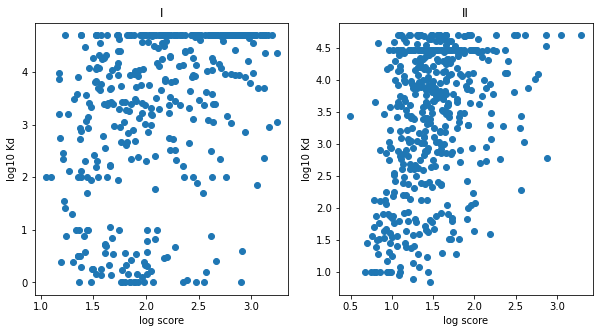

I 0.3963368345978131 0.45648041517021815
II 0.3428804938159365 0.3242764411893976


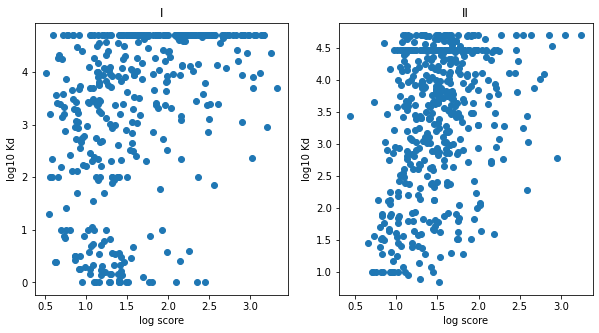

In [158]:
from scipy.stats import spearmanr
#netmhc:
#class I
#train: rms error 0.620 (squared 0.384), corr. coef. 0.884
#test : rms error 1.285 (squared 1.651), corr. coef. 0.615
#class II
#train: rms error 0.707 (squared 0.500), corr. coef. 0.822
#test : rms error 1.019 (squared 1.039), corr. coef. 0.465

plt.figure(figsize=(10,5))
for i,cl in enumerate(['I','II']):
    plt.subplot(1,2,i+1)
    df=df_lddt[df_lddt['class']==cl]
    a,b=np.log(df['score']),np.log10(df['kd'])
    plt.scatter(a,b)
    plt.xlabel('log score')
    plt.ylabel('log10 Kd')
    plt.title(cl)
    print(cl,np.corrcoef(a,b)[0,1],spearmanr(a,b)[0])
plt.show()

plt.figure(figsize=(10,5))
for i,cl in enumerate(['I','II']):
    plt.subplot(1,2,i+1)
    df=df_lddt[df_lddt['class']==cl]
    a,b=np.log(100-df['pep_anchor_lddt']),np.log10(df['kd'])
    plt.scatter(a,b)
    plt.xlabel('log score')
    plt.ylabel('log10 Kd')
    plt.title(cl)
    print(cl,np.corrcoef(a,b)[0,1],spearmanr(a,b)[0])
plt.show()

#make correction for template quality, or rather: add error prediction
#i.e. not only Kd, but also confidence
#(need to counteract relation of confidence to peplen and template quality;)
#(note: going to anchor lddt should deal with peplen already)

# pMHC assays II training set

## split into one-day batches

115836
Index(['pmhc_id', 'class', 'pep', 'mhc_a', 'mhc_b', 'kd'], dtype='object')
pep len cl II:
9        40
10       42
11      196
12      149
13     2637
14     1289
15    97797
16     4202
17     2694
18     1580
19      647
20     3907
21      611
22       11
23        9
24       16
25        9
Name: pep, dtype: int64


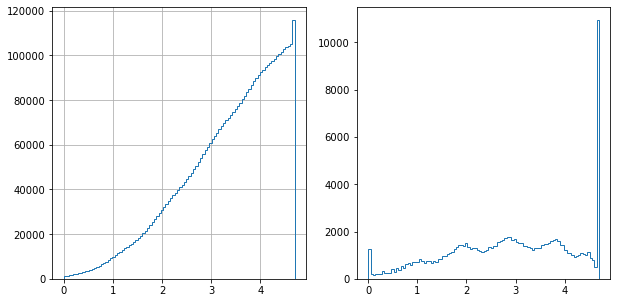

In [3]:
with open('./data/pmhc_assays/train_ii.pckl','rb') as f:
    assays=pickle.load(f)
assays=assays.sort_values('kd')
assays=assays.reset_index()
print(len(assays))

assays['pmhc_id']=assays.index.copy()
assays['class']=['II']*len(assays)
def _add_mhc(x):
    if x:
        return seq_tools.mhcs[x]
assays['mhc_a']=assays['mhc_a'].map(_add_mhc)
assays['mhc_b']=assays['mhc_b'].map(_add_mhc)
assays=assays[['pmhc_id','class','pep','mhc_a','mhc_b','kd']]
print(assays.columns)

#pep len stats
print('pep len cl II:')
print(assays['pep'].map(len).value_counts().sort_index())

#kd distrib
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(np.log10(assays['kd'].values),histtype='step',bins=100,cumulative=1)
plt.grid()
plt.subplot(122)
plt.hist(np.log10(assays['kd'].values),histtype='step',bins=100)
plt.show()

In [4]:
df_target=assays

#run seqnn
t0=time.time()
df_target=make_inputs.run_seqnn(df_target)
print('kd predicted for {:4d} pmhcs in {:5.1f} s'.format(len(df_target),time.time()-t0))

#count registers after filtering
threshold=tfold.config.af_input_params['II']['kd_threshold']
df_target['n_reg_filtered']=df_target['seqnn_logkds_all'].map(lambda y:len(y['tail'][y['logkd']-np.min(y['logkd'])<np.log10(threshold)]))

#top  10k predicted in  85.3 s
#all 115k predicted in 587.0 s

making Kd predictions for 115836 pmhcs...


2022-08-20 20:19:05.212210: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


kd predicted for 115836 pmhcs in 581.6 s


In [6]:
#count registers
utils.print_hist(df_target['n_reg_filtered'].values)
print('total regs:',df_target['n_reg_filtered'].sum())

#0.5min*2models=1min/reg
#644375*1/8/60= 1342 hr or 55 days for all data on 8 gpus

1   5791
2   9071
3   9302
4   8820
5  12233
6  16784
7  46709
8   2192
9   1681
10  1184
11  1012
12   985
13    53
14    10
15     6
16     3
total regs: 644375


models per day, on one GPU: 2468
total batches, i.e. GPU-days: 368


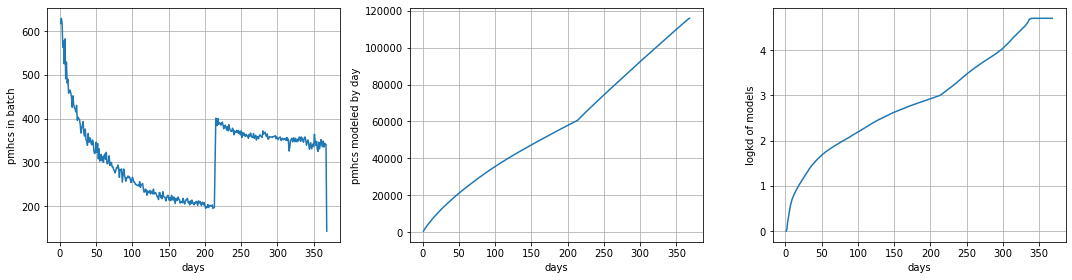

212
197 303


In [13]:
#split into 1-day batches

def _mpr_from_kd(kd): #models per register depending on Kd
    if kd<1000:
        return 2
    else:
        return 1

#time per model from test set: mean 23.2 s, max 29.5 s
#(was half cl I, half cl II)
    
t_per_model=35 #in sec, incl safety margin
models_per_day=int(24*3600/t_per_model)
print('models per day, on one GPU:',models_per_day) #on one node
models_in_batch=0
batches=[[]]
for x in df_target.iterrows():
    i,x=x[0],x[1]    
    n_models_current=_mpr_from_kd(x['kd'])*x['n_reg_filtered']
    models_in_batch+=n_models_current
    batches[-1].append(i)
    if models_in_batch>=models_per_day:
        models_in_batch=0
        batches.append([])
print('total batches, i.e. GPU-days:',len(batches))    

l_batches=[len(x) for x in batches]
l_batches_cumul=[sum(l_batches[:i]) for i in range(1,len(l_batches)+1)]
logkd_by_day=[np.log10(df_target.iloc[b[-1]]['kd']) for b in batches]

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(range(1,len(l_batches)+1),l_batches)
plt.xlabel('days')
plt.ylabel('pmhcs in batch')
plt.grid()
plt.subplot(132)
plt.plot(range(1,len(l_batches)+1),l_batches_cumul)
plt.xlabel('days')
plt.ylabel('pmhcs modeled by day')
plt.grid()
plt.subplot(133)
plt.plot(range(1,len(l_batches)+1),logkd_by_day)
plt.xlabel('days')
plt.ylabel('logkd of models')
plt.grid()
plt.tight_layout()
plt.show()

#identify when to switch mpr
for i in range(len(batches)-1):
    if len(batches[i+1])>len(batches[i])*1.5:
        print(i)
        break
print(len(batches[212]),len(batches[213]))
#from batch 213 onward, switch to mpr 1

In [23]:
#split data, save batches
assays_batches=[]
for i,b in enumerate(batches):
    assays_batch=df_target[df_target.index.isin(b)].copy()
    assays_batch.to_pickle(f'/scratch/vmikhayl/pmhc_modeling/pmhc_assays_train_II_dataset/batches/batch_{i}.pckl')        

In [24]:
print(len(os.listdir('/scratch/vmikhayl/pmhc_modeling/pmhc_assays_train_II_dataset/batches')))

368


In [4]:
#check again: first 128 batches
max_kd=0
n_total=0
for i in range(128):
    #assays_batch=df_target[df_target.index.isin(b)].copy()
    assays_batch=pd.read_pickle(f'/scratch/vmikhayl/pmhc_modeling/pmhc_assays_train_II_dataset/batches/batch_{i}.pckl')     
    n_total+=len(assays_batch)
    max_kd=max(max_kd,assays_batch['kd'].max())
print(n_total,max_kd)

42413 285.74751243366114


In [10]:
#plot register counts vs Kd

#read kd vs reg counts
target_dir='/scratch/vmikhayl/pmhc_modeling/pmhc_assays_train_II_dataset'
t0=time.time()
kd_regcounts=pd.DataFrame()
for x in os.listdir(target_dir+'/batches'):
    with open(target_dir+f'/batches/{x}','rb') as f:
        batch=pickle.load(f)
    kd_regcounts=pd.concat([kd_regcounts,batch[['kd','n_reg_filtered']]])
print('completed in:',time.time()-t0)
print(len(kd_regcounts))

completed in: 79.77193069458008
115836


In [24]:
boundaries=np.array([50,100,250,500,1000,2500,5000,10000,25000,50000])
xticks=[r'$<$'+f'{boundaries[0]}']+[f'{boundaries[i-1]}-{boundaries[i]}' for i in range(1,len(boundaries))]+[r'$\geq$'+f'{boundaries[-1]}'] #to ensure order
def annotate_interval(x):
    i=np.sum((boundaries-x)<=0)
    if i==0:
        return r'$<$'+f'{boundaries[0]}'
    elif i==len(boundaries):
        return r'$\geq$'+f'{boundaries[-1]}'
    else:
        return f'{boundaries[i-1]}-{boundaries[i]}'
    
kd_regcounts[r'$K_d$ interval']=kd_regcounts['kd'].map(annotate_interval)

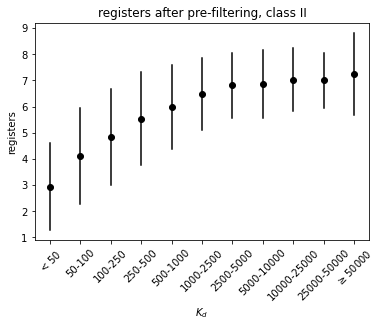

In [34]:
fig_dir='./figures_and_tables'

def plot_one(i,x,c='k'):
    plt.scatter(i,np.mean(x),color=c)
    plt.plot([i,i],[np.mean(x)-np.std(x),np.mean(x)+np.std(x)],color=c)
plt.figure()
for i,x in enumerate(xticks):
    plot_one(x,kd_regcounts[kd_regcounts[r'$K_d$ interval']==x]['n_reg_filtered'])
plt.xticks(xticks,rotation=45)
plt.title('registers after pre-filtering, class II')
plt.ylabel('registers')
plt.xlabel(r'$K_d$')
save_to=fig_dir+'/reg_per_model_class_II.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

## run modeling

2022-09-02: Finished batches 0-127 (incl) with 8 tpr (2 mpr). Now going over same batches to upgrade to 20 tpr (5 mpr)

In [6]:
upgrade=True #upgrade batches 0-127 instead of processing new batches

In [7]:
target_dir='/scratch/vmikhayl/pmhc_modeling/pmhc_assays_train_II_dataset'
target_dir_apollo='/scratch/lustre/vmikhayl/pmhc_modeling/pmhc_assays_train_II_dataset'

In [8]:
#in updating batches 64-95, errors occured for inputs:
#0,4,5,6,7,8,9,10,11,12, i.e. 0 and 4-12;
#these correspond to batches 64, 68-76

#verify by mean number of models
t0=time.time()
batch_file_counts={}
for b in os.listdir(target_dir+'/processed'):
    b_int=int(b.split('_')[-1])
    batch_file_counts[b_int]=[]
    for m in os.listdir(target_dir+f'/processed/{b}/outputs'):
        batch_file_counts[b_int].append(len(os.listdir(target_dir+f'/processed/{b}/outputs/{m}')))
    batch_file_counts[b_int]=np.mean(batch_file_counts[b_int])
print('completed in {}'.format(time.time()-t0))
for i in range(128):
    print(i,batch_file_counts[i])
    
#indeed: for b<=63, two models, because fully processed (5 mpr)
#for b>=96, also two models, because fully processed (2 mpr)
#for 64<=b<=95, expect >>2 files, but this is not true precisely for 64, 68-76; 
#i.e. no new models were added for batches 64, 68-76 due to error => redo these batches!
#after update: all fixed except batch 75; for batch 75 as before: the very first model lead to same error
#finally: all fine, updated 64-95

#96-127: errors again
#96, 102-127 to remodel

#96-127: complete!

completed in 26.07880735397339
0 2.0
1 2.0
2 2.0
3 2.0
4 2.0
5 2.0
6 2.0
7 2.0
8 2.0
9 2.0
10 2.0
11 2.0
12 2.0
13 2.0
14 2.0
15 2.0
16 2.0
17 2.0
18 2.0
19 2.0
20 2.0
21 2.0
22 2.0
23 2.0
24 2.0
25 2.0
26 2.0
27 2.0
28 2.0
29 2.0
30 2.0
31 2.0
32 2.0
33 2.0
34 2.0
35 2.0
36 2.0
37 2.0
38 2.0
39 2.0
40 2.0
41 2.0
42 2.0
43 2.0
44 2.0
45 2.0
46 2.0
47 2.0
48 2.0
49 2.0
50 2.0
51 2.0
52 2.0
53 2.0
54 2.0
55 2.0
56 2.0
57 2.0
58 2.0
59 2.0
60 2.0
61 2.0
62 2.0
63 2.0
64 2.0
65 2.0
66 2.0
67 2.0
68 2.0
69 2.0
70 2.0
71 2.0
72 2.0
73 2.0
74 2.0
75 2.0
76 2.0
77 2.0
78 2.0
79 2.0
80 2.0
81 2.0
82 2.0
83 2.0
84 2.0
85 2.0
86 2.0
87 2.0
88 2.0
89 2.0
90 2.0
91 2.0
92 2.0
93 2.0
94 2.0
95 2.0
96 24.763358778625953
97 25.606299212598426
98 25.18146718146718
99 23.466165413533833
100 23.095785440613028
101 25.176470588235293
102 26.07843137254902
103 25.944
104 26.624
105 25.0
106 25.611336032388664
107 26.177419354838708
108 26.422764227642276
109 25.40625
110 26.60082304526749
111 28.0080645161

In [15]:
#choose batches to model
n_batches=32 #how many to process in this run

if not upgrade: #new batches    
    #choose
    batches_all=sorted([int(x.split('.')[0].split('_')[-1]) for x in os.listdir(target_dir+'/batches')])
    batches_completed=sorted([int(x.split('_')[-1]) for x in os.listdir(target_dir+'/processed')])
    batches_remaining=[x for x in batches_all if x not in batches_completed]
    batches_to_model=batches_remaining[:n_batches]
    print('modeling batches:',batches_to_model) 
    #make folders
    for i in batches_to_model:
        os.mkdir(target_dir+f'/processed/batch_{i}')
        for d in ['outputs']:
            os.mkdir(target_dir+f'/processed/batch_{i}/{d}')  
else:
    with open('./tmp/batches_updated.txt','r') as f: 
        batches_updated=int(f.read())                 #how many batches already updated
    batches_to_model=list(range(batches_updated,batches_updated+n_batches))
    print('updating batches:',batches_to_model)
    with open('./tmp/batches_updated.txt','w') as f:  #update
        f.write(str(batches_updated+n_batches))

updating batches: [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [16]:
params={'II':
             {
              'templates_per_register':20,   #before update: #8, #REDUCE TO 4 FOR BATCH 213 AND ONWARD
              'pep_gap_penalty':1,
              'mhc_cutoff':25,
              'score_cutoff':None,
              'kd_threshold':100.,  
              'use_mhc_msa':False,
              'use_paired_msa':False, #not available
              'tile_registers':False,
              'shuffle':False
             }
        }

In [17]:
##functions to renumber inputs##
##USED WHEN ADDING MODELS TO ALREADY PROCESSED TARGETS##

def get_renum_dict(nreg,mpr_old,mpr_new):
    '''
    for a given number of registers, old and new models per register,
    outputs a dict to renumber models so that new numbering agrees with the old one
    on the models already made
    '''
    num_new=np.concatenate([np.arange(mpr_old*nreg).reshape([nreg,mpr_old]).T,np.arange(mpr_old*nreg,mpr_new*nreg).reshape([nreg,mpr_new-mpr_old]).T])
    num_old=np.arange(mpr_new*nreg).reshape([nreg,mpr_new]).T
    renum_dict={}
    for i,x in enumerate(num_old):
        for j,y in enumerate(x):
            renum_dict[y]=num_new[i,j]
    return renum_dict

def get_stats(inputs):
    inputs_ind=[(x['target_id'],x['registers'][0],x['current_id']) for x in inputs]    
    df=pd.DataFrame(inputs_ind,columns=['target_id','register','current_id'])
    nreg=df.drop('current_id',axis=1).drop_duplicates().groupby('target_id').apply(len).reset_index()
    nreg=nreg.rename({0:'nreg'},axis=1)
    mpr=df.groupby(['target_id','register']).apply(len).reset_index()
    mpr=mpr.rename({0:'mpr'},axis=1).drop('register',axis=1).drop_duplicates()
    stats=nreg.merge(mpr,left_on='target_id',right_on='target_id')
    stats.index=stats['target_id']
    stats=stats.drop('target_id',axis=1)
    return inputs_ind,stats

def renumber_inputs(af_inputs_old,af_inputs):
    '''
    modifies af_inputs in place (changing model numbering);
    outputs af_inputs_new, which is the inputs to be processed
    '''    
    #collect ids, nreg, mpr
    _,stats=get_stats(af_inputs)
    af_inputs_old_ind,stats_old=get_stats(af_inputs_old)    
    #renumber
    af_inputs_ind=[]
    for x in af_inputs:
        nreg,mpr_new=stats.loc[x['target_id']]['nreg'],stats.loc[x['target_id']]['mpr']
        nreg_old,mpr_old=stats_old.loc[x['target_id']]['nreg'],stats_old.loc[x['target_id']]['mpr']
        assert nreg==nreg_old
        assert mpr_new>=mpr_old
        renum_dict=get_renum_dict(nreg,mpr_old,mpr_new)
        x['current_id']=renum_dict[x['current_id']]
        af_inputs_ind.append((x['target_id'],x['registers'][0],x['current_id'])) #update index
    #verify that new and old inputs coincide where they should
    for i,k in enumerate(af_inputs_old_ind):
        j=af_inputs_ind.index(k)
        assert af_inputs_old[i]==af_inputs[j]
    print('renumbered and verified inputs;')
    return [x for x in af_inputs if (x['target_id'],x['registers'][0],x['current_id']) not in af_inputs_old_ind]

In [18]:
#read batches, make and save inputs

#if upgrade, also:
#renames input.pckl and result.pckl into input_old.pckl an result_old.pckl
#input.pckl is all inputs, input_new.pckl are inputs to model

t0=time.time()
max_n_models=0
for b in batches_to_model:
    print(f'batch {b}...')
    batch_data=pd.read_pickle(target_dir+f'/batches/batch_{b}.pckl')
    af_inputs=make_inputs.make_inputs(batch_data,params=params,date_cutoff=None,print_stats=True)  
    if not upgrade: #simply save input for new batch
        with open(target_dir+f'/processed/batch_{b}/input.pckl','wb') as f:
            pickle.dump(af_inputs,f)   
        max_n_models=max(max_n_models,len(af_inputs))
    else: #exclude template combinations that have already been processed; save new inputs and all inputs
        with open(target_dir+f'/processed/batch_{b}/input.pckl','rb') as f:
            af_inputs_old=pickle.load(f)
        af_inputs_new=renumber_inputs(af_inputs_old,af_inputs) #also renumbers af_inputs
        max_n_models=max(max_n_models,len(af_inputs_new)) #count new only: those are to be processed                
        os.rename(target_dir+f'/processed/batch_{b}/input.pckl',target_dir+f'/processed/batch_{b}/input_old.pckl')        
        os.rename(target_dir+f'/processed/batch_{b}/result.pckl',target_dir+f'/processed/batch_{b}/result_old.pckl')        
        with open(target_dir+f'/processed/batch_{b}/input.pckl','wb') as f: #all inputs
            pickle.dump(af_inputs,f)  
        with open(target_dir+f'/processed/batch_{b}/input_new.pckl','wb') as f: #new inputs to model
            pickle.dump(af_inputs_new,f)  
print('{} input files prepared in {} s'.format(len(batches_to_model),time.time()-t0))
print('max models in one batch:',max_n_models)
#run 1: 16 input files prepared in 583.1280705928802 s, max models in one batch: 2347
#run 2: 16 input files prepared in 564.7150814533234 s, max models in one batch: 2380
#run 3: 32 input files prepared in 1150.063541650772 s, max models in one batch: 2395
#run 4: 32 input files prepared in 1195.206106185913 s, max models in one batch: 2385
#run 5: 32 input files prepared in 1199.080545425415 s, max models in one batch: 2399

#adding new models to batches 0-127
#run 6: 32 input files prepared in 2851.0918169021606 s, max models in one batch: 3246
#run 7: 32 input files prepared in 2501.846592903137  s, max models in one batch: 3302
#run 8: 32 input files prepared in 2641.3825566768646 s, max models in one batch: 3151
#run 8': redoing batches 64,68-76 from run 8 due to error (no models were produced for them in run 8)
#run 8'': redoing batch 75 (batches 64, 68-74, 76 fixed successfully)
#run 9: 32 input files prepared in 2557.706256389618 s, max models in one batch: 3225

batch 96...
class II:
pmhcs: 262; runs: 5310, runs per pmhc: av 20.3, max 45; registers per pmhc: av 4.7, max 11
renumbered and verified inputs;
batch 97...
class II:
pmhcs: 254; runs: 5326, runs per pmhc: av 21.0, max 40; registers per pmhc: av 4.9, max 10
renumbered and verified inputs;
batch 98...
class II:
pmhcs: 259; runs: 5355, runs per pmhc: av 20.7, max 55; registers per pmhc: av 4.8, max 11
renumbered and verified inputs;
batch 99...
class II:
pmhcs: 266; runs: 5169, runs per pmhc: av 19.4, max 45; registers per pmhc: av 4.6, max  9
renumbered and verified inputs;
batch 100...
class II:
pmhcs: 261; runs: 5012, runs per pmhc: av 19.2, max 45; registers per pmhc: av 4.7, max 11
renumbered and verified inputs;
batch 101...
class II:
pmhcs: 255; runs: 5258, runs per pmhc: av 20.6, max 50; registers per pmhc: av 4.8, max 10
renumbered and verified inputs;
batch 102...
class II:
pmhcs: 255; runs: 5434, runs per pmhc: av 21.3, max 50; registers per pmhc: av 4.9, max 10
renumbered and

In [14]:
#manually set batches to model (assume inputs already prepared)
batches_to_model=[96]+list(range(102,128))
print(batches_to_model)

max_n_models=0
for b in batches_to_model:
    with open(target_dir+f'/processed/batch_{b}/input_new.pckl','rb') as f: #new inputs to model
        inp=pickle.load(f)
    max_n_models=max(max_n_models,len(inp))
print('max n models:',max_n_models)

[96, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
max n models: 3225


In [15]:
#split jobs

n_gpus_max=6 #CHECK!
n_tasks=len(batches_to_model)
time_per_model=35                                #in seconds, with safety margin
max_run_time=int(max_n_models*time_per_model/60) #in minutes
qos='medium' #'short' #CHECK!!  'sacctmgr list qos': short <1 day, medium <3 days
print('max run time, hrs: {:4.1f}'.format(max_run_time/60))

python_path='/data/vmikhayl/alphafold-multimer/alphafold/tfold_run_alphafold.py'
sh_path='./scripts/run_alphafold.sh'
if upgrade:
    input_str='input_new'
    print('(upgrading)')
else:
    input_str='input'

#make .sh        
lines=[]
lines.append('#!/bin/bash')
lines.append('')
lines.append(f'#SBATCH --array=0-{n_tasks-1}%{n_gpus_max}')             #run an array of n_tasks tasks
lines.append('#SBATCH --output='+target_dir_apollo+'/logs/output_%a.txt')
lines.append(f'#SBATCH --error='+target_dir_apollo+'/logs/error_%a.txt')
lines.append(f'#SBATCH --ntasks=1')                        #each array element is one task
lines.append(f'#SBATCH --gpus=1')                      #one gpu per task will use one core
lines.append(f'#SBATCH --qos={qos}')  
lines.append(f'#SBATCH --time={max_run_time}')             #maximal run time in minutes, same for each array task
#lines.append('#SBATCH --exclude=apollo01') #EXCLUDE APOLLO01 : REMOVE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
lines.append( '#SBATCH --mail-type=end')
lines.append( '#SBATCH --mail-user=vmikhayl@ias.edu')
lines.append('')
lines.append('declare -A batch_index=('+' '.join([f'["{i}"]="{j}"' for i,j in enumerate(batches_to_model)])+')')
lines.append('input_file='+target_dir_apollo+'/processed/batch_${batch_index[$SLURM_ARRAY_TASK_ID]}/'+input_str+'.pckl')
lines.append('output_dir='+target_dir_apollo+'/processed/batch_${batch_index[$SLURM_ARRAY_TASK_ID]}/outputs')
lines.append(f'srun python {python_path} --inputs $input_file --output_dir $output_dir')

if not sh_path.startswith(('/','./')):
    sh_path='./'+sh_path
with open(sh_path,'w') as f:
    f.writelines('\n'.join(lines))
os.chmod(sh_path, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)      

max run time, hrs: 31.4
(upgrading)


## assemble

In [9]:
upgrade=True #adding models to already modeled pmhcs

In [10]:
target_dir='/scratch/vmikhayl/pmhc_modeling/pmhc_assays_train_II_dataset'

In [5]:
#check results
#WARNING: logs are overwritten each run; if n_batches reduced, some logs may be old

t=[]
for x in os.listdir(target_dir+'/logs'):
    if x.startswith('output'):
        with open(target_dir+'/logs/'+x) as f:
            s=f.read().split('\n')
        if len(s)>1:
            for line in s:
                if line.startswith('time per input:'):
                    t.append(float(line.split(':')[1]))
                    break            
print('times loaded for {} runs'.format(len(t)))
print('time per structure: mean {:4.1f} s, max {:4.1f} s'.format(np.mean(t),max(t)))

#batches 0-15: tps mean 21.5, max 25.2
#batches  16-31: time per structure: mean 22.9 s, max 25.5 s
#batches  32-63: time per structure: mean 22.6 s, max 28.0 s
#batches  64-95: time per structure: mean 22.7 s, max 27.8 s
#batches 96-127: time per structure: mean 22.2 s, max 26.4 s

#batches  0-31 +3mpr: time per structure: mean 22.8 s, max 27.8 s
#batches 32-63 +3mpr: time per structure: mean 23.5 s, max 28.5 s

#batches 64-95?

#batches 96-127 +3mpr: times loaded for 27 runs (?why?), time per structure: mean 23.7 s, max 29.3 s

times loaded for 27 runs
time per structure: mean 23.7 s, max 29.3 s


In [11]:
# choose batches to process
if not upgrade:
    batches_to_parse=[]
    for x in os.listdir(target_dir+'/processed'):
        if ('result.pckl' not in os.listdir(target_dir+f'/processed/{x}')) and len(os.listdir(target_dir+f'/processed/{x}/outputs'))>0:
            batches_to_parse.append(int(x.split('_')[-1]))
    batches_to_parse=sorted(batches_to_parse)
else:
    batches_to_parse=[]
    for x in os.listdir(target_dir+'/processed'):
        if ('result.pckl' not in os.listdir(target_dir+f'/processed/{x}')) and ('result_old.pckl' in os.listdir(target_dir+f'/processed/{x}')):
            batches_to_parse.append(int(x.split('_')[-1]))
    batches_to_parse=sorted(batches_to_parse)
print('batches to parse total:',len(batches_to_parse))
print(batches_to_parse)

batches to parse total: 32
[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [12]:
#batches_to_parse=list(range(0,32)) #REMOVE

In [13]:
print('processing batches:',batches_to_parse)

processing batches: [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [14]:
#parse
#### NOTE: do not rerun this on batches where result files for some models have already been deleted! ####

from multiprocessing import Pool #parallelize!
n_cpus=10

print('processing batches:',batches_to_parse)

_get_pep_lddts=result_parse_tools._get_pep_lddts
_get_mhc_lddts=result_parse_tools._get_mhc_lddts
_seqnn_logkd_from_target_df=result_parse_tools._seqnn_logkd_from_target_df

def _process_batch(b):
    batch_dir=target_dir+f'/processed/batch_{b}'
    #read inputs
    t0=time.time()
    df1={'pmhc_id':[],'model_id':[],'tpl_tails':[],'best_score':[],'best_mhc_score':[]}
    if not upgrade:
        input_filename=batch_dir+'/input.pckl'
    else:
        input_filename=batch_dir+'/input_new.pckl' #read new only
    with open(input_filename,'rb') as f:
        c_input=pickle.load(f)
    if upgrade:
        input_ids=[(x['target_id'],x['current_id']) for x in c_input] #input ids, to ignore models not in input
    for x in c_input:
        df1['pmhc_id'].append(x['target_id'])
        df1['model_id'].append(x['current_id'])
        df1['tpl_tails'].append(x['registers'][0]) #x['registers'] is a list of one element (assume no tiling)
        df1['best_score'].append(x['best_score'])
        df1['best_mhc_score'].append(x['best_mhc_score'])
    df1=pd.DataFrame(df1)      
    #read results        
    df2={'pmhc_id':[],'model_id':[],'register_identified':[],'af_tails':[],'pep_lddt':[],'mhc_lddt':[]}    
    for pmhc_id in os.listdir(batch_dir+'/outputs'):     
        pmhc_id=int(pmhc_id)
        for result_filename in os.listdir(batch_dir+f'/outputs/{pmhc_id}'):      
            if result_filename.endswith('.pkl'):
                model_id=int(result_filename[:-4].split('_')[-1]) #assume use exactly one AF model
                if upgrade and ((pmhc_id,model_id) not in input_ids): #if upgrade, drop previously parsed models
                    continue
                with open(batch_dir+f'/outputs/{pmhc_id}/{result_filename}','rb') as f:
                    c_result=pickle.load(f)
                df2['pmhc_id'].append(pmhc_id)
                df2['model_id'].append(model_id)            
                df2['register_identified'].append(c_result['pep_renumbered'])
                df2['af_tails'].append(c_result['pep_tails'])
                df2['pep_lddt'].append(_get_pep_lddts(c_result['plddt'],c_result['pdbnum_list']))
                df2['mhc_lddt'].append(_get_mhc_lddts(c_result['plddt'],c_result['pdbnum_list']))                
    df2=pd.DataFrame(df2)    
    #merge input and result dfs, add info from df_target
    df_target=pd.read_pickle(target_dir+f'/batches/batch_{b}.pckl')
    result_df=df1.merge(df2,left_on=['pmhc_id','model_id'],right_on=['pmhc_id','model_id'])
    result_df=result_df.merge(df_target.drop(['seqnn_logkds_all','seqnn_logkd','seqnn_tails'],axis=1),
                              left_on='pmhc_id',right_on='pmhc_id')    
    #add counts of registers in all models for given target
    result_df=pd.merge(result_df,result_df.groupby('pmhc_id')['af_tails'].nunique(),left_on='pmhc_id',right_on='pmhc_id')
    result_df=result_df.rename({'af_tails_x':'af_tails','af_tails_y':'af_n_reg'},axis=1)    
    #add seqnn kd
    result_df['seqnn_logkd']=result_df.apply(lambda x: _seqnn_logkd_from_target_df(x,df_target),axis=1)    
    #save
    if upgrade: #add result from previous run
        result_old_df=pd.read_pickle(batch_dir+'/result_old.pckl')
        result_df=pd.concat([result_df,result_old_df])
    result_df.to_pickle(batch_dir+'/result.pckl')
    print(f'batch {b} completed')
    print('{:4d} outputs collected in {:6.1f} s'.format(len(result_df),time.time()-t0))

T0=time.time()
with Pool(n_cpus) as p:
    print(p.map(_process_batch, batches_to_parse))    
print('all completed in {}'.format(time.time()-T0))

# 0-15 batches in 4191 s (~ 1 hr 10 min)
#16-31 batches in 4529.698119401932
#32-63 in  8971.37277173996
#64-95 in 10628.857996702194
#96-127 in 9469.394637346268

#added multiprocessing;
#upgrading 2->5 mpr
# 0-31: 2321.2233276367188
#32-63: 2301.7951703071594

processing batches: [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
batch 100 completed
5012 outputs collected in  559.2 s
batch 99 completed
5169 outputs collected in  584.1 s
batch 101 completed
5258 outputs collected in  610.2 s
batch 97 completed
5326 outputs collected in  615.2 s
batch 98 completed
5355 outputs collected in  619.2 s
batch 105 completed
5160 outputs collected in  623.2 s
batch 103 completed
5315 outputs collected in  654.8 s
batch 96 completed
5310 outputs collected in  655.7 s
batch 102 completed
5434 outputs collected in  672.6 s
batch 104 completed
5410 outputs collected in  676.7 s
batch 106 completed
5218 outputs collected in  644.4 s
batch 107 completed
5328 outputs collected in  654.5 s
batch 110 completed
5333 outputs collected in  648.0 s
batch 109 completed
5331 outputs collected in  657.3 s
batch 108 completed
5365 outputs collected in  665.1 s
ba

In [15]:
# identify models to remove

pairs_good=set()
print('will remove some files for batches:',batches_to_parse)
for b in batches_to_parse:
    #read results, identify top models
    results_df=pd.read_pickle(target_dir+f'/processed/batch_{b}/result.pckl')
    results_df['lddt_score']=results_df['pep_lddt'].map(result_parse_tools.lddt_score)
    lddt_df=result_parse_tools.reduce_to_best(results_df,['pmhc_id'],'lddt_score',how='min')   
    #identify what models to keep    
    pairs_good|=set(lddt_df.apply(lambda x: (x['pmhc_id'],x['model_id']),axis=1).values)
pairs_good_dict={}
for x in pairs_good:
    pairs_good_dict.setdefault(x[0],[]).append(x[1])
print('pairs good:',len(pairs_good))

#verify that files for good models exist
for b in batches_to_parse:
    for pmhc_id in os.listdir(target_dir+f'/processed/batch_{b}/outputs'):
        filenames=os.listdir(target_dir+f'/processed/batch_{b}/outputs/{pmhc_id}')
        pmhc_id=int(pmhc_id)
        c_models_good=pairs_good_dict[pmhc_id]
        assert len(c_models_good)==1 #exactly one model
        m=c_models_good[0]
        assert f'result_model_1_{m}.pkl' in filenames
        assert f'structure_model_1_{m}.pdb' in filenames        
print('...verified')            

will remove some files for batches: [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
pairs good: 7814
...verified


In [16]:
### REMOVE ###
n=0
t0=time.time()
for b in batches_to_parse:
    for pmhc_id in os.listdir(target_dir+f'/processed/batch_{b}/outputs'):
        filenames=os.listdir(target_dir+f'/processed/batch_{b}/outputs/{pmhc_id}')
        pmhc_id=int(pmhc_id)        
        m=pairs_good_dict[pmhc_id][0]
        good_filenames=[f'result_model_1_{m}.pkl',f'structure_model_1_{m}.pdb']                
        filenames_to_remove=[f for f in filenames if f not in good_filenames]
        assert len(filenames)-len(filenames_to_remove)==2 #exactly two files left        
        for f in filenames_to_remove:
            os.remove(target_dir+f'/processed/batch_{b}/outputs/{pmhc_id}/{f}')            
            n+=1
print('removed {} files in {} s'.format(n,time.time()-t0))

#run 2: removed 61738 files in 37.97850680351257 s
#run 3: removed 129294 files in 64.03688430786133 s
#run 4: removed 131174 files in 40.18000674247742 s

#run 5???

#run 6: removed 197729 files in 111.68219876289368 s  #1st run for mpr 2->5
#run 7: removed 198604 files in 94.34932613372803 s
#run 8 (incl 8',8''): removed 192322 files in 62.832563400268555 s

#last run (96-127): removed 190334 files in 54.658660650253296 s

removed 190334 files in 54.658660650253296 s


### plot statistics

In [ ]:
## STATS FOR RUN 1 (top Kd) ##

In [89]:
#collect data from batches

results_df=[]
for b in batches_to_parse:
    results_df.append(pd.read_pickle(target_dir+f'/processed/batch_{b}/result.pckl'))
results_df=pd.concat(results_df)
print(len(results_df))
print(results_df.columns)

36794
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'class',
       'pep', 'mhc_a', 'mhc_b', 'kd', 'n_reg_filtered', 'af_n_reg',
       'seqnn_logkd'],
      dtype='object')


In [90]:
results_df['lddt_score']=results_df['pep_lddt'].map(result_parse_tools.lddt_score)
lddt_df=result_parse_tools.reduce_to_best(results_df,['pmhc_id'],'lddt_score',how='min')
print(len(results_df))
print(len(lddt_df))

36794
8396


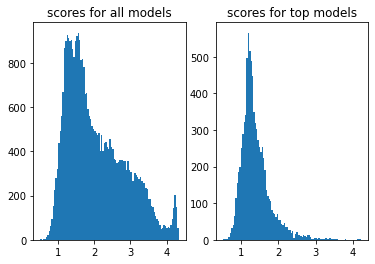

In [92]:
plt.figure()
plt.subplot(121)
plt.hist(results_df['lddt_score'],bins=100)
plt.title('scores for all models')
plt.subplot(122)
plt.hist(lddt_df['lddt_score'],bins=100)
plt.title('scores for top models')
plt.show()

In [107]:
#sort scores, plot 1st, 2nd and so on
reduced_scores=results_df.groupby(['pmhc_id','af_tails'])['lddt_score'].min().reset_index()
scores_sorted=reduced_scores.groupby('pmhc_id')['lddt_score'].apply(np.sort).reset_index()
scores_by_rank={}
for x in scores_sorted['lddt_score']:
    for i,y in enumerate(x):
        scores_by_rank.setdefault(i+1,[]).append(y)
for i,v in scores_by_rank.items():
    print('rank: {}, scores: {}'.format(i,len(v)))

rank: 1, scores: 8396
rank: 2, scores: 5609
rank: 3, scores: 3134
rank: 4, scores: 1622
rank: 5, scores: 810
rank: 6, scores: 338
rank: 7, scores: 101
rank: 8, scores: 23
rank: 9, scores: 6
rank: 10, scores: 3
rank: 11, scores: 2
rank: 12, scores: 1


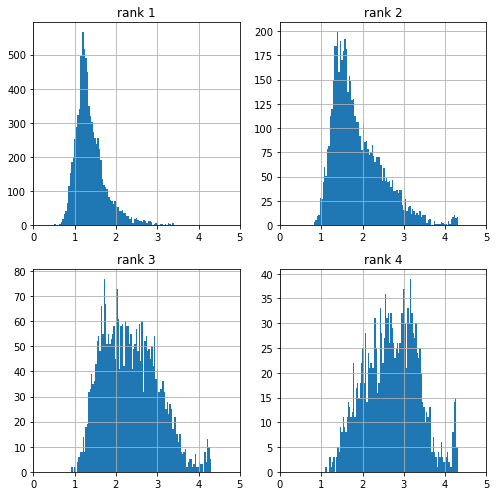

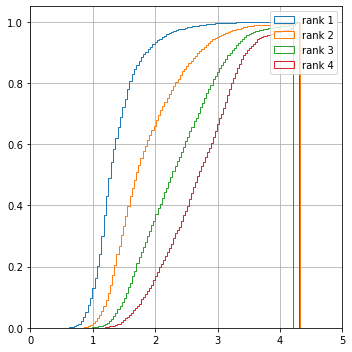

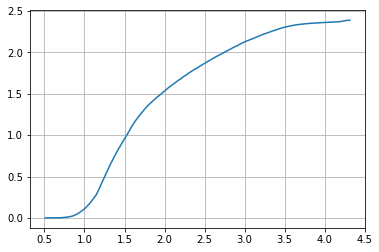

In [113]:
#score histograms by rank
plt.figure(figsize=(7,7))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.grid()
    plt.hist(scores_by_rank[i+1],bins=100)
    plt.xlim(0,5)    
    plt.title(f'rank {i+1}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.grid()
for i in range(4):    
    plt.hist(scores_by_rank[i+1],bins=100,density=True,cumulative=1,histtype='step')
plt.xlim(0,5)
plt.legend([f'rank {i}' for i in range(1,5)])
plt.tight_layout()
plt.show()

#score cutoff vs reg per pmhc (only keep top score for each reg)
n_pmhcs=len(reduced_scores['pmhc_id'].unique())
thresholds=np.sort(reduced_scores['lddt_score'].unique())
reg_per_query=[np.sum(reduced_scores['lddt_score']<t)/n_pmhcs for t in thresholds]
plt.figure()
plt.plot(thresholds,reg_per_query)
plt.grid()
plt.show()

# old_dataset 1: pMHCs with experimental structures (before AF training set cutoff)

In [3]:
#where to put inputs and outputs ##SET PATH HERE
#dataset_dir='/scratch/vmikhayl/pmhc_modeling/dataset1'  
dataset_dir='/scratch/vmikhayl/pmhc_modeling/dataset1.1'  

Which structures to model?
- exclude structures with hetero residues in the peptide
- impose AF date_cutoff for now. Reserve structures after the cutoff for the test set
- one pmhc sequence can adopt multiple binding registers. Exclude these and look at them later separately
- peptide length:
    - cl I: keep len <=12. Covers 92% of presented peptidome, according to IEDB elution data; peps with len<=12 in our dataset (checked only date<=date_cutoff) have overhangs of at most 1, while len=13 has overhang 5 which must be a linker. Restricting to len<=12 allows not to worry about that
    - cl II: keep len<=22. Covers 94% of presented peptidome, according to IEDB elution data; for longer cl II peps in the data, cut them to 22 symmetrically

## prepare inputs: choose data to model, assign templates, make inputs

In [43]:
#collect data to model, cut cl II peptides to len 22
exclude_set={'6d78_0','6eqb_0','6eqa_0','3qfd_0','3qfd_1','2guo_0','2guo_1','3qdj_0','3qeq_0',
             '3o3b_0','3o3b_1','3o3d_0','3o3d_1','4z78_0','4z78_1','6amt_0','6amt_1','6amu_0',
             '2bvo_0','2bvq_0','3o3a_0','3o3a_1','3o3e_0','3o3e_1','3d3v_0','3d39_0'} #multiple registers 
exclude_id=[]
for x in pmhcs:
    pdb_set=set([y[0] for y in x['pdbs']])  
    if pdb_set&exclude_set:
        exclude_id.append(x['id'])        
pmhcs_to_model=[]
for x in pmhcs_seq_clusters:
    if x['date']>date_cutoff:  #date after cutoff
        continue    
    pmhc_ids=[i for i in x['pmhc_ids'] if i not in exclude_id]  #in exclude_set
    pmhc_ids=[i for i in pmhc_ids if 'X' not in pmhcs[i]['P']['data']['seq']]  #hetero residues in pep
    if len(pmhc_ids)==0:        
        continue
    y=pmhcs[pmhc_ids[0]]
    cl=y['class']
    peplen=len(y['P']['data'])
    if cl=='I' and peplen>12:  #cl I, peptide too long
        continue
    if cl=='II' and peplen>22: #filter added in 1.1
        continue               #filter added in 1.1
    pmhc_id=pmhc_ids[0]    
    pmhc=pmhcs[pmhc_id]
    cluster_seq_id=pmhc['cluster_seq']    
    pep=pmhc['P']['data']['seq']
    mhc_A=pmhc['M']['data']
    if cl=='II':
        mhc_B=pmhc['N']['data']
        ##removed in 1.1
        #l=len(pep)
        #if l>22:          #cl II, cut long peptides
        #    dl=(l-22)//2
        #    dr=(l-22)-dl
        #    pep=pep[dl:-dr]  
        ##
    else:
        mhc_B=None
    pmhcs_to_model.append({'pmhc_id':pmhc_id,'cluster_seq':cluster_seq_id,'class':cl,'P':pep,'M':mhc_A,'N':mhc_B})
print(len(pmhcs_to_model))                        

333


In [44]:
#make AF params file
output_dir=dataset_dir+'/outputs'
output_dir=re.sub('scratch','scratch/lustre',output_dir) #for apollo ###REMOVE THIS IF NOT USING THE IAS CLUSTER!###
params={'num_ensemble':1,'model_names':('model_1',),'relax':False,'chain_break_shift':200,
        'output_dir':output_dir}

with open(dataset_dir+'/params.pckl','wb') as f:
    pickle.dump(params,f)

In [9]:
#load seqnn register predicitions
with open('./tmp/seqnn_regs_i.pckl','rb') as f:
    seqnn_registers_i=pickle.load(f)
with open('./tmp/seqnn_regs_ii.pckl','rb') as f:
    seqnn_registers_ii=pickle.load(f)
print(len(seqnn_registers_i),len(seqnn_registers_ii))

275 58


In [10]:
#functions for filtering registers
def tails_from_pdbnum_i(pdbnum):
    pdbnum=np.array(pdbnum)
    if pdbnum[0]=='   2 ':
        n_left=-1
    elif pdbnum[0]<'   2 ':
        n_left=np.nonzero(pdbnum=='   1 ')[0][0]
    else:
        raise ValueError(f'check pdbnum {pdbnum}')
    n_right=int(pdbnum[-1])-9
    regindex={(0,0):0,(-1,0):1,(1,0):2,(0,1):3}
    return regindex[n_left,n_right]
def tails_from_pdbnum_ii(pdbnum):
    pdbnum=np.array(pdbnum)
    if pdbnum[0]=='   2 ':
        n_left=-1
    elif pdbnum[0]<'   2 ':
        n_left=np.nonzero(pdbnum=='   1 ')[0][0]
    else:
        raise ValueError(f'check pdbnum {pdbnum}')    
    return n_left
def filter_registers(c,tid,cl):    
    if cl=='I':
        tails_func=tails_from_pdbnum_i
        reg_keep=seqnn_registers_i
    else:
        tails_func=tails_from_pdbnum_ii
        reg_keep=seqnn_registers_ii
    c1=[]
    for a in c:        
        if tails_func(a['pdbnum']) in reg_keep[tid]:
            c1.append(a)
    return c1

total inputs: 2456
completed in  38.8 s
registers per query, average:
cl I: 1.2618181818181817
cl II: 4.603448275862069


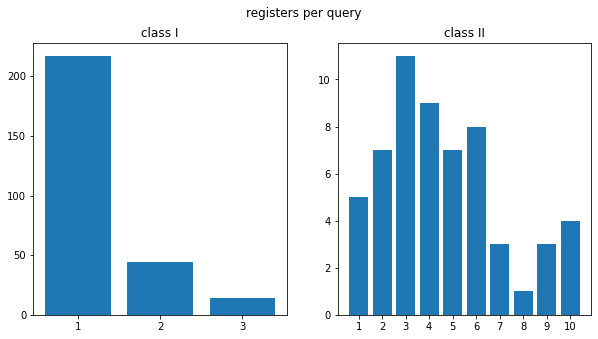

In [55]:
#assign templates, make AF input files

clusters_per_register={'I':4,'II':4} #how many CA clusters to keep per peptide register
reg_per_query={'I':[],'II':[]}      #to check filtering by seqnn
t0=time.time()
input_data_all=[]
for x in pmhcs_to_model: 
    #assign templates        
    clusters_assigned=template_tools.assign_templates(x['class'],x['P'],x['M'],x.get('N'),
                                                      clusters_per_register=clusters_per_register[x['class']],
                                                      cluster_id=x['cluster_seq'],score_filter=None)    
    clusters_assigned=filter_registers(clusters_assigned,x['pmhc_id'],x['class']) #only keep registers approved by seqnn
    reg_per_query[x['class']].append(len(clusters_assigned))
    sequences=[''.join(x['P'])]    
    msas=[]    
    mhc_A_query=seq_tools.NUMSEQ(data=x['M'])    
    renumber_list_mhc=['M'+a for a in mhc_A_query.data['pdbnum']]
    sequences.append(mhc_A_query.seq())
    msas_filenames=get_mhc_msa_filenames(x['class'],'A',mhc_A_query.data['pdbnum'])
    msas+=[{'chain':1,'filename':f} for f in msas_filenames]
    if x['class']=='II':
        mhc_B_query=seq_tools.NUMSEQ(data=x['N'])  
        renumber_list_mhc+=['N'+a for a in mhc_B_query.data['pdbnum']]
        sequences.append(mhc_B_query.seq())
        msas_filenames=get_mhc_msa_filenames(x['class'],'B',mhc_B_query.data['pdbnum'])
        msas+=[{'chain':2,'filename':f} for f in msas_filenames]
    input_id=0
    #make hits
    for cluster_pdbnum in clusters_assigned:
        pep_query=seq_tools.NUMSEQ(seq=x['P'],pdbnum=cluster_pdbnum['pdbnum'])
        renumber_list=['P'+a for a in pep_query.data['pdbnum']]+renumber_list_mhc        
        for cluster_CA in cluster_pdbnum['clusters']:
            template_hits=[]
            #make hits for CA cluster            
            for hit_i,pmhc_hit in enumerate(cluster_CA):
                fragment_alignments=[]
                pdb_id=pmhcs[pmhc_hit['pmhc_id']]['pdbs'][0][0]
                summary_record=summary[pdb_id]
                pep_target=seq_tools.load_NUMSEQ(summary_record['P'])
                pep_target=pep_target.ungap_small()
                fragment_alignments.append(template_tools.align_numseq(pep_query,pep_target))
                mhc_A_target=seq_tools.load_NUMSEQ(summary_record['M'])
                mhc_A_target=mhc_A_target.ungap_small()
                fragment_alignments.append(template_tools.align_numseq(mhc_A_query,mhc_A_target))
                if x['class']=='II':
                    mhc_B_target=seq_tools.load_NUMSEQ(summary_record['N'])
                    mhc_B_target=mhc_B_target.ungap_small()
                    fragment_alignments.append(template_tools.align_numseq(mhc_B_query,mhc_B_target))
                hit=template_tools.join_fragment_alignments(fragment_alignments)
                template_hit={}
                template_hit['index']=hit_i
                template_hit['name']=pdb_id                
                template_hit['aligned_cols']=len(hit['query_seq'])-hit['query_seq'].count('-')-hit['target_seq'].count('-')
                template_hit['sum_probs']=1000-(pmhc_hit['pep_score']+pmhc_hit['mhc_score'])
                template_hit['query']=hit['query_seq']
                template_hit['hit_sequence']=hit['target_seq']
                template_hit['indices_query']=hit['indices_query']
                template_hit['indices_hit']=hit['indices_target']                                
                template_hits.append(template_hit)
            #make input for CA cluster
            input_data={}
            input_data['sequences']=sequences
            input_data['msas']=msas
            input_data['template_hits']=template_hits
            input_data['renumber_list']=renumber_list
            input_data['target_id']=x['pmhc_id']      #pmhc id of query            
            input_data['current_id']=input_id
            input_id+=1
            #additional info (not used by AlphaFold)
            input_data['top_hit']=cluster_CA[0]  #pmhc_id,pep_score,mhc_score of top hits
            input_data['n_hits']=len(cluster_CA) #total templates in cluster
            input_data['cluster_CA']=pmhcs[cluster_CA[0]['pmhc_id']]['cluster_CA'] #cluster_CA id
            input_data['pep_pdbnum']=cluster_pdbnum['pdbnum']
            input_data_all.append(input_data)            
            
with open(dataset_dir+f'/input_data.pckl','wb') as f:
    pickle.dump(input_data_all,f)
print('total inputs:',len(input_data_all))
print('completed in {:5.1f} s'.format(time.time()-t0))
print('registers per query, average:')
print('cl I:',np.average(reg_per_query['I']))
print('cl II:',np.average(reg_per_query['II']))

plt.figure(figsize=(10,5))
for i,cl in enumerate(['I','II']):
    plt.subplot(121+i)
    x=np.array(reg_per_query[cl])
    xu=np.sort(np.unique(x))
    plt.bar(xu,[np.sum(x==a) for a in xu])
    plt.xticks(xu)
    plt.title(f'class {cl}')
plt.suptitle('registers per query')
plt.show()

In [56]:
#check number of modeling tasks by class
n={}
for x in input_data_all:
    cl=pmhcs[x['target_id']]['class']
    n.setdefault(cl,0)
    n[cl]+=1
print(n)
#1632 118
#4400 1960 (dataset 1, cl ii 68 (len<=24))
#1388 1068(dataset 1.1, cl ii 58 (len<=22), registers filtered by seqnn)
#(cl 2 prev proportional: 1960/68*58~1671)
#for future: experiment with more clusters per register; potentially can make things worse, actually

{'I': 1388, 'II': 1068}


Next you can run AF as `tfold_run_alphafold.py --inputs $dataset_dir/input_data.pckl --params $dataset_dir/params.pckl`, however, if you have multiple GPUs, you need to first split the inputs. In the next cell, we split the inputs over 8 tasks and make a SLURM script to run the tasks on the IAS cluster. You will likely need to modify it according to your cluster configuration.

In [74]:
#split jobs

########CHANGE THE PATHS AND THE SCRIPTS IN THIS CELL ACCORDING TO YOUR SYSTEM!########

import stat

inputs=input_data_all

dataset_dir_lustre=re.sub('scratch','scratch/lustre',dataset_dir)

python_path='/data/vmikhayl/alphafold-multimer/alphafold/tfold_run_alphafold.py'
params_path=dataset_dir_lustre+'/params.pckl'
sh_path='./scripts/run_alphafold.sh'

n_tasks=8
exclusive=False #True
gpu=True
qos='short'
max_run_time=8*60 #8 hours: check!
slow_nodes=[]

input_dir              =dataset_dir+'/tmp_inputs'
input_dir_server       =dataset_dir_lustre+'/tmp_inputs'
input_dir_proper       =input_dir+'/inputs'
input_dir_server_proper=input_dir_server+'/inputs'
log_dir                =input_dir+'/logs'
log_dir_server         =input_dir_server+'/logs'
#make dirs
for d in [input_dir_proper,log_dir]:
    os.makedirs(d,exist_ok=True)    
#make input files
indices=utils.split_jobs(len(inputs),n_tasks)
n_tasks=len(indices)
for i,job in enumerate(indices):
    c_inputs=[inputs[j] for j in job]        
    with open(input_dir_proper+'/input_'+str(i)+'.pckl','wb') as f:
        pickle.dump(c_inputs,f)            

#make .sh        
lines=[]
lines.append('#!/bin/bash')
lines.append('')
for x in slow_nodes:
    lines.append('#SBATCH --exclude=node{}'.format(x))     #exclude slow nodes        
lines.append(f'#SBATCH --array=0-{n_tasks-1}')             #run an array of n_tasks tasks
lines.append(f'#SBATCH --output={log_dir_server}/output_%a.txt')  #here %a will evaluate to array task id
lines.append(f'#SBATCH --error={log_dir_server}/error_%a.txt')
lines.append(f'#SBATCH --ntasks=1')                        #each array element is one task
if exclusive:
    lines.append(f'#SBATCH --exclusive')                   #request exclusive use of node, e.g. for hhblits
if gpu:
    lines.append(f'#SBATCH --gpus=1')                      #one gpu per task will use one core
elif not exclusive:
    lines.append(f'#SBATCH --cpus-per-task=1')             #one cpu per task
lines.append(f'#SBATCH --qos={qos}')  
lines.append(f'#SBATCH --time={max_run_time}')             #maximal run time in minutes, same for each array task
lines.append('')
lines.append(f'input_file={input_dir_server_proper}/input_$SLURM_ARRAY_TASK_ID.pckl')        
lines.append(f'srun python {python_path} --inputs $input_file --params {params_path}')

if not sh_path.startswith(('/','./')):
    sh_path='./'+sh_path
with open(sh_path,'w') as f:
    f.writelines('\n'.join(lines))
os.chmod(sh_path, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)      

In [58]:
#runtime: 30.5s/task on 40 tasks, NVIDIA A100 40GB GPU

# IAS cluster: 2 apollo nodes with 8 GPUs per node
# 8 gpus: 8*3600/30=960 models/hr

#6360 tasks: 6.6hr expected on 8 gpus
#2456 tasks: 2.6hr expected

In [ ]:
#cl 2: 1000 models for 58
#1.7mln for 100k
#14000 gpu hours

In [483]:
#check results and times
n=0
for x in os.listdir(dataset_dir+'/outputs'):
    for y in os.listdir(dataset_dir+'/outputs/'+x):
        if y.startswith('structure'):
            n+=1
print('models produced:',n)  

NameError: name 'dataset_dir' is not defined

In [482]:
s='( 45.6 s per input)'


'45.6'

## analyze results

### renumber peptides, compute rmsds, read outputs

Here we make SLURM tasks to run peptide renumbering and RMSD computations in `postprocessing.py`.

In [12]:
#prepare SLURM jobs

source_dir=os.getcwd()+'/data/experimental_structures/processed_updated' #path to structure database
input_dir='/scratch/vmikhayl/tmp_postprocessing'           
#input_dir_server='/scratch/lustre/vmikhayl/tmp_pdb_processing'   #typhon
input_dir_server=input_dir                                        #helios

inputs=[[dataset_dir+'/outputs/'+x] for x in os.listdir(dataset_dir+'/outputs')]
print('inputs:',len(inputs))

n_tasks=200 #112#56     #our cluster: 64 nodes * 28 cores
max_run_time=100    #in minutes
qos='short' #medium 
local=False #CHECK!
slow_nodes=[]

sh_path='./postprocessing.sh'
python_path='./postprocessing.py'
argstring=f'--renumber 1 --rmsds 1 --source_dir {source_dir}'
                                                        
n_tasks=utils.make_task(inputs,n_tasks,sh_path,python_path,input_dir,input_dir_server=input_dir_server,
                        qos=qos,max_run_time=max_run_time,slow_nodes=slow_nodes,local=local,argstring=argstring)
print('n tasks:',n_tasks)

inputs: 343
n tasks: 172


This script reads the outputs, including pLDDTs, and makes a `pandas` dataframe.
- peptide pLDDT averaged over the extended binding core
- this script is slow (~0.02 s/model)

In [67]:
result_parse_tools.parse_outputs(dataset_dir,source_dir)

#to do: add query to best template CA rmsd to see how much refinement with AF really matters

processed 6360 records in  57.2 s


### plot

The output of `result_parse_tools.parse_outputs` is a dataframe with the following columns:
- `tid`: `target_id`
- `pepseq`: peptide sequence
- `mhc`: MHC allele
- `cl`: MHC class
- `cid`: `current_id`
- `pdbnum`: the true peptide binding register
- `pdbnum_template`: peptide pdbnum assigned
- `pdbnum_model`: actual peptide pdbnum in the model, or error if not assigned
- `match`: whether the assigned template binding register in a given model is the correct one
- `pep_s`: peptide mismatch score for the top template
- `mhc_s`: MHC mismatch score for the top template
- `pep_lddt`: average predicted LDDT for the peptide. !TO DO: restrict pLDDT to the binding core!
- `mhc_lddt`: average predicted LDDT for the MHC
- `pep_CA`: peptide CA RMSD
- `pep_all`: peptide all-atom RMSD
- `mhc_CA`: MHC CA RMSD
- `mhc_all`: MHC all-atom RMSD

In [4]:
dataset_dir='/scratch/vmikhayl/pmhc_modeling/dataset1'
#dataset_dir='/scratch/vmikhayl/pmhc_modeling/dataset1.1'

In [5]:
#read the output of result_parse_tools.parse_outputs
results_df=pd.read_pickle(dataset_dir+'/result_df.pckl')
print(len(results_df))
print(results_df.columns)
print(results_df.head(5))
#split by class
results_dfs={cl:results_df[results_df['cl']==cl] for cl in ['I','II']}

6360
Index(['tid', 'pepseq', 'mhc', 'cl', 'cid', 'pdbnum', 'pdbnum_template',
       'match', 'pep_s', 'mhc_s', 'pep_lddt', 'mhc_lddt', 'pep_CA', 'pep_all',
       'mhc_CA', 'mhc_all', 'pdbnum_model'],
      dtype='object')
      tid      pepseq        mhc cl  cid                pdbnum  \
5392    0  AIMPARFYPK  A*11:394   I    0  1,2,3,4,5,51,6,7,8,9   
5388    0  AIMPARFYPK  A*11:394   I    1  1,2,3,4,5,51,6,7,8,9   
5399    0  AIMPARFYPK  A*11:394   I    2  1,2,3,4,5,51,6,7,8,9   
5397    0  AIMPARFYPK  A*11:394   I    3  1,2,3,4,5,51,6,7,8,9   
5389    0  AIMPARFYPK  A*11:394   I    4  1,2,3,4,5,51,6,7,8,9   

            pdbnum_template  match  pep_s  mhc_s   pep_lddt   mhc_lddt  \
5392  2,3,4,5,51,59,6,7,8,9   True      8      0  75.464865  96.400930   
5388  2,3,4,5,51,59,6,7,8,9   True      9      0  72.971190  96.523822   
5399  2,3,4,5,51,59,6,7,8,9  False      9      0  69.197834  96.298294   
5397  2,3,4,5,51,59,6,7,8,9   True      9      0  74.528402  96.628583   
5389   1,

In [11]:
#filter registers by seqnn prediction
def _restore_pdbnum(x):
    x1=[]
    for a in x.split(','):
        if a[0]<='9':
            if len(a)==1:
                x1.append('   '+a+' ')
            elif len(a)==2:
                x1.append('   '+a)
            else:
                raise ValueError(a)
        else:
            x1.append('  '+a+' ')
    return x1

def filter_results_by_register_i(x):          
    tid,pdbnum=x
    pdbnum=_restore_pdbnum(pdbnum)
    tails_func=tails_from_pdbnum_i
    reg_keep=seqnn_registers_i       
    return (tid in reg_keep) and (tails_func(pdbnum) in reg_keep[tid])
def filter_results_by_register_ii(x):    
    tid,pdbnum=x
    pdbnum=_restore_pdbnum(pdbnum)
    tails_func=tails_from_pdbnum_ii
    reg_keep=seqnn_registers_ii        
    return (tid in reg_keep) and (tails_func(pdbnum) in reg_keep[tid])
df1=results_dfs['I'].copy()
df1['filter']=df1[['tid','pdbnum_template']].apply(tuple,axis=1).map(filter_results_by_register_i)
df1=df1[df1['filter']]
df2=results_dfs['II'].copy()
df2['filter']=df2[['tid','pdbnum_template']].apply(tuple,axis=1).map(filter_results_by_register_ii)
df2=df2[df2['filter']]

In [12]:
#FILTERED
dfs={'I':df1,'II':df2}

#for each target_id, choose the model with the best peptide CA rmsd
#(gives upper bound on accuracy)
results_best_rmsd=result_parse_tools.reduce_to_best_all(dfs,['tid'],'pep_CA',how='min')
#for each target_id, choose the model with the best peptide predicted LDDT 
#(real life accuracy estimate)
results_best_score=result_parse_tools.reduce_to_best_all(dfs,['tid'],'pep_lddt',how='max')

#print RMSD values
columns=['pep_CA','pep_all']
print(' '*15+(' '*36).join(columns))
print(' '*15+'        '.join(['      '.join(['mean','std ','min ','max '])]*2))
print('cl I')
result_parse_tools.summarize_columns(results_best_rmsd['I'],columns,s0='best rmsd ',nl=6,nr=2)
result_parse_tools.summarize_columns(results_best_score['I'],columns,s0='best score',nl=6,nr=2)
print('cl II')
result_parse_tools.summarize_columns(results_best_rmsd['II'],columns,s0='best rmsd ',nl=6,nr=2)
result_parse_tools.summarize_columns(results_best_score['II'],columns,s0='best score',nl=6,nr=2)

#NOTE: better performance for cl II can be explained by removed len>22!!!

               pep_CA                                    pep_all
               mean      std       min       max         mean      std       min       max 
cl I
best rmsd      0.84      0.64      0.22      5.43;       1.68      0.89      0.37      6.01;  
best score     1.04      0.79      0.22      6.00;       1.90      1.04      0.53      6.43;  
cl II
best rmsd      0.66      0.65      0.22      3.67;       1.54      1.03      0.58      6.49;  
best score     1.53      3.06      0.22     17.47;       2.30      3.12      0.58     18.55;  


In [118]:
x=results_best_score['I']
print(len(x))
print(np.sum(x['pdbnum']!=x['pdbnum_model']))

x=results_best_score['II']
print(len(x))
print(np.sum(x['pdbnum']!=x['pdbnum_model']))
print('cl ii errors:',x[x['pdbnum']!=x['pdbnum_model']]['tid'])

#cl ii
#mistakes without filter:
#157  157         DIFERIASEASRL   DRA*01:01 DRB1*04:04  II   16   
#405  405       KRIAKAVNEKSCNCL  DRA*01:02 DRB1*04:274  II   27   
#715  715       TSKGLFRAAVPSGAS  DRA*01:02 DRB1*04:274  II   16   
#809  809  GWISLWKGFSFGSGGSIEGR   DRA*01:01 DRB1*01:01  II   16   
#850  850  SRLGLWSRMDQLAKELTAEL           IAA*d IAB*g7  II   31   
#157,     405,715,809,850
#mistakes with filter:
#157,368,405,715,809,850
#extra: 368 (netmhc was missing 2: 368,393; somehow 393 recovered by reg jumping!!)
print(x[x['tid']==393])

275
9
58
6
cl ii errors: tid
157    157
368    368
405    405
715    715
809    809
850    850
Name: tid, dtype: int64
     tid      pepseq                   mhc  cl  cid                 pdbnum  \
tid                                                                          
393  393  GKQNCLKLAT  DRA*01:01 DRB1*01:01  II    0  2,3,4,5,6,7,8,9,10,11   

          pdbnum_template  match  pep_s  mhc_s   pep_lddt   mhc_lddt  \
tid                                                                    
393  1,2,3,4,5,6,7,8,9,10   True     12      0  96.493481  96.839178   

       pep_CA  pep_all    mhc_CA   mhc_all           pdbnum_model  filter  
tid                                                                        
393  0.559474  0.81373  1.219594  1.931722  2,3,4,5,6,7,8,9,10,11    True  


In [114]:
#reg per model
np.average([len(x) for x in seqnn_registers_i.values()])

1.2618181818181817

In [37]:
#plot by pep length
x=results_best_score['I']
x9=x[x['pepseq'].map(len)==9]
x.columns

Index(['tid', 'pepseq', 'mhc', 'cl', 'cid', 'pdbnum', 'pdbnum_template',
       'match', 'pep_s', 'mhc_s', 'pep_lddt', 'mhc_lddt', 'pep_CA', 'pep_all',
       'mhc_CA', 'mhc_all', 'pdbnum_model', 'filter'],
      dtype='object')

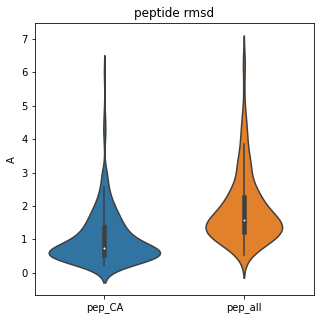

all len: 0.7484463255168791 1.5653400550163996
9-mers: 0.7491794103968155 1.5625202673734506
total: 275 172


In [38]:
#plt.figure(figsize=(10,5))
plt.figure(figsize=(5,5))
#plt.subplot(121)
sns.violinplot(data=x[['pep_CA','pep_all']])
#plt.subplot(122)
plt.title('peptide rmsd')
plt.ylabel('A')
#sns.violinplot(data=x9[['pep_CA','pep_all']])
plt.show()
print('all len:',x['pep_CA'].median(),x['pep_all'].median())
print('9-mers:',x9['pep_CA'].median(),x9['pep_all'].median())
print('total:',len(x),len(x9))

In [29]:
#high quality, medium, acceptable, incorrect
f0=0
for a in [1,2,5,10]:
    f=np.sum(x['pep_CA']<a)/len(x)
    print(a, f-f0)
    f0=f

1 0.6254545454545455
2 0.27636363636363637
5 0.09454545454545449
10 0.0036363636363636598


In [32]:
x=results_best_score['II']
x.columns,len(x)

(Index(['tid', 'pepseq', 'mhc', 'cl', 'cid', 'pdbnum', 'pdbnum_template',
        'match', 'pep_s', 'mhc_s', 'pep_lddt', 'mhc_lddt', 'pep_CA', 'pep_all',
        'mhc_CA', 'mhc_all', 'pdbnum_model', 'filter'],
       dtype='object'),
 58)

In [35]:
y=x[x['pdbnum_model']==x['pdbnum']] #6 errors, because filtered
len(y)

52

In [36]:
y['pep_CA'].median(),y['pep_all'].median()

(0.4872705763319861, 1.2933225676588518)

In [69]:
#for each target_id, choose the model with the best peptide CA rmsd
#(gives upper bound on accuracy)
results_best_rmsd=result_parse_tools.reduce_to_best_all(results_dfs,['tid'],'pep_CA',how='min')
#for each target_id, choose the model with the best peptide predicted LDDT 
#(real life accuracy estimate)
results_best_score=result_parse_tools.reduce_to_best_all(results_dfs,['tid'],'pep_lddt',how='max')

#print RMSD values
columns=['pep_CA','pep_all']
print(' '*15+(' '*36).join(columns))
print(' '*15+'        '.join(['      '.join(['mean','std ','min ','max '])]*2))
print('cl I')
result_parse_tools.summarize_columns(results_best_rmsd['I'],columns,s0='best rmsd ',nl=6,nr=2)
result_parse_tools.summarize_columns(results_best_score['I'],columns,s0='best score',nl=6,nr=2)
print('cl II')
result_parse_tools.summarize_columns(results_best_rmsd['II'],columns,s0='best rmsd ',nl=6,nr=2)
result_parse_tools.summarize_columns(results_best_score['II'],columns,s0='best score',nl=6,nr=2)

               pep_CA                                    pep_all
               mean      std       min       max         mean      std       min       max 
cl I
best rmsd      0.77      0.58      0.22      5.33;       1.59      0.80      0.37      6.01;  
best score     1.16      1.05      0.22      7.78;       2.04      1.27      0.53      8.13;  
cl II
best rmsd      0.73      0.87      0.22      5.58;       1.56      1.07      0.58      6.13;  
best score     2.03      3.36      0.22     17.47;       2.79      3.34      0.58     18.55;  


In [72]:
#errors in pdbnum assignment
for cl in ['I','II']:
    for name,df in zip(['score','rmsd'],[results_best_score[cl],results_best_rmsd[cl]]):
        print(cl,name)
        print('error in pdbnum:')
        print(df[df['pdbnum_model']=='error'])
        
#conclusion: rmsds not great

I score
error in pdbnum:
     tid       pepseq          mhc cl  cid                   pdbnum  \
tid                                                                   
33    33    LYLVCGERG         K*d   I   12        1,2,3,4,5,6,7,8,9   
252  252  GRAEEYGADTL  BF2*021:01   I    6  1,2,3,4,5,51,59,6,7,8,9   
333  333    CTSEEMNAF   18*001:02   I   15        1,2,3,4,5,6,7,8,9   
830  830    NPRAMQALL        A1*c   I    3        1,2,3,4,5,6,7,8,9   

             pdbnum_template  match  pep_s  mhc_s   pep_lddt   mhc_lddt  \
tid                                                                       
33        1,2,3,4,5,7,8,9,10  False      9      0  76.513572  96.155858   
252  1,2,3,4,5,51,59,6,7,8,9  False      9      0  84.930152  95.365441   
333       1,2,3,4,5,7,8,9,10  False      8     29  54.805645  93.857815   
830       2,3,4,5,51,6,7,8,9  False      8     44  56.856720  94.578089   

       pep_CA   pep_all    mhc_CA   mhc_all pdbnum_model  
tid                                   

In [73]:
def dict_to_violin(d,title,ylim=None):       
    df=pd.DataFrame(d)        
    plt.title(title)
    _=sns.violinplot(data=df,cut=0,scale='width')
    plt.xticks(range(len(df.columns)),df.columns,rotation=90)
    if ylim:
        plt.ylim(0,ylim)

class I
total: 275
matching pdbnum True, best score: 249
matching pdbnum True, best rmsd: 271
matching pdbnum False, best score: 26
matching pdbnum False, best rmsd: 4
class II
total: 68
matching pdbnum True, best score: 53
matching pdbnum True, best rmsd: 56
matching pdbnum False, best score: 15
matching pdbnum False, best rmsd: 12


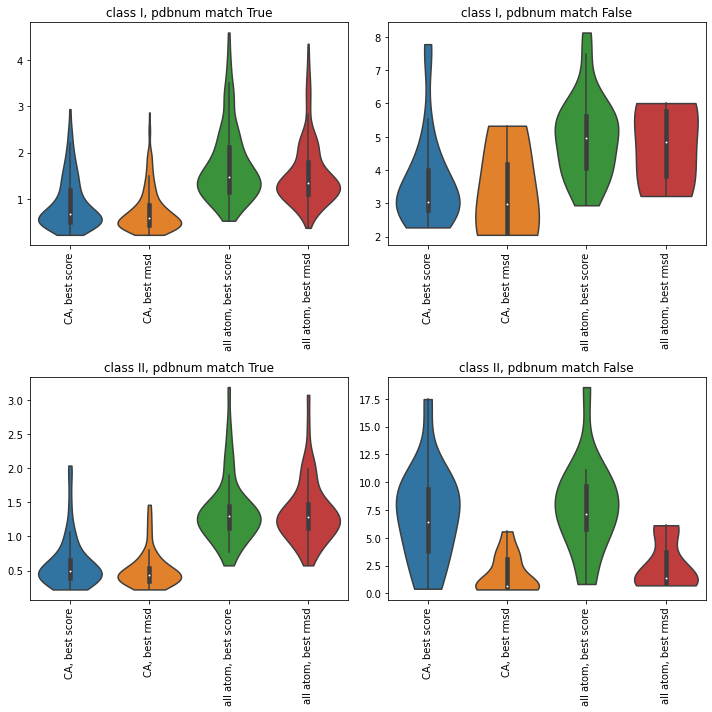

In [74]:
#make violin plots

plt.figure(figsize=(10,10))
for i,cl in enumerate(['I','II']):
    print(f'class {cl}')
    print('total:',len(results_best_score[cl]))
    for j,match in enumerate([True,False]):
        df_score=results_best_score[cl][results_best_score[cl]['match']==match]
        print(f'matching pdbnum {match}, best score:',len(df_score))
        df_rmsd=results_best_rmsd[cl][results_best_rmsd[cl]['match']==match]
        print(f'matching pdbnum {match}, best rmsd:',len(df_rmsd))
        violin={}
        violin['CA, best score']=df_score['pep_CA']
        violin['CA, best rmsd']=df_rmsd['pep_CA']
        violin['all atom, best score']=df_score['pep_all']
        violin['all atom, best rmsd']=df_rmsd['pep_all']        
        plt.subplot(2,2,2*i+j+1)
        dict_to_violin(violin,f'class {cl}, pdbnum match {match}',ylim=None)
plt.tight_layout()
plt.show()
#I
#234,211,41,64
#II
#47,44,21,24

In [75]:
#find where register jumps: best rmsd with mismatching registers
cl='I'
df=results_best_rmsd[cl]
df[df['match']==False]

,tid,pepseq,mhc,cl,cid,pdbnum,pdbnum_template,match,pep_s,mhc_s,pep_lddt,mhc_lddt,pep_CA,pep_all,mhc_CA,mhc_all,pdbnum_model
tid,,,,,,,,,,,,,,,,,
33,33,LYLVCGERG,K*d,I,7,"1,2,3,4,5,6,7,8,9","1,2,3,4,5,6,7,8,9",False,8,1,75.289280,96.286206,2.053695,4.001980,0.572134,1.348550,error
252,252,GRAEEYGADTL,BF2*021:01,I,4,"1,2,3,4,5,51,59,6,7,8,9","1,2,3,4,5,51,59,6,7,8,9",False,8,0,78.900019,95.493225,2.135979,3.220408,0.563041,1.351395,error
333,333,CTSEEMNAF,18*001:02,I,8,"1,2,3,4,5,6,7,8,9","09,1,2,3,4,5,7,8,9",False,11,0,51.836416,96.019317,5.331100,5.711627,0.253236,0.926677,error
830,830,NPRAMQALL,A1*c,I,5,"1,2,3,4,5,6,7,8,9","1,2,3,4,5,6,7,8,9",False,11,33,46.976658,94.822565,3.802083,6.011579,2.227440,2.954539,error


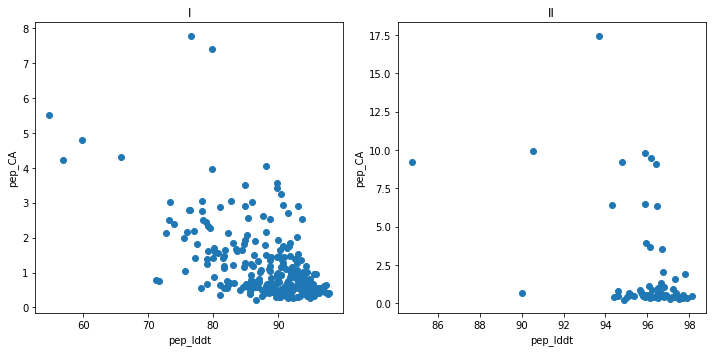

In [80]:
#score vs rmsd
plt.figure(figsize=(10,5))
for i,cl in enumerate(['I','II']):
    plt.subplot(1,2,i+1)
    df=results_best_score[cl]
    plt.scatter(df['pep_lddt'],df['pep_CA'])
    plt.title(cl)    
    plt.xlabel('pep_lddt')
    plt.ylabel('pep_CA')
plt.tight_layout()
plt.show()

# old_dataset 2: 100 binders and 100 non-binders for A*02:01

In [3]:
#where to put inputs and outputs
dataset_dir='/scratch/vmikhayl/pmhc_modeling/dataset2'
os.makedirs(dataset_dir,exist_ok=True)

In [3]:
with open('./data/pmhc_assays/peptides_A2/pos.pckl','rb') as f:
    pep_pos=pickle.load(f)
with open('./data/pmhc_assays/peptides_A2/neg.pckl','rb') as f:
    pep_neg=pickle.load(f)
print(len(pep_pos),len(pep_neg))
pep_all=[[x,'p'] for x in pep_pos]+[[x,'n'] for x in pep_neg]
pep_all=np.random.permutation(pep_all)

100 100


In [91]:
#check len: nothing to exclude
utils.print_hist([len(x[0]) for x in pep_all])
#check aa
aa_set=set(list('ACDEFGHIKLMNPQRSTVWY'))
for x in pep_all:
    if set(x[0])-aa_set:
        print(x)

8    1
9  146
10  51
11   2


In [81]:
#make AF params file
output_dir=dataset_dir+'/outputs'
output_dir=re.sub('scratch','scratch/lustre',output_dir) #for apollo ###REMOVE THIS IF NOT USING THE IAS CLUSTER!###
params={'num_ensemble':1,'model_names':('model_1',),'relax':False,'chain_break_shift':200,
        'output_dir':output_dir}

with open(dataset_dir+'/params.pckl','wb') as f:
    pickle.dump(params,f)

In [95]:
#assign templates, make AF input files
seq_tools.load_mhcs()
mhc=seq_tools.mhcs['9606','A','02:01']
score_filter=lambda x,y: x<=2 #exclude templates with with <= 2 mismatches in pep

clusters_per_register=4 #how many CA clusters to keep per peptide register

t0=time.time()
input_data_all=[]
for i,x in enumerate(pep_all):
    #assign templates        
    clusters_assigned=template_tools.assign_templates('I',x[0],mhc.data,None,
                                                      clusters_per_register=clusters_per_register,
                                                      score_filter=score_filter)    
    sequences=[x[0]]    
    msas=[]    
    mhc_A_query=mhc
    renumber_list_mhc=['M'+a for a in mhc_A_query.data['pdbnum']]
    sequences.append(mhc_A_query.seq())
    msas_filenames=get_mhc_msa_filenames('I','A',mhc_A_query.data['pdbnum'])
    msas+=[{'chain':1,'filename':f} for f in msas_filenames]    
    input_id=0
    #make hits
    for cluster_pdbnum in clusters_assigned:
        pep_query=seq_tools.NUMSEQ(seq=x[0],pdbnum=cluster_pdbnum['pdbnum'])
        renumber_list=['P'+a for a in pep_query.data['pdbnum']]+renumber_list_mhc        
        for cluster_CA in cluster_pdbnum['clusters']:
            template_hits=[]
            #make hits for CA cluster            
            for hit_i,pmhc_hit in enumerate(cluster_CA):
                fragment_alignments=[]
                pdb_id=pmhcs[pmhc_hit['pmhc_id']]['pdbs'][0][0]
                summary_record=summary[pdb_id]
                pep_target=seq_tools.load_NUMSEQ(summary_record['P'])
                pep_target=pep_target.ungap_small()
                fragment_alignments.append(template_tools.align_numseq(pep_query,pep_target))
                mhc_A_target=seq_tools.load_NUMSEQ(summary_record['M'])
                mhc_A_target=mhc_A_target.ungap_small()
                fragment_alignments.append(template_tools.align_numseq(mhc_A_query,mhc_A_target))                
                hit=template_tools.join_fragment_alignments(fragment_alignments)
                template_hit={}
                template_hit['index']=hit_i
                template_hit['name']=pdb_id                
                template_hit['aligned_cols']=len(hit['query_seq'])-hit['query_seq'].count('-')-hit['target_seq'].count('-')
                template_hit['sum_probs']=1000-(pmhc_hit['pep_score']+pmhc_hit['mhc_score'])
                template_hit['query']=hit['query_seq']
                template_hit['hit_sequence']=hit['target_seq']
                template_hit['indices_query']=hit['indices_query']
                template_hit['indices_hit']=hit['indices_target']                                
                template_hits.append(template_hit)
            #make input for CA cluster
            input_data={}
            input_data['sequences']=sequences
            input_data['msas']=msas
            input_data['template_hits']=template_hits
            input_data['renumber_list']=renumber_list
            input_data['target_id']=str(i)+x[1]
            input_data['current_id']=input_id
            input_id+=1
            #additional info (not used by AlphaFold)
            input_data['top_hit']=cluster_CA[0]  #pmhc_id,pep_score,mhc_score of top hits
            input_data['n_hits']=len(cluster_CA) #total templates in cluster
            input_data['cluster_CA']=pmhcs[cluster_CA[0]['pmhc_id']]['cluster_CA'] #cluster_CA id
            input_data['pep_pdbnum']=cluster_pdbnum['pdbnum']
            input_data_all.append(input_data)            
            
with open(dataset_dir+f'/input_data.pckl','wb') as f:
    pickle.dump(input_data_all,f)
print('total inputs:',len(input_data_all))
print('completed in {:5.1f} s'.format(time.time()-t0))

MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  1.4 s
total inputs: 3200
completed in  63.0 s


In [96]:
#split jobs

#NOTE: check dataset in dirs

import stat

inputs=input_data_all

python_path='/data/vmikhayl/alphafold-multimer/alphafold/tfold_run_alphafold.py'
params_path='/scratch/lustre/vmikhayl/pmhc_modeling/dataset2/params.pckl' 
sh_path='./run_alphafold.sh'

n_tasks=8
exclusive=False #True
gpu=True
qos='short'
max_run_time=8*60 #8 hours: check!
slow_nodes=[]

input_dir              ='/scratch/vmikhayl/pmhc_modeling/dataset2/tmp_inputs'
input_dir_server       ='/scratch/lustre/vmikhayl/pmhc_modeling/dataset2/tmp_inputs'
input_dir_proper       =input_dir+'/inputs'
input_dir_server_proper=input_dir_server+'/inputs'
log_dir                =input_dir+'/logs'
log_dir_server         =input_dir_server+'/logs'
#make dirs
for d in [input_dir_proper,log_dir]:
    os.makedirs(d,exist_ok=True)    
#make input files
indices=utils.split_jobs(len(inputs),n_tasks)
n_tasks=len(indices)
for i,job in enumerate(indices):
    c_inputs=[inputs[j] for j in job]        
    with open(input_dir_proper+'/input_'+str(i)+'.pckl','wb') as f:
        pickle.dump(c_inputs,f)            

#make .sh        
lines=[]
lines.append('#!/bin/bash')
lines.append('')
for x in slow_nodes:
    lines.append('#SBATCH --exclude=node{}'.format(x))     #exclude slow nodes        
lines.append(f'#SBATCH --array=0-{n_tasks-1}')             #run an array of n_tasks tasks
lines.append(f'#SBATCH --output={log_dir_server}/output_%a.txt')  #here %a will evaluate to array task id
lines.append(f'#SBATCH --error={log_dir_server}/error_%a.txt')
lines.append(f'#SBATCH --ntasks=1')                        #each array element is one task
if exclusive:
    lines.append(f'#SBATCH --exclusive')                   #request exclusive use of node, e.g. for hhblits
if gpu:
    lines.append(f'#SBATCH --gpus=1')                      #one gpu per task will use one core
elif not exclusive:
    lines.append(f'#SBATCH --cpus-per-task=1')             #one cpu per task
lines.append(f'#SBATCH --qos={qos}')  
lines.append(f'#SBATCH --time={max_run_time}')             #maximal run time in minutes, same for each array task
lines.append('')
lines.append(f'input_file={input_dir_server_proper}/input_$SLURM_ARRAY_TASK_ID.pckl')        
lines.append(f'srun python {python_path} --inputs $input_file --params {params_path}')

if not sh_path.startswith(('/','./')):
    sh_path='./'+sh_path
with open(sh_path,'w') as f:
    f.writelines('\n'.join(lines))
os.chmod(sh_path, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)      

In [97]:
#check results
n=0
for x in os.listdir(dataset_dir+'/outputs'):
    for y in os.listdir(dataset_dir+'/outputs/'+x):
        if y.startswith('structure'):
            n+=1
print(n)                    

3200


In [98]:
result_parse_tools.renumber_peps(dataset_dir)

193p structure_model_1_6.pdb ['bad refs_symbol |   8 ,   9 ,   8 ,   7 ,   6 ,   6 ,   5 ,   4 ,   4 |;'] 

75n structure_model_1_8.pdb ['bad refs_symbol |   4 ,   4 ,   6 ,   6 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

75n structure_model_1_11.pdb ['bad refs_symbol |   5 ,   4 ,   6 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

75n structure_model_1_9.pdb ['bad refs_symbol |   5 ,   5 ,   6 ,   6 ,   7 ,   7 ,   7 ,   8 ,   9 |;'] 

75n structure_model_1_10.pdb ['bad refs_symbol |   5 ,   4 ,   6 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

131n structure_model_1_8.pdb ['bad refs_symbol |   2 ,   2 ,   4 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

131n structure_model_1_11.pdb ['bad refs_symbol |   1 ,   1 ,   3 ,   3 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

131n structure_model_1_9.pdb ['bad refs_symbol |   4 ,   5 ,   6 ,   6 ,   8 ,   8 ,   9 ,   8 ,   8 |;'] 

131n structure_model_1_15.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 ,   8 |;'] 

131n structure_model_1_1.pdb

144p structure_model_1_4.pdb ['bad refs_symbol |   8 ,   8 ,   7 ,   7 ,   6 ,   6 ,   5 ,   4 ,   4 |;', 'bad refs_symbol |   8 ,   8 ,   7 ,   7 ,   6 ,   6 ,   5 ,   4 ,   4 |;'] 

36n structure_model_1_11.pdb ['bad refs_symbol |   4 ,   5 ,   4 ,   4 ,   6 ,   6 ,   7 ,   8 ,   9 |;'] 

36n structure_model_1_12.pdb ['bad refs_symbol |   4 ,   5 ,   4 ,   4 ,   6 ,   6 ,   7 ,   8 ,   9 |;'] 

57n structure_model_1_8.pdb ['bad refs_symbol |   4 ,   4 ,   5 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

57n structure_model_1_5.pdb ['bad refs_symbol |   4 ,   5 ,   5 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

57n structure_model_1_9.pdb ['bad refs_symbol |   4 ,   4 ,   5 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

57n structure_model_1_10.pdb ['bad refs_symbol |   4 ,   5 ,   5 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

125p structure_model_1_8.pdb ['bad refs_symbol |   6 ,   6 ,   6 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

154n structure_model_1_8.pdb ['bad refs_symbol |   4 ,   5 ,   

19n structure_model_1_0.pdb ['bad refs_symbol |   4 ,   4 ,   4 ,   4 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

77n structure_model_1_11.pdb ['bad refs_symbol |   4 ,   4 ,   5 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

86p structure_model_1_14.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   6 ,   8 ,   8 |;'] 

13n structure_model_1_8.pdb ['bad refs_symbol |   4 ,   4 ,   6 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

13n structure_model_1_9.pdb ['bad refs_symbol |   3 ,   4 ,   6 ,   6 ,   7 ,   7 ,   7 ,   8 ,   9 |;'] 

97n structure_model_1_9.pdb ['bad refs_symbol |   2 ,   2 ,   4 ,   3 ,   5 ,   6 ,   7 ,   7 ,   8 |;', 'bad refs_symbol |   2 ,   2 ,   4 ,   3 ,   5 ,   6 ,   7 ,   7 ,   8 |;'] 

97n structure_model_1_13.pdb ['bad refs_symbol |   8 ,   8 ,   8 ,   8 ,   8 ,   7 ,   6 ,   5 ,   5 |;', 'bad refs_symbol |   8 ,   8 ,   8 ,   8 ,   8 ,   7 ,   6 ,   5 ,   5 |;'] 

192n structure_model_1_15.pdb ['bad refs_symbol |   8 ,   9 ,   8 ,   7 ,   6 ,   5 ,   5 

156n structure_model_1_9.pdb ['bad refs_symbol |   4 ,   4 ,   4 ,   4 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

156n structure_model_1_15.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 ,   8 |;'] 

156n structure_model_1_10.pdb ['bad refs_symbol |   4 ,   4 ,   4 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

68n structure_model_1_8.pdb ['bad refs_symbol |   1 ,   4 ,   4 ,   3 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

68n structure_model_1_11.pdb ['bad refs_symbol |   1 ,   4 ,   4 ,   3 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

68n structure_model_1_9.pdb ['bad refs_symbol |   1 ,   4 ,   4 ,   3 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

68n structure_model_1_10.pdb ['bad refs_symbol |   1 ,   4 ,   4 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

76n structure_model_1_8.pdb ['bad refs_symbol |   4 ,   4 ,   5 ,   6 ,   7 ,   8 ,   9 ,   9 ,   8 |;'] 

76n structure_model_1_9.pdb ['bad refs_symbol |   8 ,   8 ,   8 ,   8 ,   8 ,   8 ,   8 ,   7 ,   6 |;', 'bad refs_symbol |   8 ,   8 ,  

30p structure_model_1_10.pdb ['bad refs_symbol |   4 ,   4 ,   4 ,   5 ,   5 ,   6 ,   6 ,   7 ,   8 ,   9 |;'] 

112n structure_model_1_11.pdb ['bad refs_symbol |   4 ,   4 ,   4 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

112n structure_model_1_9.pdb ['bad refs_symbol |   4 ,   4 ,   4 ,   5 ,   6 ,   6 ,   7 ,   8 ,   9 |;'] 

112n structure_model_1_15.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   5 ,   6 ,   7 ,   9 |;'] 

112n structure_model_1_12.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   5 ,   6 ,   7 ,   9 |;'] 

112n structure_model_1_10.pdb ['bad refs_symbol |   4 ,   4 ,   4 ,   5 ,   6 ,   6 ,   7 ,   8 ,   9 |;'] 

104p structure_model_1_8.pdb ['bad refs_symbol |   8 ,   8 ,   8 ,   7 ,   6 ,   6 ,   5 ,   3 ,   4 |;', 'bad refs_symbol |   8 ,   8 ,   8 ,   7 ,   6 ,   6 ,   5 ,   3 ,   4 |;'] 

104p structure_model_1_1.pdb ['bad refs_symbol |   8 ,   8 ,   8 ,   7 ,   6 ,   6 ,   5 ,   3 ,   4 |;', 'bad refs_symbol |   8 ,   8 ,   8 ,   7 ,   6 ,   6

88p structure_model_1_15.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   5 ,   6 ,   6 |;'] 

88p structure_model_1_12.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   6 ,   6 ,   5 ,   6 ,   6 |;'] 

88p structure_model_1_13.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   6 ,   6 ,   5 ,   6 ,   7 |;'] 

88p structure_model_1_10.pdb ['bad refs_symbol |   4 ,   5 ,   5 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

38n structure_model_1_8.pdb ['bad refs_symbol |   1 ,   1 ,   4 ,   4 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

174p structure_model_1_8.pdb ['bad refs_symbol |   4 ,   5 ,   6 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

174p structure_model_1_11.pdb ['bad refs_symbol |   4 ,   5 ,   6 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

174p structure_model_1_9.pdb ['bad refs_symbol |   4 ,   5 ,   6 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

174p structure_model_1_10.pdb ['bad refs_symbol |   4 ,   5 ,   6 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

4n structure_model_1_

62n structure_model_1_15.pdb ['bad refs_symbol |   4 ,   5 ,   5 ,   4 ,   6 ,   7 ,   8 ,   8 ,   9 |;'] 

62n structure_model_1_1.pdb ['bad refs_symbol |   2 ,   4 ,   4 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

62n structure_model_1_0.pdb ['bad refs_symbol |   6 ,   8 ,   6 ,   6 ,   6 ,   5 ,   5 ,   4 ,   4 |;', 'bad refs_symbol |   6 ,   8 ,   6 ,   6 ,   6 ,   5 ,   5 ,   4 ,   4 |;'] 

62n structure_model_1_10.pdb ['bad refs_symbol |   4 ,   4 ,   4 ,   4 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

62n structure_model_1_2.pdb ['bad refs_symbol |   3 ,   4 ,   4 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

146p structure_model_1_15.pdb ['bad refs_symbol |   5 ,   5 ,   6 ,   7 ,   7 ,   8 ,   8 ,   8 ,   9 |;'] 

146p structure_model_1_13.pdb ['bad refs_symbol |   9 ,   8 ,   7 ,   6 ,   5 ,   5 ,   4 ,   3 ,   4 |;', 'bad refs_symbol |   9 ,   8 ,   7 ,   6 ,   5 ,   5 ,   4 ,   3 ,   4 |;'] 

146p structure_model_1_10.pdb ['bad refs_symbol |   4 ,   6 ,   5 ,   6 ,   6 ,   7 ,   7 ,  

184p structure_model_1_3.pdb ['bad refs_symbol |   4 ,   4 ,   5 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

184p structure_model_1_8.pdb ['bad refs_symbol |   4 ,   4 ,   4 ,   6 ,   6 ,   7 ,   8 ,   8 ,   9 |;'] 

184p structure_model_1_11.pdb ['bad refs_symbol |   4 ,   4 ,   5 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

184p structure_model_1_9.pdb ['bad refs_symbol |   4 ,   5 ,   5 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

184p structure_model_1_15.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   6 ,   7 ,   8 |;'] 

184p structure_model_1_1.pdb ['bad refs_symbol |   4 ,   4 ,   5 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

184p structure_model_1_7.pdb ['bad refs_symbol |   4 ,   4 ,   4 ,   6 ,   6 ,   7 ,   8 ,   8 ,   9 |;'] 

184p structure_model_1_12.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   6 ,   7 ,   8 |;'] 

184p structure_model_1_0.pdb ['bad refs_symbol |   4 ,   4 ,   5 ,   5 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

184p structure_model_1_13

35n structure_model_1_14.pdb ['bad refs_symbol |   8 ,   8 ,   8 ,   7 ,   6 ,   6 ,   5 ,   4 ,   4 |;', 'bad refs_symbol |   8 ,   8 ,   8 ,   7 ,   6 ,   6 ,   5 ,   4 ,   4 |;'] 

1p structure_model_1_12.pdb ['bad refs_symbol |   8 ,   8 ,   8 ,   8 ,   8 ,   7 ,   7 ,   6 ,   5 |;', 'bad refs_symbol |   8 ,   8 ,   8 ,   8 ,   8 ,   7 ,   7 ,   6 ,   5 |;'] 

37n structure_model_1_8.pdb ['bad refs_symbol |   4 ,   5 ,   5 ,   6 ,   6 ,   7 ,   7 ,   7 ,   8 ,   9 |;'] 

37n structure_model_1_11.pdb ['bad refs_symbol |   4 ,   5 ,   5 ,   6 ,   6 ,   7 ,   7 ,   7 ,   8 ,   9 |;'] 

37n structure_model_1_9.pdb ['bad refs_symbol |   4 ,   5 ,   5 ,   6 ,   6 ,   7 ,   7 ,   7 ,   8 ,   9 |;'] 

37n structure_model_1_7.pdb ['bad refs_symbol |   8 ,   8 ,   6 ,   6 ,   6 ,   6 ,   4 ,   4 ,   4 ,   4 |;', 'bad refs_symbol |   8 ,   8 ,   6 ,   6 ,   6 ,   6 ,   4 ,   4 ,   4 ,   4 |;'] 

37n structure_model_1_10.pdb ['bad refs_symbol |   4 ,   5 ,   5 ,   6 ,   6 ,   7 ,   7 ,   7 ,  

127p structure_model_1_9.pdb ['bad refs_symbol |   4 ,   4 ,   4 ,   5 ,   6 ,   6 ,   7 ,   8 ,   9 |;'] 

127p structure_model_1_10.pdb ['bad refs_symbol |   1 ,   1 ,   4 ,   3 ,   5 ,   6 ,   7 ,   8 ,   9 |;'] 

9p structure_model_1_8.pdb ['bad refs_symbol |   6 ,   5 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

9p structure_model_1_11.pdb ['bad refs_symbol |   6 ,   5 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

9p structure_model_1_14.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 |;'] 

9p structure_model_1_9.pdb ['bad refs_symbol |   6 ,   5 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

9p structure_model_1_15.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 |;'] 

9p structure_model_1_12.pdb ['bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 |;'] 

9p structure_model_1_10.pdb ['bad refs_symbol |   6 ,   5 ,   6 ,   6 ,   7 ,   7 ,   8 ,   9 |;'] 

188p structure_model_1_9.pdb ['bad refs_symbol |   1 ,   1 ,   4 ,   3 ,   5 ,

In [101]:
#get input data
with open(dataset_dir+f'/input_data.pckl','rb') as f:
    input_data_all=pickle.load(f)    
input_data_dict={(x['target_id'],x['current_id']):x for x in input_data_all}
#parse
cl='I'
t0=time.time()
result_summary={}    
for target_id in os.listdir(dataset_dir+'/outputs'):    
    for filename in os.listdir(dataset_dir+f'/outputs/{target_id}'):        
        if filename.startswith('result'):
            current_id=int(filename.split('.')[0].split('_')[-1])
            renumber_list=input_data_dict[target_id,current_id]['renumber_list']
            with open(dataset_dir+f'/outputs/{target_id}/{filename}','rb') as f:
                result=pickle.load(f)['plddt']
            #reduce plddt to mean over residues and MHC chains; to add: keep residue-level features
            plddt_dict={'lddt_pep':[],'lddt_pep_a':[],'lddt_mhc':[]}                        
            for r,plddt in zip(renumber_list,result):
                if r[0]=='P' and r[1:]>='   09' and r[1:]<='  10 ': #restrict to ext. binding core
                    plddt_dict['lddt_pep'].append(plddt)                        
                if r[0]=='P' and (r[1:] in ['   2 ','   9 ']): #restrict to anchors
                    plddt_dict['lddt_pep_a'].append(plddt)                        
                elif r[0] in ['M','N']:
                    plddt_dict['lddt_mhc'].append(plddt)   
            plddt_dict={k:np.average(v) for k,v in plddt_dict.items()}            
            #get model pdbnum
            filename_pdbnum=filename.replace('result','structure')[:-4]+'_pdbnum.pkl'
            with open(dataset_dir+f'/outputs/{target_id}/{filename_pdbnum}','rb') as f:
                pdbnum_model=pickle.load(f)                
            result_summary.setdefault((target_id,current_id),{}).update(plddt_dict)                      
            result_summary[target_id,current_id]['pdbnum_model']=','.join([a.replace(' ','') for a in pdbnum_model])
#make df
result_ext=[]
for target_id,current_id in result_summary:        
    input_data_c=input_data_dict[target_id,current_id]
    pepseq=input_data_dict[target_id,current_id]['sequences'][0]
    r=result_summary[target_id,current_id]
    result={}
    result['tid']=target_id
    result['binder']=target_id[-1]=='p'
    result['pepseq']=pepseq
    result['cid']=current_id
    pdbnum_template=','.join([a.replace(' ','') for a in input_data_c['pep_pdbnum']])
    result['pdbnum_template']=pdbnum_template            
    result['pep_s']=input_data_c['top_hit']['pep_score']
    result['mhc_s']=input_data_c['top_hit']['mhc_score']
    result.update(r)
    result_ext.append(result)
result_df=pd.DataFrame(result_ext)
result_df=result_df.sort_values(by=['tid','cid'])
result_df.to_pickle(dataset_dir+'/result_df.pckl')
print('processed {:4d} records in {:5.1f} s'.format(len(result_df),time.time()-t0))

processed 3200 records in 476.6 s


In [4]:
#read the output of result_parse_tools.parse_outputs
results_df=pd.read_pickle(dataset_dir+'/result_df.pckl')
print(len(results_df))
print(results_df.columns)
print(results_df.head(5))

3200
Index(['tid', 'binder', 'pepseq', 'cid', 'pdbnum_template', 'pep_s', 'mhc_s',
       'lddt_pep', 'lddt_pep_a', 'lddt_mhc', 'pdbnum_model'],
      dtype='object')
     tid  binder     pepseq  cid     pdbnum_template  pep_s  mhc_s   lddt_pep  \
1220  0p    True  RILGAVAKV    0  2,3,4,5,51,6,7,8,9      7      0  70.169169   
1216  0p    True  RILGAVAKV    1  2,3,4,5,51,6,7,8,9      7      0  91.347459   
1227  0p    True  RILGAVAKV    2  2,3,4,5,51,6,7,8,9      7      0  55.811551   
1225  0p    True  RILGAVAKV    3  2,3,4,5,51,6,7,8,9      7      0  90.484430   
1217  0p    True  RILGAVAKV    4   1,2,3,4,5,6,7,8,9      4      0  30.456828   

      lddt_pep_a   lddt_mhc        pdbnum_model  
1220   80.305388  96.895059  2,3,4,5,51,6,7,8,9  
1216   94.040626  97.604466   1,2,3,4,5,6,7,8,9  
1227   51.864999  94.010996               error  
1225   93.449084  97.508310   1,2,3,4,5,6,7,8,9  
1217   32.719625  94.343009               error  


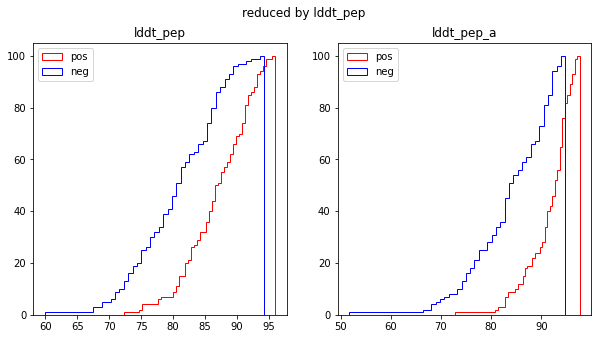

In [34]:
bins=50
results_best=result_parse_tools.reduce_to_best(results_df,['tid'],'lddt_pep',how='max')
plt.figure(figsize=(10,5))
for i,k in enumerate(['lddt_pep','lddt_pep_a']):
    plt.subplot(1,2,i+1)
    df=results_best[results_best['binder']]
    plt.hist(df[k],color='red',histtype='step',bins=bins,cumulative=1)
    df=results_best[~results_best['binder']]
    plt.hist(df[k],color='blue',histtype='step',bins=bins,cumulative=1)
    plt.legend(['pos','neg'])
    plt.title(k)
plt.suptitle('reduced by lddt_pep')
plt.show()

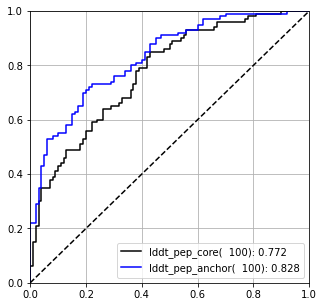

In [133]:
df=results_best
labels=df['binder'].values.astype(int)
scores=[[labels,df['lddt_pep'].values],[labels,df['lddt_pep_a'].values]]
titles=['lddt_pep_core','lddt_pep_anchor']
plt.figure(figsize=(5,5))
utils.plot_ROC(scores,titles)
plt.show()

In [35]:
#get average predicted distance for anchors
from scipy.special import softmax
def distogram_to_mean(d,bins):
    d=softmax(d,axis=2)
    bins=np.concatenate([[0.],bins,[100.]])
    bins_av=(bins[:-1]+bins[1:])/2
    return np.sum(bins_av*d,axis=2)

t0=time.time()
with open(dataset_dir+f'/input_data.pckl','rb') as f:
    input_data_all=pickle.load(f)    
input_data_dict={(x['target_id'],x['current_id']):x for x in input_data_all}
distances={}
for tid,cid in zip(results_best['tid'],results_best['cid']):
    with open(dataset_dir+f'/outputs/{tid}/result_model_1_{cid}.pkl','rb') as f:
        result=pickle.load(f)
    distogram=result['distogram']['logits']
    bins=result['distogram']['bin_edges']
    distogram=distogram_to_mean(distogram,bins)    
    #find indices  
    inds_anchor=[]
    inds_nonpep=[]
    res_keep=['P   2 ','P   9 ']
    for i,x in enumerate(input_data_dict[tid,cid]['renumber_list']):
        if x in res_keep:
            inds_anchor.append(i)
        if not x.startswith('P'):
            inds_nonpep.append(i)
    distogram=distogram[:,inds_nonpep]
    distogram=distogram[inds_anchor]    
    mindist=np.min(distogram,axis=1)
    distances[tid]=np.average(mindist)   
print('completed {:3d} in {:5.1f} s'.format(len(distances),time.time()-t0))

completed 200 in   6.5 s


In [36]:
distances_p=np.array([v for k,v in distances.items() if k[-1]=='p'])
distances_n=np.array([v for k,v in distances.items() if k[-1]=='n'])

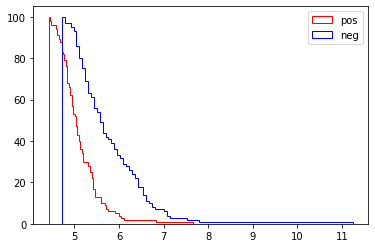

In [40]:
#continuous
bins=100
plt.figure()
plt.hist(distances_p,histtype='step',bins=bins,color='r',cumulative=-1)
plt.hist(distances_n,histtype='step',bins=bins,color='b',cumulative=-1)
plt.legend(['pos','neg'])
plt.show()

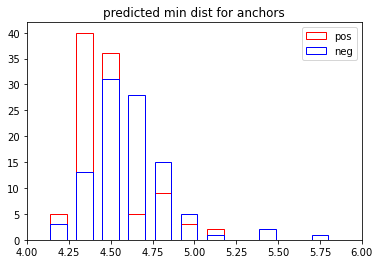

In [214]:
#by bins
d_u=np.unique(list(distances.values()))
dp_counts=[np.sum(distances_p==x) for x in d_u]
dn_counts=[np.sum(distances_n==x) for x in d_u]
plt.figure()
plt.bar(d_u,dp_counts,edgecolor='r',fill=False,width=0.1)
plt.bar(d_u,dn_counts,edgecolor='b',fill=False,width=0.1)
plt.xlim((4,6))
plt.legend(['pos','neg'])
plt.title('predicted min dist for anchors')
plt.show()

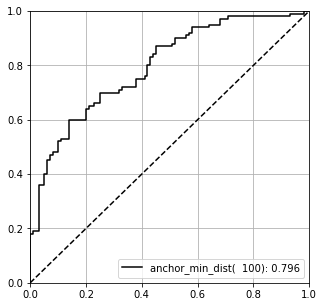

In [41]:
labels=np.array([x[-1]=='p' for x in distances]).astype(int)
predictions=-np.array(list(distances.values()))
scores=[[labels,predictions]]
titles=['anchor_min_dist']
plt.figure(figsize=(5,5))
utils.plot_ROC(scores,titles)
plt.show()
#0.696 for discrete
#0.796 for continuous

In [7]:
#netmhcpan 4.1 scores
with open('./data/pmhc_assays/peptides_A2/Kd.pckl','rb') as f:
    pepmhc_dict_Kd=pickle.load(f)
with open('./data/pmhc_assays/peptides_A2/elrank.pckl','rb') as f:
    pepmhc_dict_elrank=pickle.load(f)
pep_netmhc=[]
for p in pep_pos:
    pep_netmhc.append([1.,pepmhc_dict_Kd[p,'A*02:01'],pepmhc_dict_elrank[p,'A*02:01']])
for p in pep_neg:
    pep_netmhc.append([0.,pepmhc_dict_Kd[p,'A*02:01'],pepmhc_dict_elrank[p,'A*02:01']])
pep_netmhc=np.array(pep_netmhc)
print(len(pep_netmhc))

200


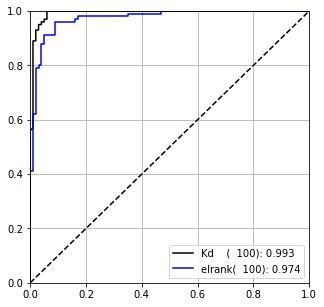

In [9]:
#netmhcpan 4.1 performance
scores=[[pep_netmhc[:,0],-pep_netmhc[:,1]],[pep_netmhc[:,0],-pep_netmhc[:,2]]]
titles=['Kd','elrank']
plt.figure(figsize=(5,5))
utils.plot_ROC(scores,titles)
plt.show()
#0.696 for discrete
#0.796 for continuous

In [139]:
with open(dataset_dir+'/outputs/0p/result_model_1_7.pkl','rb') as f:
    result_p=pickle.load(f)
print(result_p.keys())

dict_keys(['distogram', 'experimentally_resolved', 'masked_msa', 'predicted_lddt', 'structure_module', 'plddt', 'ranking_confidence'])


In [160]:
result_p['distogram']['logits'].shape

(191, 191, 64)

# trash

In [ ]:
#check af weights v2.1(?) vs 2.0(?): identical!!!
import numpy as np
d1='/data/vmikhayl/alphafold/databases/params'
d2='/data/vmikhayl/alphafold-multimer/databases/params'
w1=np.load(d1+'/params_model_1.npz')
w2=np.load(d2+'/params_model_1.npz')

for k in w1.files:
    print(k,np.sum(np.abs(w1[k]-w2[k]))) #0.0

In [1]:
import Bio.PDB as PDB

In [2]:
pdb_parser=PDB.PDBParser(PERMISSIVE=False,QUIET=True)

#structure=pdb_parser.get_structure(name,filename)[0]

In [3]:
help(pdb_parser.get_structure)

Help on method get_structure in module Bio.PDB.PDBParser:

get_structure(id, file) method of Bio.PDB.PDBParser.PDBParser instance
    Return the structure.
    
    Arguments:
     - id - string, the id that will be used for the structure
     - file - name of the PDB file OR an open filehandle



In [171]:
df_target[df_target['pmhc_id']==41]

,class,cluster_seq,pmhc_id,pdb_id,date,tails,netmhc_tails,netmhc_kd,pep,mhc_a,mhc_b,exclude_pdbs
25,I,41,41,5c0g_0,2015-06-12,"(0, 0)","(0, 0)",166.779595,YQFGPDFPIA,<tfold.utils.seq_tools.NUMSEQ object at 0x7fb4...,None,"[5c0i, 5c09, 5c07, 5c0b, 5c0g, 5c0e]"


In [174]:
pmhcs[41]['pdbs']

[('5c0e_0',
  {'pep_gaps': 0, 'linker': False, 'resolution': 1.49, 'includes_tcr': 0}),
 ('5c07_0',
  {'pep_gaps': 0, 'linker': False, 'resolution': 2.11, 'includes_tcr': 2}),
 ('5c07_1',
  {'pep_gaps': 0, 'linker': False, 'resolution': 2.11, 'includes_tcr': 2})]

In [175]:
pmhcs_filtered

[{'id': 1,
  'pmhc_ids': array([  1, 122, 328, 463, 549, 645, 679, 857]),
  'pdbs': [('1m6o_0',
    {'pep_gaps': 0, 'linker': False, 'resolution': 1.6, 'includes_tcr': 0}),
   ('1n2r_0',
    {'pep_gaps': 0, 'linker': False, 'resolution': 1.7, 'includes_tcr': 0}),
   ('1syv_0',
    {'pep_gaps': 0, 'linker': False, 'resolution': 1.7, 'includes_tcr': 0}),
   ('3l3i_0',
    {'pep_gaps': 0, 'linker': False, 'resolution': 1.7, 'includes_tcr': 0}),
   ('3l3d_0',
    {'pep_gaps': 0, 'linker': False, 'resolution': 1.8, 'includes_tcr': 0}),
   ('3l3g_0',
    {'pep_gaps': 0, 'linker': False, 'resolution': 2.1, 'includes_tcr': 0}),
   ('3l3j_0',
    {'pep_gaps': 0, 'linker': False, 'resolution': 2.4, 'includes_tcr': 0}),
   ('3l3k_0',
    {'pep_gaps': 0, 'linker': False, 'resolution': 2.6, 'includes_tcr': 0})],
  'date': '2002-07-17'},
 {'id': 2,
  'pmhc_ids': array([  2, 822]),
  'pdbs': [('6kwl_0',
    {'pep_gaps': 0, 'linker': False, 'resolution': 1.8, 'includes_tcr': 0}),
   ('6kwk_0',
    {'p

In [ ]:
def get_regression_scores_I(df):    
    with open(data_dir+'/obj/regression_I.pckl','rb') as f:
        regparams=pickle.load(f)    
    features=pd.DataFrame(list(df.apply(lambda x: _get_features1(x),axis=1).values))
    features['P']=3*features[[f'P{i}' for i in range(1,10)]].mean(axis=1) # *3 for historical reasons
    reg_ident=1+features['register_identified'].values.astype(int)
    features=features[['len','P']].values    
    return np.exp(np.dot(features,regparams['coef'])+regparams['intercept'])+reg_ident*5.
def get_regression_scores_II(df):
    pass


In [148]:
z=pd.DataFrame([[1,2],[3,4],[5,6]],columns=['x1','x2'])
z['x1'].isin([2,3])

0    False
1     True
2    False
Name: x1, dtype: bool

In [244]:
def _mhcb(x):
    if x['class']=='I':
        return None
    else:
        return x['mhc_b'].data    
def _exclude_pdbs(x):
    if 'exclude_pdbs' in x.index:
        return set(x['exclude_pdbs'])
    else:
        return None    
xx=df_target.apply(lambda x: template_tools.assign_templates(x['class'],x['pep'],
                                                x['mhc_a'].data,mhc_B=_mhcb(x),
                                                templates_per_register=params[x['class']]['templates_per_register'],
                                                pep_gap_penalty=params[x['class']]['pep_gap_penalty'],
                                                mhc_cutoff=params[x['class']]['mhc_cutoff'],
                                                pdbs_exclude=_exclude_pdbs(x),date_cutoff=date_cutoff,
                                                score_cutoff=params[x['class']]['score_cutoff']),axis=1)    

In [263]:
xx[300][4,3].values

array([{'pdb_id': '5dmk_0', 'pep_score': 13, 'mhc_score': 1, 'pep_gaps': 0, 'score': 14},
       {'pdb_id': '3cup_0', 'pep_score': 14, 'mhc_score': 1, 'pep_gaps': 0, 'score': 15},
       {'pdb_id': '1f3j_0', 'pep_score': 14, 'mhc_score': 1, 'pep_gaps': 0, 'score': 15},
       {'pdb_id': '1es0_0', 'pep_score': 15, 'mhc_score': 1, 'pep_gaps': 0, 'score': 16},
       {'pdb_id': '3mbe_0', 'pep_score': 16, 'mhc_score': 1, 'pep_gaps': 0, 'score': 17},
       {'pdb_id': '1iao_0', 'pep_score': 16, 'mhc_score': 19, 'pep_gaps': 0, 'score': 35},
       {'pdb_id': '1d9k_0', 'pep_score': 16, 'mhc_score': 24, 'pep_gaps': 0, 'score': 40},
       {'pdb_id': '2p24_0', 'pep_score': 15, 'mhc_score': 25, 'pep_gaps': 0, 'score': 40},
       {'pdb_id': '1iak_0', 'pep_score': 16, 'mhc_score': 24, 'pep_gaps': 0, 'score': 40},
       {'pdb_id': '2pxy_0', 'pep_score': 16, 'mhc_score': 25, 'pep_gaps': 0, 'score': 41},
       {'pdb_id': '1k2d_0', 'pep_score': 18, 'mhc_score': 25, 'pep_gaps': 0, 'score': 43},
    

In [266]:
for a in xx[300][4,3].values:
    print(pmhcs[summary[a['pdb_id']]['pmhc_id']]['cluster_CA'])
    #print(''.join(summary[a['pdb_id']]['P']['data']['seq']))

477
398
449
454
456
427
417
428
481
429
404
412
408
483
432


In [265]:
df_target.iloc[300]

class                                                              II
cluster_seq                                                       275
pdb_id                                                         6blr_0
pmhc_id                                                           416
date                                                       2017-11-11
tails                                                          (4, 3)
netmhc_tails                                                   (5, 0)
netmhc_kd                                                 4369.087483
pep                                                  HLVERLYLVCGEEGAG
mhc_a               <tfold.utils.seq_tools.NUMSEQ object at 0x7f8d...
mhc_b               <tfold.utils.seq_tools.NUMSEQ object at 0x7f8d...
exclude_pdbs                                             [6blr, 6dfs]
seqnn_logkds_all    [[(0, 7), 5.264841079711914], [(1, 6), 4.88724...
seqnn_logkd                                                  4.178939
seqnn_tails         

In [224]:
#compare inputs to run_4
af_inputs4=[]
for filename in os.listdir('/scratch/vmikhayl/pmhc_modeling/discovery_dataset/run_4/inputs'):
    with open('/scratch/vmikhayl/pmhc_modeling/discovery_dataset/run_4/inputs/'+filename,'rb') as f:
        af_inputs4+=pickle.load(f)
print(len(af_inputs4))

inputs_dict={(x['target_id'],x['current_id']):x for x in af_inputs}
inputs_dict4={(x['target_id'],x['current_id']):x for x in af_inputs4}
print(inputs_dict.keys()==inputs_dict4.keys())
dif_inputs=[]
for k in inputs_dict:
    if inputs_dict[k]!=inputs_dict4[k]:
        dif_inputs.append((inputs_dict[k],inputs_dict4[k]))
print(len(dif_inputs))

klist=['sequences', 'msas',  'renumber_list', 'target_id', 'current_id','registers','true_pdb']#, 'best_mhc_score', 'best_score', ] #all keys except template_hits
for x in dif_inputs:
    for k in klist:
        assert x[0][k]==x[1][k] 
#difference in template_hits, scores

#how many differences in pdb sets for given target?
k0set=np.unique([k[0] for k in inputs_dict])
pdb_dif=[]
for k0 in k0set:
    pdbs_old=set()
    pdbs_new=set()
    for k in inputs_dict:
        if k[0]==k0:
            pdbs_old|=set([y['name'] for y in inputs_dict4[k]['template_hits']])
            pdbs_new|=set([y['name'] for y in inputs_dict[k]['template_hits']])
    if (pdbs_old-pdbs_new) or (pdbs_new-pdbs_old):
        pdb_dif.append([pdbs_old-pdbs_new,pdbs_new-pdbs_old])
print(len(pdb_dif))   

#stable sort => less difference, but still; but it shouldn't matter

1740
True
1412
283


In [219]:
pdb_dif[:10]

[[{'3dx8_0', '3lkr_0'}, {'3dx7_0', '3w39_0'}],
 [{'2x4o_0', '3mrj_0', '3mrl_0', '3o3d_0'},
  {'2gtz_0', '3mre_0', '3o3e_0', '3pwj_0'}],
 [{'1uxs_0', '4g9d_0'}, {'4g8i_0', '5ib2_0'}],
 [{'1yn7_0', '2zok_0', '5mzm_0'}, {'3l3h_0', '4pg2_0', '5e8p_0'}],
 [{'3vri_0', '3vrj_0', '6d2r_0'}, {'5t6w_0', '5t6x_0', '5vwd_0'}],
 [{'5u98_0'}, {'6d29_0'}],
 [{'1g7q_0'}, {'2fo4_0'}],
 [{'1i1f_0', '1i7t_0', '1t1z_0', '3kla_0', '5eu3_0', '5eu6_0'},
  {'1lp9_0', '2x4u_0', '3utq_0', '5eu4_0', '5hhp_0'}],
 [{'3v5k_0', '3wl9_0', '5wwu_0'}, {'3wlb_0', '5nmh_0', '5wwi_0'}],
 [{'1agd_0', '4qru_0', '4u1m_0'}, {'1age_0', '3skm_0', '4u1n_0'}]]

In [220]:
print(template_tools.template_info['I'].columns)
x=template_tools.template_info['I']
x[x['pdb_id_short'].isin(['3dx8','3dx7'])]

Index(['cluster_seq', 'cluster_CA', 'pmhc_id', 'pdb_id', 'pdb_id_short',
       'date', 'pep_gaps'],
      dtype='object')


,cluster_seq,cluster_CA,pmhc_id,pdb_id,pdb_id_short,date,pep_gaps
117,52,47,53,3dx7_0,3dx7,2008-07-23,0
750,52,47,354,3dx8_0,3dx8,2008-07-23,0


In [64]:
pmhcs_df[(pmhcs_df['class']=='II')&(pmhcs_df['date']>date_cutoff)]
#just 13 (11 of them used now); netmhc: 7 correct, 6 wrong

,id,class,cluster_seq,cluster_CA,date,pep,tails,linker,mhc_a_allele,mhc_b_allele,netmhc_core,netmhc_kd,netmhc_tails
11,84,II,78,409,2021-10-04,LQPFPQPELPYGSGGS,"(2, 5)",False,"(9606, DQA1, 05:01)","(9606, DQB1, 02:01)",----PQPELPYGS---,407.707145,"(4, 3)"
20,155,II,129,416,2020-06-08,GQVELGGGNAVEVCK,"(3, 3)",True,"(9606, DQA1, 03:01)","(9606, DQB1, 03:02)",----LGGGNAVEV--,5298.233389,"(4, 2)"
23,174,II,145,418,2019-11-19,GGYXAXPAKAAAT,"(2, 2)",False,"(9606, DRA, 01:01)","(9606, DRB1, 04:01)",--YXAXPAKAA--,2778.523214,"(2, 2)"
43,350,II,241,433,2018-09-25,RVSYYGPKTSPVQGG,"(3, 3)",True,"(10090, IAA, b)","(10090, IAB, b)",---YYGPKTSPV---,229.179179,"(3, 3)"
44,351,II,242,434,2018-08-13,ARRPPLAELAALNLSGSRL,"(5, 5)",False,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)",-----LAELAALNL-----,75.151370,"(5, 5)"
47,368,II,252,436,2019-07-24,APFSEQEQPVLG,"(1, 2)",False,"(9606, DQA1, 02:01)","(9606, DQB1, 02:01)",--FSEQEQPVL-,7694.988207,"(2, 1)"
56,442,II,286,442,2018-09-10,QPFPQPEQPFPGS,"(1, 3)",False,"(9606, DQA1, 05:01)","(9606, DQB1, 02:01)",---PQPEQPFPG-,1696.890322,"(3, 1)"
63,487,II,310,447,2018-05-23,AGNHAAGILTLGK,"(2, 2)",False,"(9606, DQA1, 01:02)","(9606, DQB1, 06:02)",--NHAAGILTL--,156.051427,"(2, 2)"
64,502,II,313,448,2018-05-15,HLVERLYLVCGGEGAG,"(4, 3)",True,"(10090, IAA, d)","(10090, IAB, g7)",------YLVCGGEGA-,6249.048173,"(6, 1)"
69,513,II,321,453,2019-08-22,APMPMPELPYPGSGGSIEGR,"(1, 10)",False,"(9606, DQA1, 05:01)","(9606, DQB1, 02:01)",---PMPELPYPG--------,363.226411,"(3, 8)"
